# Demand forecasting model evaluation and optimisation v3

In this notebook the development of other models is exploreed. Particularly, Prophet and LSTM. No EDA is added here as this is already been performed in previous stages.

## PROPHET

/Users/mireiataboada/personal-repos/project-module-2024-apr-mireiatz/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ERROR:prophet.plot:Importing plotly failed. Interactive plots will not work.
/var/folders/fp/13hwwrjs1l7b1bb0kcbdkw5w0000gn/T/ipykernel_17338/4007712217.py:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../ml/data/historical/backup/processed_data_20241005_155929.csv')
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/fp/13hwwrjs1l7b1bb0kcbdkw5w0000gn/T/tmphqwaehfv/aw4mw1ri.json
DEBUG:cmdstanpy:input tempfile: /var/folders/fp/13hwwrjs1l7b1bb0kcbdkw5w0000gn/T/tmphqwaehfv/v62wvyxx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cm

            ds      yhat  yhat_lower  yhat_upper
772 2023-09-13 -0.006820   -0.049035    0.036744
773 2023-09-14 -0.015566   -0.059057    0.024113
774 2023-09-15 -0.015505   -0.054017    0.027784
775 2023-09-16 -0.016652   -0.061623    0.025554
776 2023-09-17 -0.017884   -0.062244    0.025875


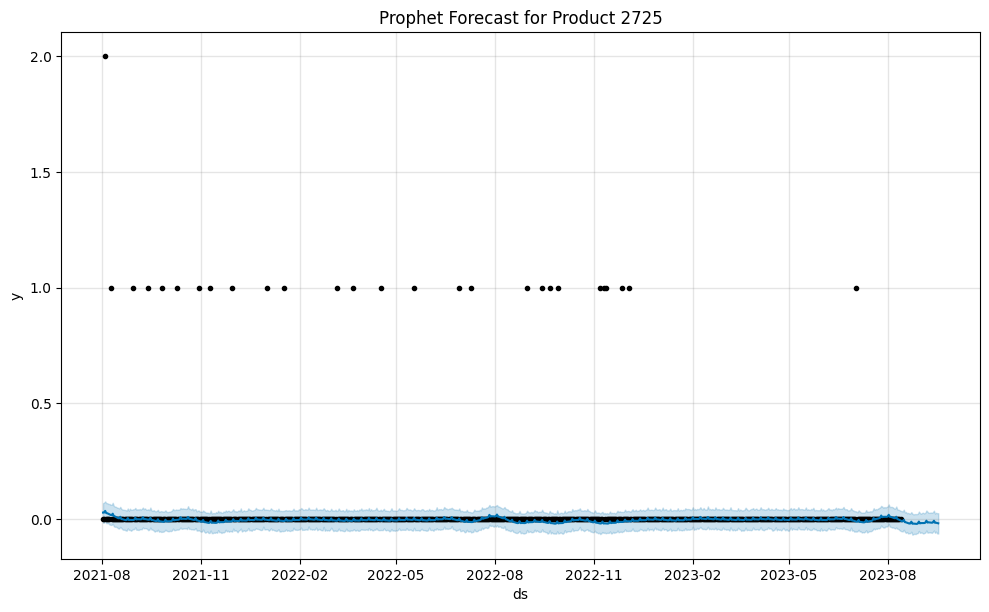

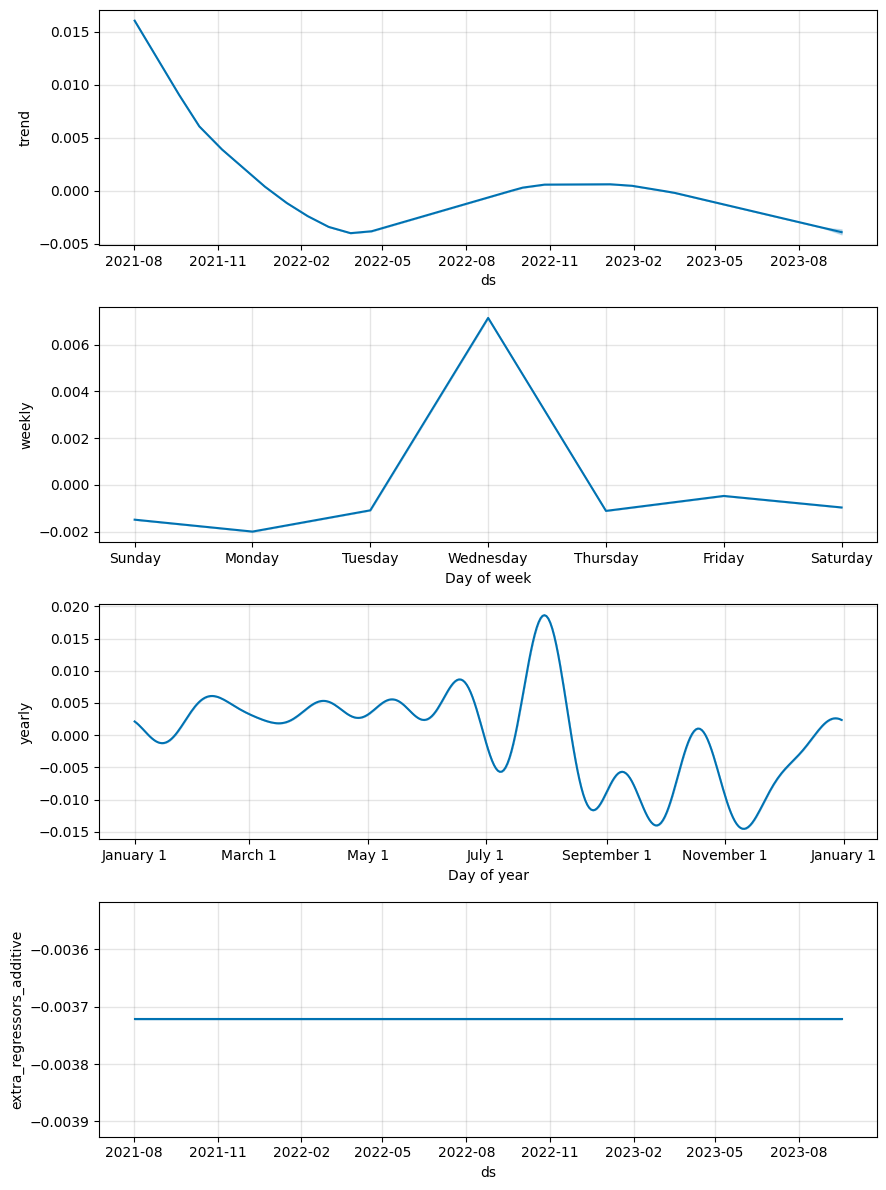

In [19]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_csv('../../ml/data/historical/backup/processed_data_20241005_155929.csv')

# Prepare for Prophet (adding 'ds' and 'y' columns)
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['quantity']

# Filter for a specific product (Product ID 2725)
product_id = 2725  
product_data = df[df['product_id_encoded'] == product_id][['ds', 'y', 'in_stock', 'per_item_value', 'quantity_rolling_avg_7']]

# Fill missing values
product_data.fillna(0, inplace=True)

# Initialize Prophet with regressors
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.add_regressor('in_stock')
model.add_regressor('per_item_value')
model.add_regressor('quantity_rolling_avg_7')

# Fit the model with the product data
model.fit(product_data[['ds', 'y', 'in_stock', 'per_item_value', 'quantity_rolling_avg_7']])

# Create a future dataframe with 35 days ahead
future = model.make_future_dataframe(periods=35)
# Use the last known values for regressors
future['in_stock'] = product_data['in_stock'].iloc[-1]
future['per_item_value'] = product_data['per_item_value'].iloc[-1]
future['quantity_rolling_avg_7'] = product_data['quantity_rolling_avg_7'].iloc[-1]

# Make predictions
forecast = model.predict(future)

# Display predictions
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot the forecast
model.plot(forecast)
plt.title(f'Prophet Forecast for Product {product_id}')
plt.show()

# Plot the seasonal components
model.plot_components(forecast)
plt.show()

In [18]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Get a list of unique product IDs
product_ids = df['product_id_encoded'].unique()

# Dictionary to store the forecasts for each product
forecasts = {}
performance_metrics = []

for product_id in product_ids:
    # Filter the data for the current product
    product_data = df[df['product_id_encoded'] == product_id]

    # Select the necessary columns for Prophet ('ds', 'y', plus the regressors)
    product_data = product_data[['ds', 'y', 'in_stock', 'per_item_value', 'quantity_rolling_avg_7']]

    # Handle missing values (fill with 0 or other imputation strategy)
    product_data.fillna(0, inplace=True)

    # Initialise Prophet model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
    
    # Add external regressors
    model.add_regressor('in_stock')
    model.add_regressor('per_item_value')
    model.add_regressor('quantity_rolling_avg_7')

    # Fit the model
    model.fit(product_data[['ds', 'y', 'in_stock', 'per_item_value', 'quantity_rolling_avg_7']])

    # Create a future dataframe for predictions (e.g., next 35 days)
    future = model.make_future_dataframe(periods=35)

    # Add the regressors to the future dataframe
    future['in_stock'] = product_data['in_stock'].iloc[-1]
    future['per_item_value'] = product_data['per_item_value'].iloc[-1]
    future['quantity_rolling_avg_7'] = product_data['quantity_rolling_avg_7'].iloc[-1]

    # Generate the forecast
    forecast = model.predict(future)

    # Store the forecast for this product
    forecasts[product_id] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    # Evaluate the model performance (using historical data for evaluation)
    y_true = product_data['y']
    y_pred = forecast['yhat'][:len(y_true)]  # Ensure alignment of lengths
    
    # Calculate MAE 
    mae = mean_absolute_error(y_true, y_pred)
    
    # Store the performance metric
    performance_metrics.append({'product_id': product_id, 'mae': mae})

    # Print the performance of the current product
    print(f'Product {product_id} - MAE: {mae}')


20:21:22 - cmdstanpy - INFO - Chain [1] start processing
20:21:22 - cmdstanpy - INFO - Chain [1] done processing
20:21:23 - cmdstanpy - INFO - Chain [1] start processing
20:21:23 - cmdstanpy - INFO - Chain [1] done processing


Product 1 - MAE: 0.1170504390107083
Product 2341 - MAE: 0.0682281604440463


20:21:23 - cmdstanpy - INFO - Chain [1] start processing
20:21:23 - cmdstanpy - INFO - Chain [1] done processing
20:21:23 - cmdstanpy - INFO - Chain [1] start processing
20:21:23 - cmdstanpy - INFO - Chain [1] done processing


Product 6 - MAE: 0.7744073883469801
Product 8 - MAE: 0.388417216784883


20:21:23 - cmdstanpy - INFO - Chain [1] start processing
20:21:23 - cmdstanpy - INFO - Chain [1] done processing
20:21:23 - cmdstanpy - INFO - Chain [1] start processing
20:21:23 - cmdstanpy - INFO - Chain [1] done processing


Product 9 - MAE: 0.11437932344544785


20:21:23 - cmdstanpy - INFO - Chain [1] start processing
20:21:23 - cmdstanpy - INFO - Chain [1] done processing


Product 11 - MAE: 0.07685495926170147


20:21:24 - cmdstanpy - INFO - Chain [1] start processing
20:21:24 - cmdstanpy - INFO - Chain [1] done processing


Product 13 - MAE: 0.635307047834104


20:21:24 - cmdstanpy - INFO - Chain [1] start processing
20:21:24 - cmdstanpy - INFO - Chain [1] done processing


Product 14 - MAE: 0.07168336700638875
Product 16 - MAE: 1.1393563496858763


20:21:24 - cmdstanpy - INFO - Chain [1] start processing
20:21:24 - cmdstanpy - INFO - Chain [1] done processing
20:21:24 - cmdstanpy - INFO - Chain [1] start processing
20:21:24 - cmdstanpy - INFO - Chain [1] done processing


Product 17 - MAE: 0.3053757458569362
Product 2342 - MAE: 0.03827835432117424


20:21:24 - cmdstanpy - INFO - Chain [1] start processing
20:21:25 - cmdstanpy - INFO - Chain [1] done processing
20:21:25 - cmdstanpy - INFO - Chain [1] start processing
20:21:25 - cmdstanpy - INFO - Chain [1] done processing


Product 18 - MAE: 1.5311209370189924
Product 2343 - MAE: 0.14554888472493677


20:21:25 - cmdstanpy - INFO - Chain [1] start processing
20:21:25 - cmdstanpy - INFO - Chain [1] done processing
20:21:25 - cmdstanpy - INFO - Chain [1] start processing
20:21:25 - cmdstanpy - INFO - Chain [1] done processing


Product 2344 - MAE: 0.1361162557985123
Product 19 - MAE: 0.388931195729237


20:21:25 - cmdstanpy - INFO - Chain [1] start processing
20:21:25 - cmdstanpy - INFO - Chain [1] done processing
20:21:25 - cmdstanpy - INFO - Chain [1] start processing
20:21:25 - cmdstanpy - INFO - Chain [1] done processing
20:21:26 - cmdstanpy - INFO - Chain [1] start processing


Product 20 - MAE: 0.1053075645903913
Product 2345 - MAE: 1.0275594699135109


20:21:26 - cmdstanpy - INFO - Chain [1] done processing
20:21:26 - cmdstanpy - INFO - Chain [1] start processing
20:21:26 - cmdstanpy - INFO - Chain [1] done processing


Product 21 - MAE: 0.05752013637243558
Product 22 - MAE: 0.15188759261486057


20:21:26 - cmdstanpy - INFO - Chain [1] start processing
20:21:26 - cmdstanpy - INFO - Chain [1] done processing
20:21:26 - cmdstanpy - INFO - Chain [1] start processing
20:21:26 - cmdstanpy - INFO - Chain [1] done processing


Product 2346 - MAE: 0.44510088020402544
Product 23 - MAE: 1.6707740219181753


20:21:26 - cmdstanpy - INFO - Chain [1] start processing
20:21:26 - cmdstanpy - INFO - Chain [1] done processing
20:21:27 - cmdstanpy - INFO - Chain [1] start processing
20:21:27 - cmdstanpy - INFO - Chain [1] done processing


Product 2347 - MAE: 0.038738166353968755
Product 27 - MAE: 0.016219334914800577


20:21:27 - cmdstanpy - INFO - Chain [1] start processing
20:21:27 - cmdstanpy - INFO - Chain [1] done processing
20:21:27 - cmdstanpy - INFO - Chain [1] start processing
20:21:27 - cmdstanpy - INFO - Chain [1] done processing


Product 28 - MAE: 1.5719617221442734
Product 29 - MAE: 0.7631557961925891


20:21:27 - cmdstanpy - INFO - Chain [1] start processing
20:21:27 - cmdstanpy - INFO - Chain [1] done processing
20:21:27 - cmdstanpy - INFO - Chain [1] start processing
20:21:27 - cmdstanpy - INFO - Chain [1] done processing


Product 30 - MAE: 0.3273033844077705
Product 32 - MAE: 0.120701897619842


20:21:28 - cmdstanpy - INFO - Chain [1] start processing
20:21:28 - cmdstanpy - INFO - Chain [1] done processing
20:21:28 - cmdstanpy - INFO - Chain [1] start processing
20:21:28 - cmdstanpy - INFO - Chain [1] done processing


Product 2348 - MAE: 0.581840571675268
Product 35 - MAE: 0.42417093516582866


20:21:28 - cmdstanpy - INFO - Chain [1] start processing
20:21:28 - cmdstanpy - INFO - Chain [1] done processing
20:21:28 - cmdstanpy - INFO - Chain [1] start processing
20:21:28 - cmdstanpy - INFO - Chain [1] done processing


Product 36 - MAE: 0.470280477186729
Product 2349 - MAE: 0.3818842980424519


20:21:28 - cmdstanpy - INFO - Chain [1] start processing
20:21:28 - cmdstanpy - INFO - Chain [1] done processing
20:21:29 - cmdstanpy - INFO - Chain [1] start processing
20:21:29 - cmdstanpy - INFO - Chain [1] done processing


Product 42 - MAE: 0.2246193502131882
Product 43 - MAE: 0.5725513103480849


20:21:29 - cmdstanpy - INFO - Chain [1] start processing
20:21:29 - cmdstanpy - INFO - Chain [1] done processing
20:21:29 - cmdstanpy - INFO - Chain [1] start processing
20:21:29 - cmdstanpy - INFO - Chain [1] done processing


Product 44 - MAE: 1.411449853389868
Product 2350 - MAE: 1.3889903697890404


20:21:29 - cmdstanpy - INFO - Chain [1] start processing
20:21:30 - cmdstanpy - INFO - Chain [1] done processing
20:21:30 - cmdstanpy - INFO - Chain [1] start processing
20:21:30 - cmdstanpy - INFO - Chain [1] done processing


Product 46 - MAE: 0.021583085189512928
Product 48 - MAE: 0.5175717980985995


20:21:30 - cmdstanpy - INFO - Chain [1] start processing
20:21:31 - cmdstanpy - INFO - Chain [1] done processing
20:21:31 - cmdstanpy - INFO - Chain [1] start processing
20:21:31 - cmdstanpy - INFO - Chain [1] done processing
20:21:31 - cmdstanpy - INFO - Chain [1] start processing


Product 50 - MAE: 0.024263226214429764
Product 2351 - MAE: 0.15658486205067343


20:21:31 - cmdstanpy - INFO - Chain [1] done processing
20:21:31 - cmdstanpy - INFO - Chain [1] start processing
20:21:31 - cmdstanpy - INFO - Chain [1] done processing


Product 53 - MAE: 0.18185187747279558
Product 55 - MAE: 0.32254116467934707


20:21:31 - cmdstanpy - INFO - Chain [1] start processing
20:21:31 - cmdstanpy - INFO - Chain [1] done processing
20:21:31 - cmdstanpy - INFO - Chain [1] start processing
20:21:32 - cmdstanpy - INFO - Chain [1] done processing


Product 58 - MAE: 1.5484570422581396
Product 2352 - MAE: 0.35448579022053794


20:21:32 - cmdstanpy - INFO - Chain [1] start processing
20:21:32 - cmdstanpy - INFO - Chain [1] done processing
20:21:32 - cmdstanpy - INFO - Chain [1] start processing
20:21:32 - cmdstanpy - INFO - Chain [1] done processing


Product 60 - MAE: 0.3684810274569195
Product 62 - MAE: 0.7517950377270242


20:21:32 - cmdstanpy - INFO - Chain [1] start processing
20:21:32 - cmdstanpy - INFO - Chain [1] done processing
20:21:32 - cmdstanpy - INFO - Chain [1] start processing
20:21:32 - cmdstanpy - INFO - Chain [1] done processing


Product 63 - MAE: 0.7021954391430993


20:21:32 - cmdstanpy - INFO - Chain [1] start processing
20:21:32 - cmdstanpy - INFO - Chain [1] done processing


Product 65 - MAE: 0.5379861896101815
Product 66 - MAE: 1.2183164583316841


20:21:33 - cmdstanpy - INFO - Chain [1] start processing
20:21:33 - cmdstanpy - INFO - Chain [1] done processing
20:21:33 - cmdstanpy - INFO - Chain [1] start processing
20:21:33 - cmdstanpy - INFO - Chain [1] done processing


Product 68 - MAE: 0.11071606803832447


20:21:33 - cmdstanpy - INFO - Chain [1] start processing
20:21:33 - cmdstanpy - INFO - Chain [1] done processing


Product 69 - MAE: 0.6772607060542513
Product 2353 - MAE: 0.17247641089168225


20:21:33 - cmdstanpy - INFO - Chain [1] start processing
20:21:33 - cmdstanpy - INFO - Chain [1] done processing
20:21:33 - cmdstanpy - INFO - Chain [1] start processing
20:21:33 - cmdstanpy - INFO - Chain [1] done processing


Product 70 - MAE: 1.1000305768830316


20:21:34 - cmdstanpy - INFO - Chain [1] start processing


Product 73 - MAE: 0.16230540621909345


20:21:34 - cmdstanpy - INFO - Chain [1] done processing
20:21:34 - cmdstanpy - INFO - Chain [1] start processing
20:21:35 - cmdstanpy - INFO - Chain [1] done processing


Product 74 - MAE: 0.03235468007638394
Product 2354 - MAE: 0.020703990086482296


20:21:35 - cmdstanpy - INFO - Chain [1] start processing
20:21:35 - cmdstanpy - INFO - Chain [1] done processing
20:21:35 - cmdstanpy - INFO - Chain [1] start processing
20:21:35 - cmdstanpy - INFO - Chain [1] done processing


Product 76 - MAE: 0.054191547569798756


20:21:35 - cmdstanpy - INFO - Chain [1] start processing
20:21:35 - cmdstanpy - INFO - Chain [1] done processing


Product 78 - MAE: 0.6051234005666057


20:21:35 - cmdstanpy - INFO - Chain [1] start processing
20:21:35 - cmdstanpy - INFO - Chain [1] done processing


Product 79 - MAE: 0.4449776724689665
Product 80 - MAE: 1.6276534123193422


20:21:35 - cmdstanpy - INFO - Chain [1] start processing
20:21:36 - cmdstanpy - INFO - Chain [1] done processing
20:21:36 - cmdstanpy - INFO - Chain [1] start processing
20:21:36 - cmdstanpy - INFO - Chain [1] done processing


Product 82 - MAE: 0.37195960230898584
Product 2355 - MAE: 0.1588800986863444


20:21:36 - cmdstanpy - INFO - Chain [1] start processing
20:21:36 - cmdstanpy - INFO - Chain [1] done processing
20:21:36 - cmdstanpy - INFO - Chain [1] start processing
20:21:36 - cmdstanpy - INFO - Chain [1] done processing


Product 84 - MAE: 0.548564072341508
Product 85 - MAE: 0.5594031490550592


20:21:36 - cmdstanpy - INFO - Chain [1] start processing
20:21:36 - cmdstanpy - INFO - Chain [1] done processing
20:21:36 - cmdstanpy - INFO - Chain [1] start processing
20:21:36 - cmdstanpy - INFO - Chain [1] done processing


Product 88 - MAE: 0.45793559845510484
Product 89 - MAE: 1.9513997646405614


20:21:37 - cmdstanpy - INFO - Chain [1] start processing
20:21:37 - cmdstanpy - INFO - Chain [1] done processing
20:21:37 - cmdstanpy - INFO - Chain [1] start processing
20:21:37 - cmdstanpy - INFO - Chain [1] done processing


Product 2356 - MAE: 0.4765645948597644
Product 91 - MAE: 1.3777675765210429


20:21:37 - cmdstanpy - INFO - Chain [1] start processing
20:21:37 - cmdstanpy - INFO - Chain [1] done processing
20:21:37 - cmdstanpy - INFO - Chain [1] start processing
20:21:37 - cmdstanpy - INFO - Chain [1] done processing


Product 92 - MAE: 0.09019607600183639


20:21:37 - cmdstanpy - INFO - Chain [1] start processing
20:21:37 - cmdstanpy - INFO - Chain [1] done processing


Product 93 - MAE: 0.5771021101748345
Product 2357 - MAE: 0.35965634078293535


20:21:38 - cmdstanpy - INFO - Chain [1] start processing
20:21:38 - cmdstanpy - INFO - Chain [1] done processing
20:21:38 - cmdstanpy - INFO - Chain [1] start processing
20:21:38 - cmdstanpy - INFO - Chain [1] done processing


Product 2358 - MAE: 0.07926167084919808


20:21:38 - cmdstanpy - INFO - Chain [1] start processing
20:21:38 - cmdstanpy - INFO - Chain [1] done processing


Product 2359 - MAE: 0.6685462659312218


20:21:38 - cmdstanpy - INFO - Chain [1] start processing
20:21:38 - cmdstanpy - INFO - Chain [1] done processing


Product 97 - MAE: 0.8378278153914442


20:21:39 - cmdstanpy - INFO - Chain [1] start processing
20:21:39 - cmdstanpy - INFO - Chain [1] done processing


Product 99 - MAE: 0.555161242622183


20:21:39 - cmdstanpy - INFO - Chain [1] start processing
20:21:39 - cmdstanpy - INFO - Chain [1] done processing


Product 100 - MAE: 1.062889766065415
Product 102 - MAE: 0.03958086125217611


20:21:39 - cmdstanpy - INFO - Chain [1] start processing
20:21:39 - cmdstanpy - INFO - Chain [1] done processing
20:21:39 - cmdstanpy - INFO - Chain [1] start processing
20:21:39 - cmdstanpy - INFO - Chain [1] done processing


Product 2360 - MAE: 0.17046187248107303


20:21:39 - cmdstanpy - INFO - Chain [1] start processing
20:21:39 - cmdstanpy - INFO - Chain [1] done processing


Product 103 - MAE: 0.024252432606985726


20:21:40 - cmdstanpy - INFO - Chain [1] start processing
20:21:40 - cmdstanpy - INFO - Chain [1] done processing


Product 104 - MAE: 0.9376148048428785


20:21:40 - cmdstanpy - INFO - Chain [1] start processing
20:21:40 - cmdstanpy - INFO - Chain [1] done processing


Product 2361 - MAE: 1.0283212879328325
Product 2362 - MAE: 0.20269233064331998


20:21:40 - cmdstanpy - INFO - Chain [1] start processing
20:21:40 - cmdstanpy - INFO - Chain [1] done processing
20:21:40 - cmdstanpy - INFO - Chain [1] start processing
20:21:40 - cmdstanpy - INFO - Chain [1] done processing


Product 2363 - MAE: 0.039421225784717656
Product 2364 - MAE: 0.135056336075409


20:21:40 - cmdstanpy - INFO - Chain [1] start processing
20:21:40 - cmdstanpy - INFO - Chain [1] done processing
20:21:40 - cmdstanpy - INFO - Chain [1] start processing
20:21:40 - cmdstanpy - INFO - Chain [1] done processing


Product 2365 - MAE: 0.07712381044299932
Product 108 - MAE: 0.44640955783295744


20:21:41 - cmdstanpy - INFO - Chain [1] start processing
20:21:41 - cmdstanpy - INFO - Chain [1] done processing
20:21:41 - cmdstanpy - INFO - Chain [1] start processing
20:21:41 - cmdstanpy - INFO - Chain [1] done processing


Product 111 - MAE: 3.6290202440838057
Product 112 - MAE: 0.4574653380665785


20:21:41 - cmdstanpy - INFO - Chain [1] start processing
20:21:41 - cmdstanpy - INFO - Chain [1] done processing
20:21:41 - cmdstanpy - INFO - Chain [1] start processing
20:21:41 - cmdstanpy - INFO - Chain [1] done processing


Product 113 - MAE: 0.17738053050749483
Product 116 - MAE: 0.5106637125928624


20:21:41 - cmdstanpy - INFO - Chain [1] start processing
20:21:41 - cmdstanpy - INFO - Chain [1] done processing
20:21:42 - cmdstanpy - INFO - Chain [1] start processing
20:21:42 - cmdstanpy - INFO - Chain [1] done processing


Product 117 - MAE: 0.5425030939954489
Product 119 - MAE: 0.37529077726368454


20:21:42 - cmdstanpy - INFO - Chain [1] start processing
20:21:42 - cmdstanpy - INFO - Chain [1] done processing
20:21:42 - cmdstanpy - INFO - Chain [1] start processing
20:21:42 - cmdstanpy - INFO - Chain [1] done processing


Product 2366 - MAE: 1.1648113540067948


20:21:42 - cmdstanpy - INFO - Chain [1] start processing
20:21:42 - cmdstanpy - INFO - Chain [1] done processing


Product 120 - MAE: 0.6551907215152593
Product 122 - MAE: 0.1620796904918122


20:21:42 - cmdstanpy - INFO - Chain [1] start processing
20:21:42 - cmdstanpy - INFO - Chain [1] done processing
20:21:43 - cmdstanpy - INFO - Chain [1] start processing


Product 124 - MAE: 2.834758945279531


20:21:43 - cmdstanpy - INFO - Chain [1] done processing
20:21:43 - cmdstanpy - INFO - Chain [1] start processing
20:21:43 - cmdstanpy - INFO - Chain [1] done processing


Product 2367 - MAE: 0.01485725841996137
Product 125 - MAE: 1.326881535403654


20:21:44 - cmdstanpy - INFO - Chain [1] start processing
20:21:44 - cmdstanpy - INFO - Chain [1] done processing
20:21:44 - cmdstanpy - INFO - Chain [1] start processing
20:21:44 - cmdstanpy - INFO - Chain [1] done processing


Product 2368 - MAE: 0.14506211207171762


20:21:44 - cmdstanpy - INFO - Chain [1] start processing
20:21:44 - cmdstanpy - INFO - Chain [1] done processing


Product 126 - MAE: 0.4578319632647112


20:21:44 - cmdstanpy - INFO - Chain [1] start processing
20:21:44 - cmdstanpy - INFO - Chain [1] done processing


Product 130 - MAE: 0.2576184135300201
Product 133 - MAE: 0.45105465277054546


20:21:44 - cmdstanpy - INFO - Chain [1] start processing
20:21:44 - cmdstanpy - INFO - Chain [1] done processing
20:21:45 - cmdstanpy - INFO - Chain [1] start processing
20:21:45 - cmdstanpy - INFO - Chain [1] done processing
20:21:45 - cmdstanpy - INFO - Chain [1] start processing


Product 2369 - MAE: 0.033953527227200124
Product 134 - MAE: 0.6407213163847596


20:21:45 - cmdstanpy - INFO - Chain [1] done processing
20:21:45 - cmdstanpy - INFO - Chain [1] start processing
20:21:45 - cmdstanpy - INFO - Chain [1] done processing


Product 136 - MAE: 0.06650785326621951


20:21:45 - cmdstanpy - INFO - Chain [1] start processing
20:21:45 - cmdstanpy - INFO - Chain [1] done processing


Product 2370 - MAE: 0.10875869514057745
Product 138 - MAE: 1.2519923259237593


20:21:45 - cmdstanpy - INFO - Chain [1] start processing
20:21:45 - cmdstanpy - INFO - Chain [1] done processing
20:21:46 - cmdstanpy - INFO - Chain [1] start processing
20:21:46 - cmdstanpy - INFO - Chain [1] done processing


Product 139 - MAE: 0.03991994956691465


20:21:46 - cmdstanpy - INFO - Chain [1] start processing
20:21:46 - cmdstanpy - INFO - Chain [1] done processing


Product 2371 - MAE: 0.25353337884898586
Product 143 - MAE: 0.02838842363788953


20:21:46 - cmdstanpy - INFO - Chain [1] start processing
20:21:46 - cmdstanpy - INFO - Chain [1] done processing
20:21:46 - cmdstanpy - INFO - Chain [1] start processing
20:21:46 - cmdstanpy - INFO - Chain [1] done processing


Product 144 - MAE: 0.30993678547710984


20:21:46 - cmdstanpy - INFO - Chain [1] start processing
20:21:46 - cmdstanpy - INFO - Chain [1] done processing


Product 2372 - MAE: 0.7048730631856456
Product 149 - MAE: 0.0887742071585921


20:21:47 - cmdstanpy - INFO - Chain [1] start processing
20:21:47 - cmdstanpy - INFO - Chain [1] done processing
20:21:47 - cmdstanpy - INFO - Chain [1] start processing
20:21:47 - cmdstanpy - INFO - Chain [1] done processing


Product 150 - MAE: 0.08261915744595766
Product 2373 - MAE: 0.3077375355122762


20:21:47 - cmdstanpy - INFO - Chain [1] start processing
20:21:47 - cmdstanpy - INFO - Chain [1] done processing
20:21:47 - cmdstanpy - INFO - Chain [1] start processing
20:21:47 - cmdstanpy - INFO - Chain [1] done processing


Product 151 - MAE: 1.2171040902038917
Product 152 - MAE: 0.1451490791607523


20:21:47 - cmdstanpy - INFO - Chain [1] start processing
20:21:47 - cmdstanpy - INFO - Chain [1] done processing
20:21:48 - cmdstanpy - INFO - Chain [1] start processing
20:21:48 - cmdstanpy - INFO - Chain [1] done processing
20:21:48 - cmdstanpy - INFO - Chain [1] start processing


Product 153 - MAE: 1.3527449734733437
Product 155 - MAE: 1.438669499217384


20:21:48 - cmdstanpy - INFO - Chain [1] done processing
20:21:48 - cmdstanpy - INFO - Chain [1] start processing
20:21:48 - cmdstanpy - INFO - Chain [1] done processing


Product 156 - MAE: 0.27309052780371784
Product 157 - MAE: 0.7157968649225459


20:21:48 - cmdstanpy - INFO - Chain [1] start processing
20:21:48 - cmdstanpy - INFO - Chain [1] done processing
20:21:48 - cmdstanpy - INFO - Chain [1] start processing
20:21:48 - cmdstanpy - INFO - Chain [1] done processing


Product 158 - MAE: 0.3105462893550176


20:21:49 - cmdstanpy - INFO - Chain [1] start processing
20:21:49 - cmdstanpy - INFO - Chain [1] done processing


Product 159 - MAE: 0.4372978483806453
Product 160 - MAE: 0.05593898991928776


20:21:49 - cmdstanpy - INFO - Chain [1] start processing
20:21:49 - cmdstanpy - INFO - Chain [1] done processing
20:21:49 - cmdstanpy - INFO - Chain [1] start processing
20:21:49 - cmdstanpy - INFO - Chain [1] done processing


Product 161 - MAE: 0.7482587627987153


20:21:49 - cmdstanpy - INFO - Chain [1] start processing
20:21:49 - cmdstanpy - INFO - Chain [1] done processing


Product 163 - MAE: 0.47460255973357296
Product 164 - MAE: 0.3533443845031807


20:21:49 - cmdstanpy - INFO - Chain [1] start processing
20:21:49 - cmdstanpy - INFO - Chain [1] done processing
20:21:50 - cmdstanpy - INFO - Chain [1] start processing
20:21:50 - cmdstanpy - INFO - Chain [1] done processing


Product 2374 - MAE: 0.25925929906346223
Product 166 - MAE: 0.885723410076084


20:21:50 - cmdstanpy - INFO - Chain [1] start processing
20:21:50 - cmdstanpy - INFO - Chain [1] done processing
20:21:50 - cmdstanpy - INFO - Chain [1] start processing
20:21:50 - cmdstanpy - INFO - Chain [1] done processing


Product 167 - MAE: 0.21535217459443817
Product 168 - MAE: 0.4367161944272665


20:21:50 - cmdstanpy - INFO - Chain [1] start processing
20:21:50 - cmdstanpy - INFO - Chain [1] done processing
20:21:50 - cmdstanpy - INFO - Chain [1] start processing
20:21:50 - cmdstanpy - INFO - Chain [1] done processing


Product 2375 - MAE: 0.09253929193038699


20:21:51 - cmdstanpy - INFO - Chain [1] start processing
20:21:51 - cmdstanpy - INFO - Chain [1] done processing


Product 170 - MAE: 0.34150827674843076
Product 2376 - MAE: 0.14924769450733716


20:21:51 - cmdstanpy - INFO - Chain [1] start processing
20:21:51 - cmdstanpy - INFO - Chain [1] done processing
20:21:51 - cmdstanpy - INFO - Chain [1] start processing
20:21:51 - cmdstanpy - INFO - Chain [1] done processing


Product 171 - MAE: 5.292890313067843
Product 2377 - MAE: 0.25936858882625863


20:21:51 - cmdstanpy - INFO - Chain [1] start processing
20:21:51 - cmdstanpy - INFO - Chain [1] done processing
20:21:51 - cmdstanpy - INFO - Chain [1] start processing
20:21:51 - cmdstanpy - INFO - Chain [1] done processing


Product 175 - MAE: 0.022098351136832037
Product 2378 - MAE: 0.2750247209559284


20:21:52 - cmdstanpy - INFO - Chain [1] start processing
20:21:52 - cmdstanpy - INFO - Chain [1] done processing
20:21:52 - cmdstanpy - INFO - Chain [1] start processing
20:21:52 - cmdstanpy - INFO - Chain [1] done processing


Product 2379 - MAE: 0.15206790811747417
Product 177 - MAE: 1.1269122908970794


20:21:52 - cmdstanpy - INFO - Chain [1] start processing
20:21:52 - cmdstanpy - INFO - Chain [1] done processing
20:21:52 - cmdstanpy - INFO - Chain [1] start processing


Product 178 - MAE: 0.8702538279436812


20:21:53 - cmdstanpy - INFO - Chain [1] done processing
20:21:53 - cmdstanpy - INFO - Chain [1] start processing
20:21:53 - cmdstanpy - INFO - Chain [1] done processing


Product 2380 - MAE: 0.01617418484751281


20:21:53 - cmdstanpy - INFO - Chain [1] start processing
20:21:53 - cmdstanpy - INFO - Chain [1] done processing


Product 180 - MAE: 0.3429241527599909
Product 2381 - MAE: 0.06125324154428531


20:21:53 - cmdstanpy - INFO - Chain [1] start processing
20:21:53 - cmdstanpy - INFO - Chain [1] done processing
20:21:53 - cmdstanpy - INFO - Chain [1] start processing


Product 182 - MAE: 0.5744930962653315


20:21:54 - cmdstanpy - INFO - Chain [1] done processing
20:21:54 - cmdstanpy - INFO - Chain [1] start processing
20:21:54 - cmdstanpy - INFO - Chain [1] done processing


Product 2382 - MAE: 0.014828469996428995
Product 183 - MAE: 0.3912457410943261


20:21:54 - cmdstanpy - INFO - Chain [1] start processing
20:21:54 - cmdstanpy - INFO - Chain [1] done processing
20:21:55 - cmdstanpy - INFO - Chain [1] start processing
20:21:55 - cmdstanpy - INFO - Chain [1] done processing


Product 184 - MAE: 0.2022965825048182


20:21:55 - cmdstanpy - INFO - Chain [1] start processing


Product 186 - MAE: 0.7346522245172926


20:21:55 - cmdstanpy - INFO - Chain [1] done processing
20:21:55 - cmdstanpy - INFO - Chain [1] start processing
20:21:55 - cmdstanpy - INFO - Chain [1] done processing


Product 187 - MAE: 0.013479268631347014
Product 190 - MAE: 0.28110744031893037


20:21:56 - cmdstanpy - INFO - Chain [1] start processing
20:21:56 - cmdstanpy - INFO - Chain [1] done processing
20:21:56 - cmdstanpy - INFO - Chain [1] start processing
20:21:56 - cmdstanpy - INFO - Chain [1] done processing


Product 191 - MAE: 0.48664033125424944


20:21:56 - cmdstanpy - INFO - Chain [1] start processing
20:21:56 - cmdstanpy - INFO - Chain [1] done processing


Product 2383 - MAE: 0.0916334726753593


20:21:56 - cmdstanpy - INFO - Chain [1] start processing
20:21:56 - cmdstanpy - INFO - Chain [1] done processing


Product 193 - MAE: 0.08367604115974407
Product 2384 - MAE: 0.07349205818663494


20:21:57 - cmdstanpy - INFO - Chain [1] start processing
20:21:57 - cmdstanpy - INFO - Chain [1] done processing
20:21:57 - cmdstanpy - INFO - Chain [1] start processing
20:21:57 - cmdstanpy - INFO - Chain [1] done processing


Product 196 - MAE: 0.2849666861652112


20:21:57 - cmdstanpy - INFO - Chain [1] start processing


Product 2385 - MAE: 0.06143164409360174


20:21:58 - cmdstanpy - INFO - Chain [1] done processing
20:21:58 - cmdstanpy - INFO - Chain [1] start processing
20:21:58 - cmdstanpy - INFO - Chain [1] done processing


Product 2386 - MAE: 0.00944442681260283
Product 198 - MAE: 0.028449279582844638


20:21:58 - cmdstanpy - INFO - Chain [1] start processing
20:21:58 - cmdstanpy - INFO - Chain [1] done processing
20:21:58 - cmdstanpy - INFO - Chain [1] start processing
20:21:58 - cmdstanpy - INFO - Chain [1] done processing
20:21:58 - cmdstanpy - INFO - Chain [1] start processing


Product 2387 - MAE: 0.3022115491130688
Product 2388 - MAE: 0.24258241103085418


20:21:58 - cmdstanpy - INFO - Chain [1] done processing
20:21:58 - cmdstanpy - INFO - Chain [1] start processing
20:21:58 - cmdstanpy - INFO - Chain [1] done processing


Product 203 - MAE: 0.04224276576959609
Product 204 - MAE: 0.11304923924465288


20:21:59 - cmdstanpy - INFO - Chain [1] start processing
20:21:59 - cmdstanpy - INFO - Chain [1] done processing
20:21:59 - cmdstanpy - INFO - Chain [1] start processing
20:21:59 - cmdstanpy - INFO - Chain [1] done processing


Product 2389 - MAE: 0.23008906951894978


20:21:59 - cmdstanpy - INFO - Chain [1] start processing


Product 205 - MAE: 0.9940298677366198


20:22:00 - cmdstanpy - INFO - Chain [1] done processing
20:22:00 - cmdstanpy - INFO - Chain [1] start processing
20:22:00 - cmdstanpy - INFO - Chain [1] done processing
20:22:00 - cmdstanpy - INFO - Chain [1] start processing


Product 2390 - MAE: 0.01618004967361824
Product 206 - MAE: 0.2880817549356236


20:22:00 - cmdstanpy - INFO - Chain [1] done processing
20:22:00 - cmdstanpy - INFO - Chain [1] start processing
20:22:00 - cmdstanpy - INFO - Chain [1] done processing


Product 209 - MAE: 0.5093189636283295
Product 210 - MAE: 0.2906162704136773


20:22:00 - cmdstanpy - INFO - Chain [1] start processing
20:22:00 - cmdstanpy - INFO - Chain [1] done processing
20:22:01 - cmdstanpy - INFO - Chain [1] start processing
20:22:01 - cmdstanpy - INFO - Chain [1] done processing


Product 213 - MAE: 0.2563981618140589


20:22:01 - cmdstanpy - INFO - Chain [1] start processing
20:22:01 - cmdstanpy - INFO - Chain [1] done processing
20:22:01 - cmdstanpy - INFO - Chain [1] start processing


Product 2391 - MAE: 3.0768708946035024
Product 2392 - MAE: 0.23967042533232205


20:22:01 - cmdstanpy - INFO - Chain [1] done processing
20:22:01 - cmdstanpy - INFO - Chain [1] start processing
20:22:01 - cmdstanpy - INFO - Chain [1] done processing


Product 216 - MAE: 0.5729699898973879
Product 2393 - MAE: 0.26342527259409926


20:22:01 - cmdstanpy - INFO - Chain [1] start processing
20:22:01 - cmdstanpy - INFO - Chain [1] done processing
20:22:02 - cmdstanpy - INFO - Chain [1] start processing
20:22:02 - cmdstanpy - INFO - Chain [1] done processing


Product 2394 - MAE: 0.913594621337729
Product 219 - MAE: 0.19579253488907783


20:22:02 - cmdstanpy - INFO - Chain [1] start processing
20:22:02 - cmdstanpy - INFO - Chain [1] done processing
20:22:02 - cmdstanpy - INFO - Chain [1] start processing


Product 221 - MAE: 0.22461429440307576


20:22:03 - cmdstanpy - INFO - Chain [1] done processing
20:22:03 - cmdstanpy - INFO - Chain [1] start processing
20:22:03 - cmdstanpy - INFO - Chain [1] done processing


Product 2395 - MAE: 0.016183196957491115
Product 2396 - MAE: 0.07785472120231382


20:22:03 - cmdstanpy - INFO - Chain [1] start processing
20:22:03 - cmdstanpy - INFO - Chain [1] done processing
20:22:03 - cmdstanpy - INFO - Chain [1] start processing
20:22:03 - cmdstanpy - INFO - Chain [1] done processing


Product 222 - MAE: 0.12147267184436764


20:22:03 - cmdstanpy - INFO - Chain [1] start processing
20:22:03 - cmdstanpy - INFO - Chain [1] done processing


Product 223 - MAE: 0.4364295826388183
Product 225 - MAE: 2.9766270136561856


20:22:03 - cmdstanpy - INFO - Chain [1] start processing
20:22:03 - cmdstanpy - INFO - Chain [1] done processing
20:22:04 - cmdstanpy - INFO - Chain [1] start processing
20:22:04 - cmdstanpy - INFO - Chain [1] done processing


Product 226 - MAE: 0.6340374808838926
Product 2397 - MAE: 0.2179005383163121


20:22:04 - cmdstanpy - INFO - Chain [1] start processing
20:22:04 - cmdstanpy - INFO - Chain [1] done processing
20:22:04 - cmdstanpy - INFO - Chain [1] start processing
20:22:04 - cmdstanpy - INFO - Chain [1] done processing
20:22:04 - cmdstanpy - INFO - Chain [1] start processing


Product 229 - MAE: 0.41266864255091845
Product 230 - MAE: 1.3096916145174995


20:22:04 - cmdstanpy - INFO - Chain [1] done processing
20:22:04 - cmdstanpy - INFO - Chain [1] start processing
20:22:04 - cmdstanpy - INFO - Chain [1] done processing


Product 231 - MAE: 0.16447124435662194


20:22:05 - cmdstanpy - INFO - Chain [1] start processing
20:22:05 - cmdstanpy - INFO - Chain [1] done processing


Product 2398 - MAE: 1.450324249928606


20:22:05 - cmdstanpy - INFO - Chain [1] start processing
20:22:05 - cmdstanpy - INFO - Chain [1] done processing


Product 2399 - MAE: 0.21178750910246616
Product 233 - MAE: 1.0175807409327429


20:22:05 - cmdstanpy - INFO - Chain [1] start processing
20:22:05 - cmdstanpy - INFO - Chain [1] done processing
20:22:05 - cmdstanpy - INFO - Chain [1] start processing
20:22:05 - cmdstanpy - INFO - Chain [1] done processing


Product 236 - MAE: 0.36567619105753724


20:22:05 - cmdstanpy - INFO - Chain [1] start processing
20:22:06 - cmdstanpy - INFO - Chain [1] done processing


Product 2400 - MAE: 4.5844742066960285


20:22:06 - cmdstanpy - INFO - Chain [1] start processing
20:22:06 - cmdstanpy - INFO - Chain [1] done processing


Product 2401 - MAE: 0.28109320884725836


20:22:06 - cmdstanpy - INFO - Chain [1] start processing
20:22:06 - cmdstanpy - INFO - Chain [1] done processing


Product 239 - MAE: 1.7940908127310198


20:22:06 - cmdstanpy - INFO - Chain [1] start processing
20:22:06 - cmdstanpy - INFO - Chain [1] done processing


Product 240 - MAE: 0.09261031900881989


20:22:06 - cmdstanpy - INFO - Chain [1] start processing
20:22:06 - cmdstanpy - INFO - Chain [1] done processing


Product 2402 - MAE: 0.37358892044680886
Product 243 - MAE: 0.5531312392674944


20:22:07 - cmdstanpy - INFO - Chain [1] start processing
20:22:07 - cmdstanpy - INFO - Chain [1] done processing
20:22:07 - cmdstanpy - INFO - Chain [1] start processing
20:22:07 - cmdstanpy - INFO - Chain [1] done processing


Product 244 - MAE: 1.1847151881341036
Product 2403 - MAE: 0.03331079264921891


20:22:07 - cmdstanpy - INFO - Chain [1] start processing
20:22:07 - cmdstanpy - INFO - Chain [1] done processing
20:22:07 - cmdstanpy - INFO - Chain [1] start processing
20:22:07 - cmdstanpy - INFO - Chain [1] done processing


Product 245 - MAE: 1.2389598372405806
Product 246 - MAE: 1.0294699268560814


20:22:07 - cmdstanpy - INFO - Chain [1] start processing
20:22:07 - cmdstanpy - INFO - Chain [1] done processing
20:22:08 - cmdstanpy - INFO - Chain [1] start processing
20:22:08 - cmdstanpy - INFO - Chain [1] done processing


Product 2404 - MAE: 0.08463897375579588
Product 248 - MAE: 0.10354141051953691


20:22:08 - cmdstanpy - INFO - Chain [1] start processing
20:22:08 - cmdstanpy - INFO - Chain [1] done processing
20:22:08 - cmdstanpy - INFO - Chain [1] start processing
20:22:08 - cmdstanpy - INFO - Chain [1] done processing


Product 2405 - MAE: 0.10123316897125467


20:22:08 - cmdstanpy - INFO - Chain [1] start processing
20:22:08 - cmdstanpy - INFO - Chain [1] done processing


Product 249 - MAE: 0.22417387504288921


20:22:09 - cmdstanpy - INFO - Chain [1] start processing
20:22:09 - cmdstanpy - INFO - Chain [1] done processing


Product 2406 - MAE: 0.527557603738977
Product 2407 - MAE: 0.04216531004080512


20:22:09 - cmdstanpy - INFO - Chain [1] start processing
20:22:09 - cmdstanpy - INFO - Chain [1] done processing
20:22:09 - cmdstanpy - INFO - Chain [1] start processing
20:22:09 - cmdstanpy - INFO - Chain [1] done processing
20:22:09 - cmdstanpy - INFO - Chain [1] start processing


Product 251 - MAE: 0.7779962588233784
Product 2408 - MAE: 0.8147063507100477


20:22:09 - cmdstanpy - INFO - Chain [1] done processing
20:22:09 - cmdstanpy - INFO - Chain [1] start processing
20:22:09 - cmdstanpy - INFO - Chain [1] done processing


Product 259 - MAE: 0.14508323458695016
Product 260 - MAE: 0.878289986907696


20:22:09 - cmdstanpy - INFO - Chain [1] start processing
20:22:10 - cmdstanpy - INFO - Chain [1] done processing
20:22:10 - cmdstanpy - INFO - Chain [1] start processing
20:22:10 - cmdstanpy - INFO - Chain [1] done processing


Product 2409 - MAE: 0.08748541467934891


20:22:10 - cmdstanpy - INFO - Chain [1] start processing
20:22:10 - cmdstanpy - INFO - Chain [1] done processing


Product 2410 - MAE: 0.04007969655453668
Product 265 - MAE: 0.9977476811545409


20:22:10 - cmdstanpy - INFO - Chain [1] start processing
20:22:10 - cmdstanpy - INFO - Chain [1] done processing
20:22:10 - cmdstanpy - INFO - Chain [1] start processing
20:22:10 - cmdstanpy - INFO - Chain [1] done processing


Product 2411 - MAE: 0.3168465401306301
Product 2412 - MAE: 0.1015233579831295


20:22:11 - cmdstanpy - INFO - Chain [1] start processing
20:22:11 - cmdstanpy - INFO - Chain [1] done processing
20:22:11 - cmdstanpy - INFO - Chain [1] start processing
20:22:11 - cmdstanpy - INFO - Chain [1] done processing


Product 268 - MAE: 0.23026933173679745


20:22:11 - cmdstanpy - INFO - Chain [1] start processing
20:22:11 - cmdstanpy - INFO - Chain [1] done processing


Product 271 - MAE: 0.9924152716472903
Product 272 - MAE: 0.2757463646271037


20:22:11 - cmdstanpy - INFO - Chain [1] start processing
20:22:11 - cmdstanpy - INFO - Chain [1] done processing
20:22:11 - cmdstanpy - INFO - Chain [1] start processing
20:22:11 - cmdstanpy - INFO - Chain [1] done processing


Product 273 - MAE: 0.14110874321066674


20:22:11 - cmdstanpy - INFO - Chain [1] start processing
20:22:12 - cmdstanpy - INFO - Chain [1] done processing


Product 274 - MAE: 0.13215266536896356
Product 276 - MAE: 0.3287847495431416


20:22:12 - cmdstanpy - INFO - Chain [1] start processing
20:22:12 - cmdstanpy - INFO - Chain [1] done processing
20:22:12 - cmdstanpy - INFO - Chain [1] start processing


Product 277 - MAE: 0.18469557654932217


20:22:13 - cmdstanpy - INFO - Chain [1] done processing
20:22:13 - cmdstanpy - INFO - Chain [1] start processing
20:22:13 - cmdstanpy - INFO - Chain [1] done processing


Product 281 - MAE: 0.020235899655860267
Product 2413 - MAE: 0.689791674999677


20:22:13 - cmdstanpy - INFO - Chain [1] start processing
20:22:13 - cmdstanpy - INFO - Chain [1] done processing
20:22:13 - cmdstanpy - INFO - Chain [1] start processing
20:22:13 - cmdstanpy - INFO - Chain [1] done processing


Product 285 - MAE: 0.07072608473083837
Product 286 - MAE: 0.6834674947923693


20:22:13 - cmdstanpy - INFO - Chain [1] start processing
20:22:13 - cmdstanpy - INFO - Chain [1] done processing
20:22:13 - cmdstanpy - INFO - Chain [1] start processing
20:22:14 - cmdstanpy - INFO - Chain [1] done processing
20:22:14 - cmdstanpy - INFO - Chain [1] start processing


Product 2414 - MAE: 0.18789002716842937
Product 2415 - MAE: 0.17858965838326754


20:22:14 - cmdstanpy - INFO - Chain [1] done processing
20:22:14 - cmdstanpy - INFO - Chain [1] start processing
20:22:14 - cmdstanpy - INFO - Chain [1] done processing


Product 2416 - MAE: 0.19755059453035537
Product 289 - MAE: 0.08646875598403994


20:22:14 - cmdstanpy - INFO - Chain [1] start processing
20:22:14 - cmdstanpy - INFO - Chain [1] done processing
20:22:14 - cmdstanpy - INFO - Chain [1] start processing
20:22:14 - cmdstanpy - INFO - Chain [1] done processing


Product 290 - MAE: 0.3538559952719646
Product 292 - MAE: 0.2215397578443776


20:22:14 - cmdstanpy - INFO - Chain [1] start processing
20:22:14 - cmdstanpy - INFO - Chain [1] done processing
20:22:15 - cmdstanpy - INFO - Chain [1] start processing
20:22:15 - cmdstanpy - INFO - Chain [1] done processing


Product 295 - MAE: 0.0377398295475354


20:22:15 - cmdstanpy - INFO - Chain [1] start processing
20:22:15 - cmdstanpy - INFO - Chain [1] done processing


Product 296 - MAE: 0.10310865308354011
Product 297 - MAE: 2.355171484209728


20:22:15 - cmdstanpy - INFO - Chain [1] start processing
20:22:15 - cmdstanpy - INFO - Chain [1] done processing
20:22:15 - cmdstanpy - INFO - Chain [1] start processing
20:22:15 - cmdstanpy - INFO - Chain [1] done processing


Product 298 - MAE: 3.3859381644283286


20:22:15 - cmdstanpy - INFO - Chain [1] start processing
20:22:16 - cmdstanpy - INFO - Chain [1] done processing


Product 2417 - MAE: 0.037595708776161384
Product 300 - MAE: 6.5587600083875275


20:22:16 - cmdstanpy - INFO - Chain [1] start processing
20:22:16 - cmdstanpy - INFO - Chain [1] done processing
20:22:16 - cmdstanpy - INFO - Chain [1] start processing
20:22:16 - cmdstanpy - INFO - Chain [1] done processing


Product 2418 - MAE: 0.08079746101275934
Product 2419 - MAE: 0.025449050402530055


20:22:16 - cmdstanpy - INFO - Chain [1] start processing
20:22:16 - cmdstanpy - INFO - Chain [1] done processing
20:22:16 - cmdstanpy - INFO - Chain [1] start processing
20:22:16 - cmdstanpy - INFO - Chain [1] done processing


Product 2420 - MAE: 0.16274974701468659
Product 303 - MAE: 0.37466373456308993


20:22:16 - cmdstanpy - INFO - Chain [1] start processing
20:22:17 - cmdstanpy - INFO - Chain [1] done processing
20:22:17 - cmdstanpy - INFO - Chain [1] start processing
20:22:17 - cmdstanpy - INFO - Chain [1] done processing
20:22:17 - cmdstanpy - INFO - Chain [1] start processing


Product 304 - MAE: 1.6893003883530278
Product 305 - MAE: 0.7225441100679655


20:22:17 - cmdstanpy - INFO - Chain [1] done processing
20:22:17 - cmdstanpy - INFO - Chain [1] start processing
20:22:17 - cmdstanpy - INFO - Chain [1] done processing


Product 307 - MAE: 0.11038296103337018


20:22:17 - cmdstanpy - INFO - Chain [1] start processing
20:22:17 - cmdstanpy - INFO - Chain [1] done processing


Product 309 - MAE: 0.3578433073249599


20:22:18 - cmdstanpy - INFO - Chain [1] start processing
20:22:18 - cmdstanpy - INFO - Chain [1] done processing


Product 311 - MAE: 0.3689407620308775


20:22:18 - cmdstanpy - INFO - Chain [1] start processing
20:22:18 - cmdstanpy - INFO - Chain [1] done processing


Product 2421 - MAE: 0.2064350977725308


20:22:18 - cmdstanpy - INFO - Chain [1] start processing
20:22:18 - cmdstanpy - INFO - Chain [1] done processing


Product 314 - MAE: 0.03785035074407088
Product 315 - MAE: 0.08689641663391882


20:22:18 - cmdstanpy - INFO - Chain [1] start processing
20:22:18 - cmdstanpy - INFO - Chain [1] done processing
20:22:18 - cmdstanpy - INFO - Chain [1] start processing
20:22:18 - cmdstanpy - INFO - Chain [1] done processing


Product 318 - MAE: 0.34826430250546553
Product 2422 - MAE: 0.656132102597205


20:22:19 - cmdstanpy - INFO - Chain [1] start processing
20:22:19 - cmdstanpy - INFO - Chain [1] done processing
20:22:19 - cmdstanpy - INFO - Chain [1] start processing
20:22:19 - cmdstanpy - INFO - Chain [1] done processing


Product 319 - MAE: 0.8743306149855035
Product 2423 - MAE: 1.0890541787188357


20:22:19 - cmdstanpy - INFO - Chain [1] start processing
20:22:19 - cmdstanpy - INFO - Chain [1] done processing
20:22:19 - cmdstanpy - INFO - Chain [1] start processing
20:22:19 - cmdstanpy - INFO - Chain [1] done processing
20:22:19 - cmdstanpy - INFO - Chain [1] start processing


Product 322 - MAE: 0.39834313421825074
Product 2424 - MAE: 0.14796749408668763


20:22:19 - cmdstanpy - INFO - Chain [1] done processing
20:22:20 - cmdstanpy - INFO - Chain [1] start processing
20:22:20 - cmdstanpy - INFO - Chain [1] done processing


Product 2425 - MAE: 0.03462069048767767
Product 326 - MAE: 0.27509318557159296


20:22:20 - cmdstanpy - INFO - Chain [1] start processing
20:22:20 - cmdstanpy - INFO - Chain [1] done processing
20:22:20 - cmdstanpy - INFO - Chain [1] start processing
20:22:20 - cmdstanpy - INFO - Chain [1] done processing


Product 327 - MAE: 0.1320900660485707
Product 328 - MAE: 0.08059701013702922


20:22:20 - cmdstanpy - INFO - Chain [1] start processing
20:22:20 - cmdstanpy - INFO - Chain [1] done processing
20:22:20 - cmdstanpy - INFO - Chain [1] start processing
20:22:20 - cmdstanpy - INFO - Chain [1] done processing


Product 329 - MAE: 0.06525494630933562
Product 331 - MAE: 0.1286919923193965


20:22:21 - cmdstanpy - INFO - Chain [1] start processing
20:22:21 - cmdstanpy - INFO - Chain [1] done processing
20:22:21 - cmdstanpy - INFO - Chain [1] start processing
20:22:21 - cmdstanpy - INFO - Chain [1] done processing


Product 332 - MAE: 0.6052826884751559
Product 333 - MAE: 0.03782150355288051


20:22:21 - cmdstanpy - INFO - Chain [1] start processing
20:22:21 - cmdstanpy - INFO - Chain [1] done processing
20:22:21 - cmdstanpy - INFO - Chain [1] start processing
20:22:21 - cmdstanpy - INFO - Chain [1] done processing


Product 2426 - MAE: 0.18107677364198063
Product 2427 - MAE: 0.05771583795601684


20:22:21 - cmdstanpy - INFO - Chain [1] start processing
20:22:21 - cmdstanpy - INFO - Chain [1] done processing
20:22:21 - cmdstanpy - INFO - Chain [1] start processing
20:22:22 - cmdstanpy - INFO - Chain [1] done processing


Product 336 - MAE: 0.367788953434013
Product 337 - MAE: 1.0851649895692357


20:22:22 - cmdstanpy - INFO - Chain [1] start processing
20:22:22 - cmdstanpy - INFO - Chain [1] done processing
20:22:22 - cmdstanpy - INFO - Chain [1] start processing
20:22:22 - cmdstanpy - INFO - Chain [1] done processing


Product 338 - MAE: 1.0616495508640105
Product 339 - MAE: 0.6273072271225764


20:22:22 - cmdstanpy - INFO - Chain [1] start processing
20:22:22 - cmdstanpy - INFO - Chain [1] done processing
20:22:22 - cmdstanpy - INFO - Chain [1] start processing
20:22:22 - cmdstanpy - INFO - Chain [1] done processing


Product 2428 - MAE: 0.21955013562313155


20:22:22 - cmdstanpy - INFO - Chain [1] start processing
20:22:22 - cmdstanpy - INFO - Chain [1] done processing


Product 341 - MAE: 0.29074198958184333


20:22:23 - cmdstanpy - INFO - Chain [1] start processing
20:22:23 - cmdstanpy - INFO - Chain [1] done processing


Product 2429 - MAE: 0.06675769550035328


20:22:23 - cmdstanpy - INFO - Chain [1] start processing
20:22:23 - cmdstanpy - INFO - Chain [1] done processing


Product 342 - MAE: 0.02943034604577966
Product 344 - MAE: 1.860357796355759


20:22:23 - cmdstanpy - INFO - Chain [1] start processing
20:22:23 - cmdstanpy - INFO - Chain [1] done processing
20:22:23 - cmdstanpy - INFO - Chain [1] start processing
20:22:23 - cmdstanpy - INFO - Chain [1] done processing


Product 345 - MAE: 0.18575300756809682
Product 346 - MAE: 1.6870007297676122


20:22:23 - cmdstanpy - INFO - Chain [1] start processing
20:22:24 - cmdstanpy - INFO - Chain [1] done processing
20:22:24 - cmdstanpy - INFO - Chain [1] start processing
20:22:24 - cmdstanpy - INFO - Chain [1] done processing


Product 2430 - MAE: 0.025850137774869667
Product 2431 - MAE: 0.5574211311223713


20:22:24 - cmdstanpy - INFO - Chain [1] start processing
20:22:24 - cmdstanpy - INFO - Chain [1] done processing
20:22:24 - cmdstanpy - INFO - Chain [1] start processing
20:22:24 - cmdstanpy - INFO - Chain [1] done processing


Product 349 - MAE: 0.7736964767720902


20:22:24 - cmdstanpy - INFO - Chain [1] start processing
20:22:24 - cmdstanpy - INFO - Chain [1] done processing


Product 352 - MAE: 0.21263078581323316
Product 354 - MAE: 0.030433243669073545


20:22:25 - cmdstanpy - INFO - Chain [1] start processing
20:22:25 - cmdstanpy - INFO - Chain [1] done processing
20:22:25 - cmdstanpy - INFO - Chain [1] start processing
20:22:25 - cmdstanpy - INFO - Chain [1] done processing


Product 355 - MAE: 1.4992133220678647


20:22:25 - cmdstanpy - INFO - Chain [1] start processing
20:22:25 - cmdstanpy - INFO - Chain [1] done processing


Product 2432 - MAE: 1.354699752191953
Product 358 - MAE: 0.4896914078073639


20:22:25 - cmdstanpy - INFO - Chain [1] start processing
20:22:25 - cmdstanpy - INFO - Chain [1] done processing
20:22:25 - cmdstanpy - INFO - Chain [1] start processing
20:22:25 - cmdstanpy - INFO - Chain [1] done processing


Product 362 - MAE: 0.7870511119295486
Product 363 - MAE: 0.5483851044051324


20:22:26 - cmdstanpy - INFO - Chain [1] start processing
20:22:26 - cmdstanpy - INFO - Chain [1] done processing
20:22:26 - cmdstanpy - INFO - Chain [1] start processing
20:22:26 - cmdstanpy - INFO - Chain [1] done processing


Product 364 - MAE: 1.4030842510889372
Product 2433 - MAE: 0.026286541551237975


20:22:26 - cmdstanpy - INFO - Chain [1] start processing
20:22:26 - cmdstanpy - INFO - Chain [1] done processing
20:22:26 - cmdstanpy - INFO - Chain [1] start processing
20:22:26 - cmdstanpy - INFO - Chain [1] done processing


Product 2434 - MAE: 1.0938305128114174


20:22:26 - cmdstanpy - INFO - Chain [1] start processing
20:22:26 - cmdstanpy - INFO - Chain [1] done processing


Product 365 - MAE: 0.4434458092132908


20:22:27 - cmdstanpy - INFO - Chain [1] start processing
20:22:27 - cmdstanpy - INFO - Chain [1] done processing


Product 2435 - MAE: 0.3535483616326445


20:22:27 - cmdstanpy - INFO - Chain [1] start processing
20:22:27 - cmdstanpy - INFO - Chain [1] done processing


Product 368 - MAE: 0.6078173039996075
Product 369 - MAE: 0.25851534846837304


20:22:27 - cmdstanpy - INFO - Chain [1] start processing
20:22:27 - cmdstanpy - INFO - Chain [1] done processing
20:22:27 - cmdstanpy - INFO - Chain [1] start processing
20:22:27 - cmdstanpy - INFO - Chain [1] done processing


Product 371 - MAE: 0.748573944123635
Product 374 - MAE: 0.3295973545022201


20:22:27 - cmdstanpy - INFO - Chain [1] start processing
20:22:27 - cmdstanpy - INFO - Chain [1] done processing
20:22:28 - cmdstanpy - INFO - Chain [1] start processing
20:22:28 - cmdstanpy - INFO - Chain [1] done processing


Product 375 - MAE: 0.09452061445777987
Product 377 - MAE: 0.5779215617010267


20:22:28 - cmdstanpy - INFO - Chain [1] start processing
20:22:28 - cmdstanpy - INFO - Chain [1] done processing
20:22:28 - cmdstanpy - INFO - Chain [1] start processing
20:22:28 - cmdstanpy - INFO - Chain [1] done processing


Product 379 - MAE: 0.6073257488059726
Product 2436 - MAE: 0.3752097324489784


20:22:28 - cmdstanpy - INFO - Chain [1] start processing
20:22:28 - cmdstanpy - INFO - Chain [1] done processing
20:22:28 - cmdstanpy - INFO - Chain [1] start processing
20:22:28 - cmdstanpy - INFO - Chain [1] done processing


Product 2437 - MAE: 1.6389498685455526
Product 381 - MAE: 0.058222702777021705


20:22:29 - cmdstanpy - INFO - Chain [1] start processing
20:22:29 - cmdstanpy - INFO - Chain [1] done processing
20:22:29 - cmdstanpy - INFO - Chain [1] start processing
20:22:29 - cmdstanpy - INFO - Chain [1] done processing


Product 2438 - MAE: 0.025654834443087214
Product 382 - MAE: 1.8391672675864763


20:22:29 - cmdstanpy - INFO - Chain [1] start processing
20:22:29 - cmdstanpy - INFO - Chain [1] done processing
20:22:29 - cmdstanpy - INFO - Chain [1] start processing
20:22:29 - cmdstanpy - INFO - Chain [1] done processing


Product 383 - MAE: 1.0578573174440933
Product 384 - MAE: 0.5783303654022557


20:22:29 - cmdstanpy - INFO - Chain [1] start processing
20:22:29 - cmdstanpy - INFO - Chain [1] done processing
20:22:29 - cmdstanpy - INFO - Chain [1] start processing
20:22:30 - cmdstanpy - INFO - Chain [1] done processing


Product 2439 - MAE: 0.0679960727579068
Product 2440 - MAE: 0.6178787355773837


20:22:30 - cmdstanpy - INFO - Chain [1] start processing
20:22:30 - cmdstanpy - INFO - Chain [1] done processing
20:22:30 - cmdstanpy - INFO - Chain [1] start processing
20:22:30 - cmdstanpy - INFO - Chain [1] done processing


Product 2441 - MAE: 0.05038862198496809


20:22:30 - cmdstanpy - INFO - Chain [1] start processing


Product 2442 - MAE: 0.014164676935289394


20:22:31 - cmdstanpy - INFO - Chain [1] done processing
20:22:31 - cmdstanpy - INFO - Chain [1] start processing
20:22:31 - cmdstanpy - INFO - Chain [1] done processing


Product 387 - MAE: 0.026957416885607655
Product 388 - MAE: 0.21114856174038668


20:22:31 - cmdstanpy - INFO - Chain [1] start processing
20:22:31 - cmdstanpy - INFO - Chain [1] done processing
20:22:31 - cmdstanpy - INFO - Chain [1] start processing
20:22:31 - cmdstanpy - INFO - Chain [1] done processing


Product 389 - MAE: 0.3154363585628921
Product 390 - MAE: 0.7144666761880933


20:22:31 - cmdstanpy - INFO - Chain [1] start processing
20:22:32 - cmdstanpy - INFO - Chain [1] done processing
20:22:32 - cmdstanpy - INFO - Chain [1] start processing
20:22:32 - cmdstanpy - INFO - Chain [1] done processing


Product 2443 - MAE: 0.04588280632737254
Product 395 - MAE: 0.5370329575020796


20:22:32 - cmdstanpy - INFO - Chain [1] start processing
20:22:32 - cmdstanpy - INFO - Chain [1] done processing
20:22:32 - cmdstanpy - INFO - Chain [1] start processing
20:22:32 - cmdstanpy - INFO - Chain [1] done processing


Product 2444 - MAE: 0.08257043427259747
Product 396 - MAE: 0.9490861391077721


20:22:32 - cmdstanpy - INFO - Chain [1] start processing
20:22:32 - cmdstanpy - INFO - Chain [1] done processing
20:22:32 - cmdstanpy - INFO - Chain [1] start processing
20:22:32 - cmdstanpy - INFO - Chain [1] done processing
20:22:33 - cmdstanpy - INFO - Chain [1] start processing


Product 398 - MAE: 0.271932065520211
Product 399 - MAE: 0.2639256566741448


20:22:33 - cmdstanpy - INFO - Chain [1] done processing
20:22:33 - cmdstanpy - INFO - Chain [1] start processing
20:22:33 - cmdstanpy - INFO - Chain [1] done processing


Product 400 - MAE: 0.672225664218158
Product 2445 - MAE: 0.1786068328541711


20:22:33 - cmdstanpy - INFO - Chain [1] start processing
20:22:33 - cmdstanpy - INFO - Chain [1] done processing
20:22:33 - cmdstanpy - INFO - Chain [1] start processing
20:22:33 - cmdstanpy - INFO - Chain [1] done processing


Product 2446 - MAE: 0.07674447776181877


20:22:33 - cmdstanpy - INFO - Chain [1] start processing
20:22:33 - cmdstanpy - INFO - Chain [1] done processing


Product 401 - MAE: 0.4678050274440864
Product 402 - MAE: 0.3395678992286721


20:22:34 - cmdstanpy - INFO - Chain [1] start processing
20:22:34 - cmdstanpy - INFO - Chain [1] done processing
20:22:34 - cmdstanpy - INFO - Chain [1] start processing
20:22:34 - cmdstanpy - INFO - Chain [1] done processing


Product 403 - MAE: 0.06133268873598018
Product 2447 - MAE: 0.6954636349508347


20:22:34 - cmdstanpy - INFO - Chain [1] start processing
20:22:34 - cmdstanpy - INFO - Chain [1] done processing
20:22:34 - cmdstanpy - INFO - Chain [1] start processing
20:22:34 - cmdstanpy - INFO - Chain [1] done processing


Product 2448 - MAE: 0.23293999305827734


20:22:34 - cmdstanpy - INFO - Chain [1] start processing
20:22:35 - cmdstanpy - INFO - Chain [1] done processing


Product 404 - MAE: 0.6543699011898682
Product 406 - MAE: 0.5650965210927744


20:22:35 - cmdstanpy - INFO - Chain [1] start processing
20:22:35 - cmdstanpy - INFO - Chain [1] done processing
20:22:35 - cmdstanpy - INFO - Chain [1] start processing
20:22:35 - cmdstanpy - INFO - Chain [1] done processing


Product 2449 - MAE: 0.02824394245881085
Product 408 - MAE: 0.5322970670033211


20:22:35 - cmdstanpy - INFO - Chain [1] start processing
20:22:35 - cmdstanpy - INFO - Chain [1] done processing
20:22:35 - cmdstanpy - INFO - Chain [1] start processing
20:22:35 - cmdstanpy - INFO - Chain [1] done processing


Product 409 - MAE: 1.5062309564920198
Product 410 - MAE: 0.036655575865856806


20:22:35 - cmdstanpy - INFO - Chain [1] start processing
20:22:35 - cmdstanpy - INFO - Chain [1] done processing
20:22:36 - cmdstanpy - INFO - Chain [1] start processing
20:22:36 - cmdstanpy - INFO - Chain [1] done processing


Product 411 - MAE: 0.6183812879919846
Product 412 - MAE: 0.18676874424077733


20:22:36 - cmdstanpy - INFO - Chain [1] start processing
20:22:36 - cmdstanpy - INFO - Chain [1] done processing
20:22:36 - cmdstanpy - INFO - Chain [1] start processing
20:22:36 - cmdstanpy - INFO - Chain [1] done processing


Product 2450 - MAE: 0.0822752699031767
Product 415 - MAE: 0.27199680165144463


20:22:36 - cmdstanpy - INFO - Chain [1] start processing
20:22:36 - cmdstanpy - INFO - Chain [1] done processing
20:22:37 - cmdstanpy - INFO - Chain [1] start processing
20:22:37 - cmdstanpy - INFO - Chain [1] done processing


Product 416 - MAE: 0.15703368922874014


20:22:37 - cmdstanpy - INFO - Chain [1] start processing
20:22:37 - cmdstanpy - INFO - Chain [1] done processing


Product 417 - MAE: 0.6645731770271581


20:22:37 - cmdstanpy - INFO - Chain [1] start processing
20:22:37 - cmdstanpy - INFO - Chain [1] done processing


Product 418 - MAE: 0.4023784781214361


20:22:37 - cmdstanpy - INFO - Chain [1] start processing
20:22:37 - cmdstanpy - INFO - Chain [1] done processing


Product 2451 - MAE: 0.018042585799672033


20:22:37 - cmdstanpy - INFO - Chain [1] start processing
20:22:37 - cmdstanpy - INFO - Chain [1] done processing


Product 420 - MAE: 0.2981383068806827


20:22:38 - cmdstanpy - INFO - Chain [1] start processing
20:22:38 - cmdstanpy - INFO - Chain [1] done processing


Product 422 - MAE: 0.5508777334196857
Product 423 - MAE: 0.0709434635323683


20:22:38 - cmdstanpy - INFO - Chain [1] start processing
20:22:38 - cmdstanpy - INFO - Chain [1] done processing
20:22:38 - cmdstanpy - INFO - Chain [1] start processing
20:22:38 - cmdstanpy - INFO - Chain [1] done processing


Product 424 - MAE: 0.29185263028552627
Product 425 - MAE: 0.09385103672887293


20:22:38 - cmdstanpy - INFO - Chain [1] start processing
20:22:39 - cmdstanpy - INFO - Chain [1] done processing
20:22:39 - cmdstanpy - INFO - Chain [1] start processing
20:22:39 - cmdstanpy - INFO - Chain [1] done processing


Product 2452 - MAE: 0.0283073179148848
Product 2453 - MAE: 0.4078365979628319


20:22:39 - cmdstanpy - INFO - Chain [1] start processing
20:22:39 - cmdstanpy - INFO - Chain [1] done processing
20:22:39 - cmdstanpy - INFO - Chain [1] start processing
20:22:39 - cmdstanpy - INFO - Chain [1] done processing


Product 428 - MAE: 1.0499766645855242
Product 2454 - MAE: 0.4165652143732417


20:22:40 - cmdstanpy - INFO - Chain [1] start processing
20:22:40 - cmdstanpy - INFO - Chain [1] done processing
20:22:40 - cmdstanpy - INFO - Chain [1] start processing
20:22:40 - cmdstanpy - INFO - Chain [1] done processing


Product 429 - MAE: 0.26066251338603474
Product 2455 - MAE: 2.211720825855499


20:22:40 - cmdstanpy - INFO - Chain [1] start processing
20:22:40 - cmdstanpy - INFO - Chain [1] done processing
20:22:40 - cmdstanpy - INFO - Chain [1] start processing
20:22:40 - cmdstanpy - INFO - Chain [1] done processing


Product 430 - MAE: 0.10948036819414789


20:22:40 - cmdstanpy - INFO - Chain [1] start processing
20:22:40 - cmdstanpy - INFO - Chain [1] done processing


Product 432 - MAE: 0.08041179847152818
Product 433 - MAE: 0.8135791984999382


20:22:41 - cmdstanpy - INFO - Chain [1] start processing
20:22:41 - cmdstanpy - INFO - Chain [1] done processing
20:22:41 - cmdstanpy - INFO - Chain [1] start processing
20:22:41 - cmdstanpy - INFO - Chain [1] done processing


Product 2456 - MAE: 0.14516954368932114


20:22:41 - cmdstanpy - INFO - Chain [1] start processing
20:22:41 - cmdstanpy - INFO - Chain [1] done processing


Product 434 - MAE: 0.3641203335765313


20:22:41 - cmdstanpy - INFO - Chain [1] start processing
20:22:41 - cmdstanpy - INFO - Chain [1] done processing


Product 436 - MAE: 0.05847926535239935
Product 2457 - MAE: 0.1239312071112606


20:22:41 - cmdstanpy - INFO - Chain [1] start processing
20:22:41 - cmdstanpy - INFO - Chain [1] done processing
20:22:42 - cmdstanpy - INFO - Chain [1] start processing
20:22:42 - cmdstanpy - INFO - Chain [1] done processing


Product 437 - MAE: 0.44034658448053504


20:22:42 - cmdstanpy - INFO - Chain [1] start processing
20:22:42 - cmdstanpy - INFO - Chain [1] done processing


Product 438 - MAE: 0.14752916658202597
Product 439 - MAE: 1.4691375961113444


20:22:42 - cmdstanpy - INFO - Chain [1] start processing
20:22:42 - cmdstanpy - INFO - Chain [1] done processing
20:22:42 - cmdstanpy - INFO - Chain [1] start processing
20:22:42 - cmdstanpy - INFO - Chain [1] done processing


Product 440 - MAE: 0.026146747272034473


20:22:42 - cmdstanpy - INFO - Chain [1] start processing
20:22:42 - cmdstanpy - INFO - Chain [1] done processing


Product 2458 - MAE: 0.3742555652495262


20:22:43 - cmdstanpy - INFO - Chain [1] start processing
20:22:43 - cmdstanpy - INFO - Chain [1] done processing


Product 2459 - MAE: 0.01071580096668144


20:22:43 - cmdstanpy - INFO - Chain [1] start processing
20:22:43 - cmdstanpy - INFO - Chain [1] done processing


Product 442 - MAE: 0.22142642530948203
Product 443 - MAE: 0.6508187259037693


20:22:43 - cmdstanpy - INFO - Chain [1] start processing
20:22:43 - cmdstanpy - INFO - Chain [1] done processing
20:22:43 - cmdstanpy - INFO - Chain [1] start processing
20:22:43 - cmdstanpy - INFO - Chain [1] done processing


Product 2460 - MAE: 0.031519398324666735
Product 2461 - MAE: 0.4050334091830049


20:22:43 - cmdstanpy - INFO - Chain [1] start processing
20:22:44 - cmdstanpy - INFO - Chain [1] done processing
20:22:44 - cmdstanpy - INFO - Chain [1] start processing
20:22:44 - cmdstanpy - INFO - Chain [1] done processing


Product 2462 - MAE: 0.1397869923494001
Product 2463 - MAE: 2.3318691821522766


20:22:44 - cmdstanpy - INFO - Chain [1] start processing
20:22:44 - cmdstanpy - INFO - Chain [1] done processing
20:22:44 - cmdstanpy - INFO - Chain [1] start processing
20:22:44 - cmdstanpy - INFO - Chain [1] done processing


Product 2464 - MAE: 0.5548246544084909
Product 450 - MAE: 0.11253875025451857


20:22:44 - cmdstanpy - INFO - Chain [1] start processing
20:22:44 - cmdstanpy - INFO - Chain [1] done processing
20:22:44 - cmdstanpy - INFO - Chain [1] start processing
20:22:44 - cmdstanpy - INFO - Chain [1] done processing


Product 452 - MAE: 0.2035886849193529


20:22:45 - cmdstanpy - INFO - Chain [1] start processing
20:22:45 - cmdstanpy - INFO - Chain [1] done processing


Product 453 - MAE: 0.4996880948486277
Product 454 - MAE: 0.7769281286370389


20:22:45 - cmdstanpy - INFO - Chain [1] start processing
20:22:45 - cmdstanpy - INFO - Chain [1] done processing
20:22:45 - cmdstanpy - INFO - Chain [1] start processing
20:22:45 - cmdstanpy - INFO - Chain [1] done processing


Product 457 - MAE: 1.416509784119065
Product 458 - MAE: 3.416022821384393


20:22:45 - cmdstanpy - INFO - Chain [1] start processing
20:22:45 - cmdstanpy - INFO - Chain [1] done processing
20:22:46 - cmdstanpy - INFO - Chain [1] start processing
20:22:46 - cmdstanpy - INFO - Chain [1] done processing


Product 460 - MAE: 0.35968064270715827
Product 462 - MAE: 1.8219934594441944


20:22:46 - cmdstanpy - INFO - Chain [1] start processing
20:22:46 - cmdstanpy - INFO - Chain [1] done processing
20:22:46 - cmdstanpy - INFO - Chain [1] start processing
20:22:46 - cmdstanpy - INFO - Chain [1] done processing


Product 2465 - MAE: 0.1300119069765012
Product 464 - MAE: 0.24874617226543966


20:22:46 - cmdstanpy - INFO - Chain [1] start processing
20:22:46 - cmdstanpy - INFO - Chain [1] done processing
20:22:46 - cmdstanpy - INFO - Chain [1] start processing
20:22:46 - cmdstanpy - INFO - Chain [1] done processing


Product 465 - MAE: 0.0921946842995516


20:22:47 - cmdstanpy - INFO - Chain [1] start processing
20:22:47 - cmdstanpy - INFO - Chain [1] done processing


Product 2466 - MAE: 0.32930660909203757
Product 466 - MAE: 0.08920775808456803


20:22:47 - cmdstanpy - INFO - Chain [1] start processing
20:22:47 - cmdstanpy - INFO - Chain [1] done processing
20:22:47 - cmdstanpy - INFO - Chain [1] start processing
20:22:47 - cmdstanpy - INFO - Chain [1] done processing


Product 2467 - MAE: 0.07642042970065407
Product 467 - MAE: 1.891688515778927


20:22:47 - cmdstanpy - INFO - Chain [1] start processing
20:22:47 - cmdstanpy - INFO - Chain [1] done processing
20:22:47 - cmdstanpy - INFO - Chain [1] start processing
20:22:47 - cmdstanpy - INFO - Chain [1] done processing


Product 471 - MAE: 0.11105155213125502
Product 2468 - MAE: 0.45405956202715364


20:22:48 - cmdstanpy - INFO - Chain [1] start processing
20:22:48 - cmdstanpy - INFO - Chain [1] done processing
20:22:48 - cmdstanpy - INFO - Chain [1] start processing
20:22:48 - cmdstanpy - INFO - Chain [1] done processing


Product 2469 - MAE: 0.43931925770694885


20:22:48 - cmdstanpy - INFO - Chain [1] start processing
20:22:48 - cmdstanpy - INFO - Chain [1] done processing


Product 2470 - MAE: 0.4326465361894798


20:22:48 - cmdstanpy - INFO - Chain [1] start processing
20:22:48 - cmdstanpy - INFO - Chain [1] done processing


Product 473 - MAE: 1.4419754940573133


20:22:48 - cmdstanpy - INFO - Chain [1] start processing
20:22:48 - cmdstanpy - INFO - Chain [1] done processing


Product 2471 - MAE: 0.33003665235134
Product 475 - MAE: 0.04655293855898963


20:22:49 - cmdstanpy - INFO - Chain [1] start processing
20:22:49 - cmdstanpy - INFO - Chain [1] done processing
20:22:49 - cmdstanpy - INFO - Chain [1] start processing
20:22:49 - cmdstanpy - INFO - Chain [1] done processing


Product 2472 - MAE: 0.4599667246672813


20:22:49 - cmdstanpy - INFO - Chain [1] start processing
20:22:49 - cmdstanpy - INFO - Chain [1] done processing


Product 479 - MAE: 0.27823379629401324
Product 480 - MAE: 0.498967915684357


20:22:49 - cmdstanpy - INFO - Chain [1] start processing
20:22:49 - cmdstanpy - INFO - Chain [1] done processing
20:22:50 - cmdstanpy - INFO - Chain [1] start processing
20:22:50 - cmdstanpy - INFO - Chain [1] done processing


Product 481 - MAE: 0.29970588063990283


20:22:50 - cmdstanpy - INFO - Chain [1] start processing
20:22:50 - cmdstanpy - INFO - Chain [1] done processing


Product 2473 - MAE: 1.4660735504849878


20:22:50 - cmdstanpy - INFO - Chain [1] start processing
20:22:50 - cmdstanpy - INFO - Chain [1] done processing


Product 484 - MAE: 0.6376057587311956


20:22:50 - cmdstanpy - INFO - Chain [1] start processing
20:22:50 - cmdstanpy - INFO - Chain [1] done processing


Product 2474 - MAE: 0.020076767473241806


20:22:50 - cmdstanpy - INFO - Chain [1] start processing
20:22:50 - cmdstanpy - INFO - Chain [1] done processing
20:22:51 - cmdstanpy - INFO - Chain [1] start processing


Product 485 - MAE: 0.11641229219683948
Product 486 - MAE: 0.5191509842579459


20:22:51 - cmdstanpy - INFO - Chain [1] done processing
20:22:51 - cmdstanpy - INFO - Chain [1] start processing
20:22:51 - cmdstanpy - INFO - Chain [1] done processing


Product 2475 - MAE: 0.5665297488404293
Product 489 - MAE: 0.3977037138503065


20:22:51 - cmdstanpy - INFO - Chain [1] start processing
20:22:51 - cmdstanpy - INFO - Chain [1] done processing
20:22:51 - cmdstanpy - INFO - Chain [1] start processing
20:22:51 - cmdstanpy - INFO - Chain [1] done processing


Product 491 - MAE: 0.65386393339543


20:22:51 - cmdstanpy - INFO - Chain [1] start processing
20:22:51 - cmdstanpy - INFO - Chain [1] done processing


Product 2476 - MAE: 0.7841776252908396
Product 492 - MAE: 0.7644146031687657


20:22:52 - cmdstanpy - INFO - Chain [1] start processing
20:22:52 - cmdstanpy - INFO - Chain [1] done processing
20:22:52 - cmdstanpy - INFO - Chain [1] start processing
20:22:52 - cmdstanpy - INFO - Chain [1] done processing


Product 493 - MAE: 0.46457987734873385
Product 2477 - MAE: 0.011416747677951979


20:22:52 - cmdstanpy - INFO - Chain [1] start processing
20:22:52 - cmdstanpy - INFO - Chain [1] done processing
20:22:52 - cmdstanpy - INFO - Chain [1] start processing
20:22:52 - cmdstanpy - INFO - Chain [1] done processing
20:22:52 - cmdstanpy - INFO - Chain [1] start processing


Product 496 - MAE: 0.15110850269677656
Product 497 - MAE: 0.5313431510526312


20:22:52 - cmdstanpy - INFO - Chain [1] done processing
20:22:52 - cmdstanpy - INFO - Chain [1] start processing
20:22:53 - cmdstanpy - INFO - Chain [1] done processing
20:22:53 - cmdstanpy - INFO - Chain [1] start processing


Product 498 - MAE: 2.1746777318189703
Product 2478 - MAE: 0.20697433865139384


20:22:53 - cmdstanpy - INFO - Chain [1] done processing
20:22:53 - cmdstanpy - INFO - Chain [1] start processing
20:22:53 - cmdstanpy - INFO - Chain [1] done processing


Product 2479 - MAE: 0.017527239977626216
Product 2480 - MAE: 0.4002031483512594


20:22:54 - cmdstanpy - INFO - Chain [1] start processing
20:22:54 - cmdstanpy - INFO - Chain [1] done processing
20:22:54 - cmdstanpy - INFO - Chain [1] start processing
20:22:54 - cmdstanpy - INFO - Chain [1] done processing
20:22:54 - cmdstanpy - INFO - Chain [1] start processing


Product 499 - MAE: 0.8099171959361685
Product 500 - MAE: 0.05495771232151342


20:22:54 - cmdstanpy - INFO - Chain [1] done processing
20:22:54 - cmdstanpy - INFO - Chain [1] start processing
20:22:54 - cmdstanpy - INFO - Chain [1] done processing


Product 2481 - MAE: 0.1692305669993248
Product 501 - MAE: 0.05625089780853774


20:22:54 - cmdstanpy - INFO - Chain [1] start processing
20:22:54 - cmdstanpy - INFO - Chain [1] done processing
20:22:55 - cmdstanpy - INFO - Chain [1] start processing
20:22:55 - cmdstanpy - INFO - Chain [1] done processing


Product 2482 - MAE: 0.09732380041148012
Product 504 - MAE: 0.29424797059642194


20:22:55 - cmdstanpy - INFO - Chain [1] start processing
20:22:55 - cmdstanpy - INFO - Chain [1] done processing
20:22:55 - cmdstanpy - INFO - Chain [1] start processing
20:22:55 - cmdstanpy - INFO - Chain [1] done processing


Product 2483 - MAE: 0.46344413845745175


20:22:55 - cmdstanpy - INFO - Chain [1] start processing
20:22:55 - cmdstanpy - INFO - Chain [1] done processing
20:22:55 - cmdstanpy - INFO - Chain [1] start processing


Product 2484 - MAE: 1.039814621021405
Product 506 - MAE: 0.3452808467840883


20:22:55 - cmdstanpy - INFO - Chain [1] done processing
20:22:56 - cmdstanpy - INFO - Chain [1] start processing
20:22:56 - cmdstanpy - INFO - Chain [1] done processing


Product 2485 - MAE: 0.47285739074334093
Product 509 - MAE: 0.02963862918546919


20:22:56 - cmdstanpy - INFO - Chain [1] start processing
20:22:56 - cmdstanpy - INFO - Chain [1] done processing
20:22:56 - cmdstanpy - INFO - Chain [1] start processing
20:22:56 - cmdstanpy - INFO - Chain [1] done processing


Product 510 - MAE: 0.11127408362305141
Product 512 - MAE: 0.34351316413787697


20:22:56 - cmdstanpy - INFO - Chain [1] start processing
20:22:56 - cmdstanpy - INFO - Chain [1] done processing
20:22:56 - cmdstanpy - INFO - Chain [1] start processing
20:22:56 - cmdstanpy - INFO - Chain [1] done processing


Product 2486 - MAE: 0.3789063185792273


20:22:57 - cmdstanpy - INFO - Chain [1] start processing
20:22:57 - cmdstanpy - INFO - Chain [1] done processing


Product 513 - MAE: 0.1427393301727388
Product 515 - MAE: 1.942152926162156


20:22:57 - cmdstanpy - INFO - Chain [1] start processing
20:22:57 - cmdstanpy - INFO - Chain [1] done processing
20:22:57 - cmdstanpy - INFO - Chain [1] start processing
20:22:57 - cmdstanpy - INFO - Chain [1] done processing


Product 516 - MAE: 2.214151796651304
Product 517 - MAE: 0.48799023900217614


20:22:57 - cmdstanpy - INFO - Chain [1] start processing
20:22:57 - cmdstanpy - INFO - Chain [1] done processing
20:22:57 - cmdstanpy - INFO - Chain [1] start processing
20:22:57 - cmdstanpy - INFO - Chain [1] done processing


Product 518 - MAE: 1.0457063828471798
Product 521 - MAE: 3.995468125763343


20:22:58 - cmdstanpy - INFO - Chain [1] start processing
20:22:58 - cmdstanpy - INFO - Chain [1] done processing
20:22:58 - cmdstanpy - INFO - Chain [1] start processing
20:22:58 - cmdstanpy - INFO - Chain [1] done processing


Product 522 - MAE: 0.26796754378451665
Product 523 - MAE: 0.11947749268518955


20:22:58 - cmdstanpy - INFO - Chain [1] start processing
20:22:58 - cmdstanpy - INFO - Chain [1] done processing
20:22:58 - cmdstanpy - INFO - Chain [1] start processing
20:22:58 - cmdstanpy - INFO - Chain [1] done processing


Product 2487 - MAE: 0.04628037321519844


20:22:59 - cmdstanpy - INFO - Chain [1] start processing
20:22:59 - cmdstanpy - INFO - Chain [1] done processing


Product 2488 - MAE: 0.27126447232117573


20:22:59 - cmdstanpy - INFO - Chain [1] start processing
20:22:59 - cmdstanpy - INFO - Chain [1] done processing


Product 2489 - MAE: 0.346349743115182
Product 525 - MAE: 0.061410526376127275


20:22:59 - cmdstanpy - INFO - Chain [1] start processing
20:22:59 - cmdstanpy - INFO - Chain [1] done processing
20:22:59 - cmdstanpy - INFO - Chain [1] start processing
20:22:59 - cmdstanpy - INFO - Chain [1] done processing


Product 526 - MAE: 0.5336921268550393
Product 527 - MAE: 0.10294066820835578


20:22:59 - cmdstanpy - INFO - Chain [1] start processing
20:22:59 - cmdstanpy - INFO - Chain [1] done processing
20:23:00 - cmdstanpy - INFO - Chain [1] start processing
20:23:00 - cmdstanpy - INFO - Chain [1] done processing


Product 528 - MAE: 1.6807491474611604
Product 529 - MAE: 0.6105698039261559


20:23:00 - cmdstanpy - INFO - Chain [1] start processing
20:23:00 - cmdstanpy - INFO - Chain [1] done processing
20:23:00 - cmdstanpy - INFO - Chain [1] start processing
20:23:00 - cmdstanpy - INFO - Chain [1] done processing


Product 2490 - MAE: 0.6608331407327396
Product 530 - MAE: 0.20608635737378775


20:23:00 - cmdstanpy - INFO - Chain [1] start processing
20:23:00 - cmdstanpy - INFO - Chain [1] done processing
20:23:00 - cmdstanpy - INFO - Chain [1] start processing
20:23:00 - cmdstanpy - INFO - Chain [1] done processing


Product 532 - MAE: 0.24852124224134606
Product 533 - MAE: 0.026046412950667914


20:23:01 - cmdstanpy - INFO - Chain [1] start processing
20:23:01 - cmdstanpy - INFO - Chain [1] done processing
20:23:01 - cmdstanpy - INFO - Chain [1] start processing
20:23:01 - cmdstanpy - INFO - Chain [1] done processing


Product 534 - MAE: 0.0549207568729925


20:23:01 - cmdstanpy - INFO - Chain [1] start processing
20:23:01 - cmdstanpy - INFO - Chain [1] done processing


Product 535 - MAE: 0.6005607340000583
Product 2491 - MAE: 1.6981203326123855


20:23:01 - cmdstanpy - INFO - Chain [1] start processing
20:23:01 - cmdstanpy - INFO - Chain [1] done processing
20:23:01 - cmdstanpy - INFO - Chain [1] start processing
20:23:01 - cmdstanpy - INFO - Chain [1] done processing


Product 539 - MAE: 0.3557566346565586


20:23:02 - cmdstanpy - INFO - Chain [1] start processing
20:23:02 - cmdstanpy - INFO - Chain [1] done processing


Product 540 - MAE: 1.8657423734320708
Product 542 - MAE: 0.4309285581747037


20:23:02 - cmdstanpy - INFO - Chain [1] start processing
20:23:02 - cmdstanpy - INFO - Chain [1] done processing
20:23:02 - cmdstanpy - INFO - Chain [1] start processing
20:23:02 - cmdstanpy - INFO - Chain [1] done processing


Product 543 - MAE: 0.6744545374004745
Product 550 - MAE: 1.196483732092153


20:23:02 - cmdstanpy - INFO - Chain [1] start processing
20:23:02 - cmdstanpy - INFO - Chain [1] done processing
20:23:02 - cmdstanpy - INFO - Chain [1] start processing
20:23:02 - cmdstanpy - INFO - Chain [1] done processing


Product 551 - MAE: 0.38242275507123985
Product 553 - MAE: 1.3842973198838409


20:23:02 - cmdstanpy - INFO - Chain [1] start processing
20:23:03 - cmdstanpy - INFO - Chain [1] done processing
20:23:03 - cmdstanpy - INFO - Chain [1] start processing
20:23:03 - cmdstanpy - INFO - Chain [1] done processing


Product 555 - MAE: 0.18419114835879696
Product 556 - MAE: 0.15455737122547925


20:23:03 - cmdstanpy - INFO - Chain [1] start processing
20:23:03 - cmdstanpy - INFO - Chain [1] done processing
20:23:03 - cmdstanpy - INFO - Chain [1] start processing
20:23:03 - cmdstanpy - INFO - Chain [1] done processing


Product 2492 - MAE: 0.8395789635056492
Product 557 - MAE: 0.5509670374837755


20:23:03 - cmdstanpy - INFO - Chain [1] start processing
20:23:03 - cmdstanpy - INFO - Chain [1] done processing
20:23:03 - cmdstanpy - INFO - Chain [1] start processing
20:23:03 - cmdstanpy - INFO - Chain [1] done processing


Product 558 - MAE: 0.40620607260206104


20:23:04 - cmdstanpy - INFO - Chain [1] start processing
20:23:04 - cmdstanpy - INFO - Chain [1] done processing


Product 2493 - MAE: 1.5068859207000376
Product 559 - MAE: 0.9711045465908477


20:23:04 - cmdstanpy - INFO - Chain [1] start processing
20:23:04 - cmdstanpy - INFO - Chain [1] done processing
20:23:04 - cmdstanpy - INFO - Chain [1] start processing
20:23:04 - cmdstanpy - INFO - Chain [1] done processing
20:23:04 - cmdstanpy - INFO - Chain [1] start processing


Product 560 - MAE: 0.2723427571492337
Product 562 - MAE: 0.29614334587675223


20:23:04 - cmdstanpy - INFO - Chain [1] done processing
20:23:04 - cmdstanpy - INFO - Chain [1] start processing
20:23:04 - cmdstanpy - INFO - Chain [1] done processing


Product 2494 - MAE: 0.4950058333394739
Product 564 - MAE: 0.09677507545985412


20:23:05 - cmdstanpy - INFO - Chain [1] start processing
20:23:05 - cmdstanpy - INFO - Chain [1] done processing
20:23:05 - cmdstanpy - INFO - Chain [1] start processing
20:23:05 - cmdstanpy - INFO - Chain [1] done processing


Product 2495 - MAE: 0.2744890493325788


20:23:05 - cmdstanpy - INFO - Chain [1] start processing
20:23:05 - cmdstanpy - INFO - Chain [1] done processing


Product 565 - MAE: 0.61485781932894


20:23:05 - cmdstanpy - INFO - Chain [1] start processing
20:23:05 - cmdstanpy - INFO - Chain [1] done processing


Product 569 - MAE: 0.7633933014842866
Product 570 - MAE: 0.38431122880882157


20:23:05 - cmdstanpy - INFO - Chain [1] start processing
20:23:06 - cmdstanpy - INFO - Chain [1] done processing
20:23:06 - cmdstanpy - INFO - Chain [1] start processing
20:23:06 - cmdstanpy - INFO - Chain [1] done processing
20:23:06 - cmdstanpy - INFO - Chain [1] start processing


Product 2496 - MAE: 0.2787845905124508
Product 571 - MAE: 0.3503273492907548


20:23:06 - cmdstanpy - INFO - Chain [1] done processing
20:23:06 - cmdstanpy - INFO - Chain [1] start processing
20:23:06 - cmdstanpy - INFO - Chain [1] done processing


Product 572 - MAE: 0.3327178980755323
Product 2497 - MAE: 0.3762454193005616


20:23:06 - cmdstanpy - INFO - Chain [1] start processing
20:23:06 - cmdstanpy - INFO - Chain [1] done processing
20:23:06 - cmdstanpy - INFO - Chain [1] start processing
20:23:06 - cmdstanpy - INFO - Chain [1] done processing


Product 575 - MAE: 0.11142062758273331
Product 2498 - MAE: 0.03094120190850023


20:23:07 - cmdstanpy - INFO - Chain [1] start processing
20:23:07 - cmdstanpy - INFO - Chain [1] done processing
20:23:07 - cmdstanpy - INFO - Chain [1] start processing
20:23:07 - cmdstanpy - INFO - Chain [1] done processing
20:23:07 - cmdstanpy - INFO - Chain [1] start processing


Product 576 - MAE: 0.15661451910851795
Product 577 - MAE: 0.37679755239247303


20:23:07 - cmdstanpy - INFO - Chain [1] done processing
20:23:07 - cmdstanpy - INFO - Chain [1] start processing
20:23:07 - cmdstanpy - INFO - Chain [1] done processing


Product 582 - MAE: 0.9990934849611366
Product 583 - MAE: 0.10739284746246537


20:23:07 - cmdstanpy - INFO - Chain [1] start processing
20:23:07 - cmdstanpy - INFO - Chain [1] done processing
20:23:07 - cmdstanpy - INFO - Chain [1] start processing
20:23:07 - cmdstanpy - INFO - Chain [1] done processing


Product 585 - MAE: 0.07173980535712544


20:23:08 - cmdstanpy - INFO - Chain [1] start processing
20:23:08 - cmdstanpy - INFO - Chain [1] done processing


Product 589 - MAE: 0.14913709140767958
Product 2499 - MAE: 0.10926770007121005


20:23:08 - cmdstanpy - INFO - Chain [1] start processing
20:23:08 - cmdstanpy - INFO - Chain [1] done processing
20:23:08 - cmdstanpy - INFO - Chain [1] start processing
20:23:08 - cmdstanpy - INFO - Chain [1] done processing
20:23:08 - cmdstanpy - INFO - Chain [1] start processing


Product 2500 - MAE: 0.7180425436054129
Product 2501 - MAE: 0.05879835564828658


20:23:08 - cmdstanpy - INFO - Chain [1] done processing
20:23:08 - cmdstanpy - INFO - Chain [1] start processing
20:23:08 - cmdstanpy - INFO - Chain [1] done processing


Product 593 - MAE: 0.8332709692039045


20:23:09 - cmdstanpy - INFO - Chain [1] start processing
20:23:09 - cmdstanpy - INFO - Chain [1] done processing


Product 594 - MAE: 0.4410440986110958
Product 596 - MAE: 0.38828445146337787


20:23:09 - cmdstanpy - INFO - Chain [1] start processing
20:23:09 - cmdstanpy - INFO - Chain [1] done processing
20:23:09 - cmdstanpy - INFO - Chain [1] start processing
20:23:09 - cmdstanpy - INFO - Chain [1] done processing


Product 597 - MAE: 1.4987135507412412
Product 598 - MAE: 0.3807021339634266


20:23:09 - cmdstanpy - INFO - Chain [1] start processing
20:23:09 - cmdstanpy - INFO - Chain [1] done processing
20:23:09 - cmdstanpy - INFO - Chain [1] start processing
20:23:10 - cmdstanpy - INFO - Chain [1] done processing


Product 602 - MAE: 0.9776642754496642


20:23:10 - cmdstanpy - INFO - Chain [1] start processing
20:23:10 - cmdstanpy - INFO - Chain [1] done processing


Product 604 - MAE: 0.9009200837087471


20:23:10 - cmdstanpy - INFO - Chain [1] start processing
20:23:10 - cmdstanpy - INFO - Chain [1] done processing


Product 2502 - MAE: 0.2337601399583481


20:23:10 - cmdstanpy - INFO - Chain [1] start processing
20:23:10 - cmdstanpy - INFO - Chain [1] done processing


Product 606 - MAE: 0.2695204355146139


20:23:10 - cmdstanpy - INFO - Chain [1] start processing
20:23:10 - cmdstanpy - INFO - Chain [1] done processing


Product 608 - MAE: 1.4716368369335922


20:23:11 - cmdstanpy - INFO - Chain [1] start processing
20:23:11 - cmdstanpy - INFO - Chain [1] done processing


Product 611 - MAE: 3.3742359401317854


20:23:11 - cmdstanpy - INFO - Chain [1] start processing
20:23:11 - cmdstanpy - INFO - Chain [1] done processing


Product 2503 - MAE: 0.06491421353674873
Product 613 - MAE: 0.10792943705215614


20:23:11 - cmdstanpy - INFO - Chain [1] start processing
20:23:11 - cmdstanpy - INFO - Chain [1] done processing
20:23:11 - cmdstanpy - INFO - Chain [1] start processing
20:23:11 - cmdstanpy - INFO - Chain [1] done processing


Product 614 - MAE: 1.247628535241747
Product 615 - MAE: 0.7117851981674747


20:23:11 - cmdstanpy - INFO - Chain [1] start processing
20:23:12 - cmdstanpy - INFO - Chain [1] done processing
20:23:12 - cmdstanpy - INFO - Chain [1] start processing
20:23:12 - cmdstanpy - INFO - Chain [1] done processing


Product 2504 - MAE: 0.05363670101807724
Product 617 - MAE: 0.2496602174141214


20:23:12 - cmdstanpy - INFO - Chain [1] start processing
20:23:12 - cmdstanpy - INFO - Chain [1] done processing
20:23:12 - cmdstanpy - INFO - Chain [1] start processing
20:23:12 - cmdstanpy - INFO - Chain [1] done processing


Product 618 - MAE: 1.9454838112547599


20:23:12 - cmdstanpy - INFO - Chain [1] start processing
20:23:12 - cmdstanpy - INFO - Chain [1] done processing


Product 619 - MAE: 0.34227870229221447
Product 2505 - MAE: 1.1031021924628097


20:23:13 - cmdstanpy - INFO - Chain [1] start processing
20:23:13 - cmdstanpy - INFO - Chain [1] done processing
20:23:13 - cmdstanpy - INFO - Chain [1] start processing
20:23:13 - cmdstanpy - INFO - Chain [1] done processing


Product 622 - MAE: 0.09553385417239747
Product 623 - MAE: 0.7360407763605491


20:23:13 - cmdstanpy - INFO - Chain [1] start processing
20:23:13 - cmdstanpy - INFO - Chain [1] done processing
20:23:13 - cmdstanpy - INFO - Chain [1] start processing
20:23:13 - cmdstanpy - INFO - Chain [1] done processing
20:23:13 - cmdstanpy - INFO - Chain [1] start processing


Product 624 - MAE: 1.0669072655550478
Product 625 - MAE: 0.36802609361855243


20:23:13 - cmdstanpy - INFO - Chain [1] done processing
20:23:13 - cmdstanpy - INFO - Chain [1] start processing
20:23:14 - cmdstanpy - INFO - Chain [1] done processing


Product 626 - MAE: 0.2941881921688565
Product 627 - MAE: 0.30162414336857096


20:23:14 - cmdstanpy - INFO - Chain [1] start processing
20:23:14 - cmdstanpy - INFO - Chain [1] done processing
20:23:14 - cmdstanpy - INFO - Chain [1] start processing
20:23:14 - cmdstanpy - INFO - Chain [1] done processing


Product 2506 - MAE: 0.05008803018949513


20:23:14 - cmdstanpy - INFO - Chain [1] start processing
20:23:14 - cmdstanpy - INFO - Chain [1] done processing


Product 2507 - MAE: 0.0615827117418838
Product 630 - MAE: 6.926957006023346


20:23:14 - cmdstanpy - INFO - Chain [1] start processing
20:23:14 - cmdstanpy - INFO - Chain [1] done processing
20:23:15 - cmdstanpy - INFO - Chain [1] start processing
20:23:15 - cmdstanpy - INFO - Chain [1] done processing
20:23:15 - cmdstanpy - INFO - Chain [1] start processing


Product 631 - MAE: 0.2460444847249922
Product 632 - MAE: 0.34602872905825827


20:23:15 - cmdstanpy - INFO - Chain [1] done processing
20:23:15 - cmdstanpy - INFO - Chain [1] start processing
20:23:15 - cmdstanpy - INFO - Chain [1] done processing
20:23:15 - cmdstanpy - INFO - Chain [1] start processing


Product 2508 - MAE: 0.7315817630868449
Product 633 - MAE: 3.2985855375735444


20:23:15 - cmdstanpy - INFO - Chain [1] done processing
20:23:15 - cmdstanpy - INFO - Chain [1] start processing
20:23:15 - cmdstanpy - INFO - Chain [1] done processing
20:23:15 - cmdstanpy - INFO - Chain [1] start processing


Product 2509 - MAE: 0.18015879885587305
Product 637 - MAE: 0.10446134409114567


20:23:15 - cmdstanpy - INFO - Chain [1] done processing
20:23:16 - cmdstanpy - INFO - Chain [1] start processing
20:23:16 - cmdstanpy - INFO - Chain [1] done processing
20:23:16 - cmdstanpy - INFO - Chain [1] start processing


Product 2510 - MAE: 0.019212507687525568
Product 642 - MAE: 0.5873823231980196


20:23:16 - cmdstanpy - INFO - Chain [1] done processing
20:23:16 - cmdstanpy - INFO - Chain [1] start processing
20:23:16 - cmdstanpy - INFO - Chain [1] done processing


Product 644 - MAE: 0.3976216523383524
Product 645 - MAE: 0.09938588905351983


20:23:16 - cmdstanpy - INFO - Chain [1] start processing
20:23:16 - cmdstanpy - INFO - Chain [1] done processing
20:23:16 - cmdstanpy - INFO - Chain [1] start processing
20:23:16 - cmdstanpy - INFO - Chain [1] done processing


Product 2511 - MAE: 0.6509586452021002
Product 2512 - MAE: 0.8862522925253992


20:23:17 - cmdstanpy - INFO - Chain [1] start processing
20:23:17 - cmdstanpy - INFO - Chain [1] done processing
20:23:17 - cmdstanpy - INFO - Chain [1] start processing
20:23:17 - cmdstanpy - INFO - Chain [1] done processing
20:23:17 - cmdstanpy - INFO - Chain [1] start processing


Product 2513 - MAE: 0.09214224249907652
Product 651 - MAE: 0.144106335283547


20:23:17 - cmdstanpy - INFO - Chain [1] done processing
20:23:17 - cmdstanpy - INFO - Chain [1] start processing
20:23:17 - cmdstanpy - INFO - Chain [1] done processing


Product 2514 - MAE: 0.9165001406466963


20:23:17 - cmdstanpy - INFO - Chain [1] start processing
20:23:17 - cmdstanpy - INFO - Chain [1] done processing


Product 653 - MAE: 0.34770733728274


20:23:18 - cmdstanpy - INFO - Chain [1] start processing
20:23:18 - cmdstanpy - INFO - Chain [1] done processing


Product 654 - MAE: 0.28586013145383643


20:23:18 - cmdstanpy - INFO - Chain [1] start processing
20:23:18 - cmdstanpy - INFO - Chain [1] done processing


Product 655 - MAE: 0.7017569275009568
Product 658 - MAE: 0.2811262071748271


20:23:18 - cmdstanpy - INFO - Chain [1] start processing
20:23:18 - cmdstanpy - INFO - Chain [1] done processing
20:23:18 - cmdstanpy - INFO - Chain [1] start processing
20:23:18 - cmdstanpy - INFO - Chain [1] done processing


Product 2515 - MAE: 0.1170315635545552
Product 661 - MAE: 1.0230834018507455


20:23:18 - cmdstanpy - INFO - Chain [1] start processing
20:23:19 - cmdstanpy - INFO - Chain [1] done processing
20:23:19 - cmdstanpy - INFO - Chain [1] start processing
20:23:19 - cmdstanpy - INFO - Chain [1] done processing
20:23:19 - cmdstanpy - INFO - Chain [1] start processing


Product 662 - MAE: 0.5854703316802309
Product 2516 - MAE: 0.15937978479619072


20:23:19 - cmdstanpy - INFO - Chain [1] done processing
20:23:19 - cmdstanpy - INFO - Chain [1] start processing
20:23:19 - cmdstanpy - INFO - Chain [1] done processing


Product 664 - MAE: 0.08575246534212334
Product 665 - MAE: 1.7215980444938541


20:23:19 - cmdstanpy - INFO - Chain [1] start processing
20:23:19 - cmdstanpy - INFO - Chain [1] done processing
20:23:19 - cmdstanpy - INFO - Chain [1] start processing
20:23:19 - cmdstanpy - INFO - Chain [1] done processing


Product 667 - MAE: 0.44324741261695383
Product 2517 - MAE: 1.325033428004958


20:23:20 - cmdstanpy - INFO - Chain [1] start processing
20:23:20 - cmdstanpy - INFO - Chain [1] done processing
20:23:20 - cmdstanpy - INFO - Chain [1] start processing
20:23:20 - cmdstanpy - INFO - Chain [1] done processing


Product 668 - MAE: 1.5860747732479963
Product 671 - MAE: 2.709201037561549


20:23:20 - cmdstanpy - INFO - Chain [1] start processing
20:23:20 - cmdstanpy - INFO - Chain [1] done processing
20:23:20 - cmdstanpy - INFO - Chain [1] start processing
20:23:20 - cmdstanpy - INFO - Chain [1] done processing


Product 673 - MAE: 0.5275042149718873


20:23:20 - cmdstanpy - INFO - Chain [1] start processing
20:23:21 - cmdstanpy - INFO - Chain [1] done processing


Product 675 - MAE: 0.41109487947607776
Product 676 - MAE: 0.43086167172181344


20:23:21 - cmdstanpy - INFO - Chain [1] start processing
20:23:21 - cmdstanpy - INFO - Chain [1] done processing
20:23:21 - cmdstanpy - INFO - Chain [1] start processing
20:23:21 - cmdstanpy - INFO - Chain [1] done processing


Product 679 - MAE: 0.11761217779885898
Product 680 - MAE: 1.695227559284436


20:23:21 - cmdstanpy - INFO - Chain [1] start processing
20:23:21 - cmdstanpy - INFO - Chain [1] done processing
20:23:21 - cmdstanpy - INFO - Chain [1] start processing
20:23:21 - cmdstanpy - INFO - Chain [1] done processing


Product 2518 - MAE: 0.06645990981680268
Product 682 - MAE: 0.09620683478196836


20:23:22 - cmdstanpy - INFO - Chain [1] start processing
20:23:22 - cmdstanpy - INFO - Chain [1] done processing
20:23:22 - cmdstanpy - INFO - Chain [1] start processing
20:23:22 - cmdstanpy - INFO - Chain [1] done processing


Product 683 - MAE: 0.996109700261184
Product 684 - MAE: 0.49184914757059894


20:23:22 - cmdstanpy - INFO - Chain [1] start processing
20:23:23 - cmdstanpy - INFO - Chain [1] done processing
20:23:23 - cmdstanpy - INFO - Chain [1] start processing
20:23:23 - cmdstanpy - INFO - Chain [1] done processing


Product 2519 - MAE: 0.008092856169322718
Product 2520 - MAE: 0.6363757036332215


20:23:23 - cmdstanpy - INFO - Chain [1] start processing
20:23:24 - cmdstanpy - INFO - Chain [1] done processing
20:23:24 - cmdstanpy - INFO - Chain [1] start processing
20:23:24 - cmdstanpy - INFO - Chain [1] done processing


Product 686 - MAE: 0.040437576882225934
Product 687 - MAE: 0.284709002610423


20:23:24 - cmdstanpy - INFO - Chain [1] start processing
20:23:24 - cmdstanpy - INFO - Chain [1] done processing
20:23:24 - cmdstanpy - INFO - Chain [1] start processing
20:23:24 - cmdstanpy - INFO - Chain [1] done processing


Product 689 - MAE: 0.6305806936928006
Product 2521 - MAE: 0.029787120278571912


20:23:24 - cmdstanpy - INFO - Chain [1] start processing
20:23:24 - cmdstanpy - INFO - Chain [1] done processing
20:23:24 - cmdstanpy - INFO - Chain [1] start processing
20:23:24 - cmdstanpy - INFO - Chain [1] done processing


Product 690 - MAE: 0.048665217501276184


20:23:25 - cmdstanpy - INFO - Chain [1] start processing
20:23:25 - cmdstanpy - INFO - Chain [1] done processing


Product 692 - MAE: 0.4853090506313272


20:23:25 - cmdstanpy - INFO - Chain [1] start processing
20:23:25 - cmdstanpy - INFO - Chain [1] done processing


Product 693 - MAE: 1.2048355186574595


20:23:25 - cmdstanpy - INFO - Chain [1] start processing
20:23:25 - cmdstanpy - INFO - Chain [1] done processing


Product 694 - MAE: 0.24998186729383004
Product 696 - MAE: 0.046815629513647296


20:23:25 - cmdstanpy - INFO - Chain [1] start processing
20:23:25 - cmdstanpy - INFO - Chain [1] done processing
20:23:26 - cmdstanpy - INFO - Chain [1] start processing
20:23:26 - cmdstanpy - INFO - Chain [1] done processing


Product 697 - MAE: 0.7936390198353623
Product 698 - MAE: 0.24388648310429314


20:23:26 - cmdstanpy - INFO - Chain [1] start processing
20:23:26 - cmdstanpy - INFO - Chain [1] done processing
20:23:26 - cmdstanpy - INFO - Chain [1] start processing
20:23:26 - cmdstanpy - INFO - Chain [1] done processing


Product 2522 - MAE: 0.09820468262359991


20:23:26 - cmdstanpy - INFO - Chain [1] start processing
20:23:26 - cmdstanpy - INFO - Chain [1] done processing


Product 700 - MAE: 1.6893817888002334
Product 703 - MAE: 0.14067819954064142


20:23:26 - cmdstanpy - INFO - Chain [1] start processing
20:23:26 - cmdstanpy - INFO - Chain [1] done processing
20:23:27 - cmdstanpy - INFO - Chain [1] start processing
20:23:27 - cmdstanpy - INFO - Chain [1] done processing


Product 2523 - MAE: 0.05182841864533744


20:23:27 - cmdstanpy - INFO - Chain [1] start processing
20:23:27 - cmdstanpy - INFO - Chain [1] done processing


Product 708 - MAE: 4.694515540687332


20:23:27 - cmdstanpy - INFO - Chain [1] start processing
20:23:27 - cmdstanpy - INFO - Chain [1] done processing


Product 2524 - MAE: 0.10774451541154989
Product 2525 - MAE: 1.0229829789456406


20:23:27 - cmdstanpy - INFO - Chain [1] start processing
20:23:27 - cmdstanpy - INFO - Chain [1] done processing
20:23:27 - cmdstanpy - INFO - Chain [1] start processing
20:23:27 - cmdstanpy - INFO - Chain [1] done processing


Product 713 - MAE: 2.2421613126936277


20:23:28 - cmdstanpy - INFO - Chain [1] start processing
20:23:28 - cmdstanpy - INFO - Chain [1] done processing


Product 716 - MAE: 0.6446114286168834
Product 717 - MAE: 0.4811284763273732


20:23:28 - cmdstanpy - INFO - Chain [1] start processing
20:23:28 - cmdstanpy - INFO - Chain [1] done processing
20:23:28 - cmdstanpy - INFO - Chain [1] start processing
20:23:28 - cmdstanpy - INFO - Chain [1] done processing


Product 2526 - MAE: 0.0526751215362263
Product 719 - MAE: 0.08741690218844975


20:23:28 - cmdstanpy - INFO - Chain [1] start processing
20:23:28 - cmdstanpy - INFO - Chain [1] done processing
20:23:28 - cmdstanpy - INFO - Chain [1] start processing
20:23:28 - cmdstanpy - INFO - Chain [1] done processing
20:23:29 - cmdstanpy - INFO - Chain [1] start processing


Product 720 - MAE: 0.914927099565525
Product 723 - MAE: 0.490735398776666


20:23:29 - cmdstanpy - INFO - Chain [1] done processing
20:23:29 - cmdstanpy - INFO - Chain [1] start processing
20:23:29 - cmdstanpy - INFO - Chain [1] done processing
20:23:29 - cmdstanpy - INFO - Chain [1] start processing
20:23:29 - cmdstanpy - INFO - Chain [1] done processing


Product 725 - MAE: 0.12360819496488396
Product 726 - MAE: 0.06365464762459226


20:23:29 - cmdstanpy - INFO - Chain [1] start processing
20:23:29 - cmdstanpy - INFO - Chain [1] done processing


Product 727 - MAE: 1.3481836360525736
Product 729 - MAE: 0.08474617429085982


20:23:29 - cmdstanpy - INFO - Chain [1] start processing
20:23:29 - cmdstanpy - INFO - Chain [1] done processing
20:23:30 - cmdstanpy - INFO - Chain [1] start processing
20:23:30 - cmdstanpy - INFO - Chain [1] done processing


Product 730 - MAE: 0.05324087481561079


20:23:30 - cmdstanpy - INFO - Chain [1] start processing
20:23:30 - cmdstanpy - INFO - Chain [1] done processing
20:23:30 - cmdstanpy - INFO - Chain [1] start processing


Product 2527 - MAE: 0.7673615496845769
Product 2528 - MAE: 0.22327958923348318


20:23:30 - cmdstanpy - INFO - Chain [1] done processing
20:23:30 - cmdstanpy - INFO - Chain [1] start processing
20:23:30 - cmdstanpy - INFO - Chain [1] done processing


Product 2529 - MAE: 0.06943866344438933
Product 731 - MAE: 1.2565638762504432


20:23:30 - cmdstanpy - INFO - Chain [1] start processing
20:23:30 - cmdstanpy - INFO - Chain [1] done processing
20:23:31 - cmdstanpy - INFO - Chain [1] start processing
20:23:31 - cmdstanpy - INFO - Chain [1] done processing


Product 733 - MAE: 0.42173270363303683


20:23:31 - cmdstanpy - INFO - Chain [1] start processing
20:23:31 - cmdstanpy - INFO - Chain [1] done processing


Product 734 - MAE: 0.12001377428152186
Product 2530 - MAE: 0.05001532398005142


20:23:31 - cmdstanpy - INFO - Chain [1] start processing
20:23:31 - cmdstanpy - INFO - Chain [1] done processing
20:23:31 - cmdstanpy - INFO - Chain [1] start processing


Product 737 - MAE: 1.796081694826604


20:23:32 - cmdstanpy - INFO - Chain [1] done processing
20:23:32 - cmdstanpy - INFO - Chain [1] start processing
20:23:32 - cmdstanpy - INFO - Chain [1] done processing


Product 2531 - MAE: 0.0027111719030644943
Product 2532 - MAE: 0.05529042511556228


20:23:32 - cmdstanpy - INFO - Chain [1] start processing
20:23:32 - cmdstanpy - INFO - Chain [1] done processing
20:23:32 - cmdstanpy - INFO - Chain [1] start processing
20:23:32 - cmdstanpy - INFO - Chain [1] done processing


Product 738 - MAE: 0.10052543021584807
Product 741 - MAE: 0.028740224835360623


20:23:32 - cmdstanpy - INFO - Chain [1] start processing
20:23:33 - cmdstanpy - INFO - Chain [1] done processing
20:23:33 - cmdstanpy - INFO - Chain [1] start processing
20:23:33 - cmdstanpy - INFO - Chain [1] done processing


Product 742 - MAE: 0.34424835299214634
Product 743 - MAE: 1.027283503466968


20:23:33 - cmdstanpy - INFO - Chain [1] start processing
20:23:33 - cmdstanpy - INFO - Chain [1] done processing
20:23:33 - cmdstanpy - INFO - Chain [1] start processing
20:23:33 - cmdstanpy - INFO - Chain [1] done processing


Product 2533 - MAE: 3.629110112652383
Product 744 - MAE: 0.4326740932603744


20:23:33 - cmdstanpy - INFO - Chain [1] start processing
20:23:33 - cmdstanpy - INFO - Chain [1] done processing
20:23:33 - cmdstanpy - INFO - Chain [1] start processing
20:23:33 - cmdstanpy - INFO - Chain [1] done processing


Product 745 - MAE: 0.2665864779713903


20:23:34 - cmdstanpy - INFO - Chain [1] start processing
20:23:34 - cmdstanpy - INFO - Chain [1] done processing


Product 746 - MAE: 1.2090754895728362


20:23:34 - cmdstanpy - INFO - Chain [1] start processing
20:23:34 - cmdstanpy - INFO - Chain [1] done processing


Product 2534 - MAE: 0.054380219883078666


20:23:34 - cmdstanpy - INFO - Chain [1] start processing
20:23:34 - cmdstanpy - INFO - Chain [1] done processing


Product 747 - MAE: 0.2939521297074316
Product 2535 - MAE: 0.024116816789726804


20:23:34 - cmdstanpy - INFO - Chain [1] start processing
20:23:34 - cmdstanpy - INFO - Chain [1] done processing
20:23:35 - cmdstanpy - INFO - Chain [1] start processing
20:23:35 - cmdstanpy - INFO - Chain [1] done processing


Product 2536 - MAE: 0.0668873440463762
Product 748 - MAE: 0.3255722759490048


20:23:35 - cmdstanpy - INFO - Chain [1] start processing
20:23:35 - cmdstanpy - INFO - Chain [1] done processing
20:23:35 - cmdstanpy - INFO - Chain [1] start processing
20:23:35 - cmdstanpy - INFO - Chain [1] done processing


Product 2537 - MAE: 0.03381344624381481
Product 750 - MAE: 2.1210441554114126


20:23:35 - cmdstanpy - INFO - Chain [1] start processing
20:23:35 - cmdstanpy - INFO - Chain [1] done processing
20:23:35 - cmdstanpy - INFO - Chain [1] start processing
20:23:35 - cmdstanpy - INFO - Chain [1] done processing


Product 752 - MAE: 0.326221616028363
Product 754 - MAE: 0.6937760264799033


20:23:35 - cmdstanpy - INFO - Chain [1] start processing
20:23:36 - cmdstanpy - INFO - Chain [1] done processing
20:23:36 - cmdstanpy - INFO - Chain [1] start processing
20:23:36 - cmdstanpy - INFO - Chain [1] done processing


Product 755 - MAE: 1.7980305201218285
Product 757 - MAE: 1.034983173826028


20:23:36 - cmdstanpy - INFO - Chain [1] start processing
20:23:37 - cmdstanpy - INFO - Chain [1] done processing
20:23:37 - cmdstanpy - INFO - Chain [1] start processing
20:23:37 - cmdstanpy - INFO - Chain [1] done processing


Product 2538 - MAE: 0.004052825918688302
Product 2539 - MAE: 0.14062861759101217


20:23:37 - cmdstanpy - INFO - Chain [1] start processing
20:23:37 - cmdstanpy - INFO - Chain [1] done processing
20:23:37 - cmdstanpy - INFO - Chain [1] start processing
20:23:37 - cmdstanpy - INFO - Chain [1] done processing


Product 760 - MAE: 0.35252126348059326
Product 762 - MAE: 0.3563720440545725


20:23:37 - cmdstanpy - INFO - Chain [1] start processing
20:23:37 - cmdstanpy - INFO - Chain [1] done processing
20:23:37 - cmdstanpy - INFO - Chain [1] start processing
20:23:38 - cmdstanpy - INFO - Chain [1] done processing


Product 763 - MAE: 1.7541214123533666
Product 764 - MAE: 0.7403499302926304


20:23:38 - cmdstanpy - INFO - Chain [1] start processing
20:23:38 - cmdstanpy - INFO - Chain [1] done processing
20:23:38 - cmdstanpy - INFO - Chain [1] start processing
20:23:38 - cmdstanpy - INFO - Chain [1] done processing


Product 767 - MAE: 0.47069083219312546


20:23:38 - cmdstanpy - INFO - Chain [1] start processing
20:23:38 - cmdstanpy - INFO - Chain [1] done processing


Product 769 - MAE: 0.28451730068771985
Product 773 - MAE: 0.7324634148311442


20:23:38 - cmdstanpy - INFO - Chain [1] start processing
20:23:38 - cmdstanpy - INFO - Chain [1] done processing
20:23:38 - cmdstanpy - INFO - Chain [1] start processing
20:23:38 - cmdstanpy - INFO - Chain [1] done processing


Product 774 - MAE: 0.5802946591415818
Product 775 - MAE: 1.0458896569971967


20:23:39 - cmdstanpy - INFO - Chain [1] start processing
20:23:39 - cmdstanpy - INFO - Chain [1] done processing
20:23:39 - cmdstanpy - INFO - Chain [1] start processing
20:23:39 - cmdstanpy - INFO - Chain [1] done processing


Product 2540 - MAE: 0.04843788693101062
Product 2541 - MAE: 0.11412068673234178


20:23:39 - cmdstanpy - INFO - Chain [1] start processing
20:23:39 - cmdstanpy - INFO - Chain [1] done processing
20:23:39 - cmdstanpy - INFO - Chain [1] start processing
20:23:39 - cmdstanpy - INFO - Chain [1] done processing
20:23:39 - cmdstanpy - INFO - Chain [1] start processing


Product 780 - MAE: 0.4316226178300952
Product 783 - MAE: 0.03840355190471586


20:23:40 - cmdstanpy - INFO - Chain [1] done processing
20:23:40 - cmdstanpy - INFO - Chain [1] start processing
20:23:40 - cmdstanpy - INFO - Chain [1] done processing


Product 2542 - MAE: 0.018875066736524563
Product 785 - MAE: 1.6270152368000472


20:23:40 - cmdstanpy - INFO - Chain [1] start processing
20:23:40 - cmdstanpy - INFO - Chain [1] done processing
20:23:41 - cmdstanpy - INFO - Chain [1] start processing


Product 2543 - MAE: 0.08640581488615763


20:23:41 - cmdstanpy - INFO - Chain [1] done processing
20:23:41 - cmdstanpy - INFO - Chain [1] start processing
20:23:41 - cmdstanpy - INFO - Chain [1] done processing


Product 2544 - MAE: 0.02561135454199271
Product 2545 - MAE: 0.04319609280793332


20:23:42 - cmdstanpy - INFO - Chain [1] start processing
20:23:42 - cmdstanpy - INFO - Chain [1] done processing
20:23:42 - cmdstanpy - INFO - Chain [1] start processing
20:23:42 - cmdstanpy - INFO - Chain [1] done processing


Product 786 - MAE: 0.31934548202645613
Product 787 - MAE: 2.1076717198073873


20:23:42 - cmdstanpy - INFO - Chain [1] start processing
20:23:42 - cmdstanpy - INFO - Chain [1] done processing
20:23:42 - cmdstanpy - INFO - Chain [1] start processing
20:23:42 - cmdstanpy - INFO - Chain [1] done processing


Product 789 - MAE: 0.22179541902068525
Product 790 - MAE: 0.973977116322295


20:23:42 - cmdstanpy - INFO - Chain [1] start processing
20:23:42 - cmdstanpy - INFO - Chain [1] done processing
20:23:43 - cmdstanpy - INFO - Chain [1] start processing
20:23:43 - cmdstanpy - INFO - Chain [1] done processing


Product 791 - MAE: 0.5401158178794737
Product 792 - MAE: 0.24570396019553237


20:23:43 - cmdstanpy - INFO - Chain [1] start processing
20:23:43 - cmdstanpy - INFO - Chain [1] done processing
20:23:44 - cmdstanpy - INFO - Chain [1] start processing
20:23:44 - cmdstanpy - INFO - Chain [1] done processing


Product 2546 - MAE: 0.026959315403697826
Product 793 - MAE: 1.4270575155078018


20:23:44 - cmdstanpy - INFO - Chain [1] start processing
20:23:44 - cmdstanpy - INFO - Chain [1] done processing
20:23:44 - cmdstanpy - INFO - Chain [1] start processing
20:23:44 - cmdstanpy - INFO - Chain [1] done processing


Product 794 - MAE: 0.38576408070194035
Product 795 - MAE: 0.35551800028996583


20:23:44 - cmdstanpy - INFO - Chain [1] start processing
20:23:44 - cmdstanpy - INFO - Chain [1] done processing
20:23:44 - cmdstanpy - INFO - Chain [1] start processing
20:23:44 - cmdstanpy - INFO - Chain [1] done processing


Product 796 - MAE: 0.2862335608662927
Product 797 - MAE: 0.0663570796853695


20:23:45 - cmdstanpy - INFO - Chain [1] start processing
20:23:45 - cmdstanpy - INFO - Chain [1] done processing
20:23:45 - cmdstanpy - INFO - Chain [1] start processing
20:23:45 - cmdstanpy - INFO - Chain [1] done processing


Product 798 - MAE: 0.22657116143252604
Product 799 - MAE: 0.24803168979346202


20:23:45 - cmdstanpy - INFO - Chain [1] start processing
20:23:45 - cmdstanpy - INFO - Chain [1] done processing
20:23:45 - cmdstanpy - INFO - Chain [1] start processing
20:23:45 - cmdstanpy - INFO - Chain [1] done processing


Product 800 - MAE: 0.2997814093719245
Product 803 - MAE: 0.39073183338830225


20:23:45 - cmdstanpy - INFO - Chain [1] start processing
20:23:45 - cmdstanpy - INFO - Chain [1] done processing
20:23:46 - cmdstanpy - INFO - Chain [1] start processing
20:23:46 - cmdstanpy - INFO - Chain [1] done processing


Product 805 - MAE: 1.1352643448743742
Product 807 - MAE: 0.39413114645642405


20:23:46 - cmdstanpy - INFO - Chain [1] start processing
20:23:46 - cmdstanpy - INFO - Chain [1] done processing
20:23:46 - cmdstanpy - INFO - Chain [1] start processing
20:23:46 - cmdstanpy - INFO - Chain [1] done processing


Product 2547 - MAE: 0.1734132499297132
Product 2548 - MAE: 0.35650703525446964


20:23:46 - cmdstanpy - INFO - Chain [1] start processing
20:23:46 - cmdstanpy - INFO - Chain [1] done processing
20:23:46 - cmdstanpy - INFO - Chain [1] start processing
20:23:46 - cmdstanpy - INFO - Chain [1] done processing


Product 811 - MAE: 0.018225774365702597
Product 815 - MAE: 0.9795440193545812


20:23:47 - cmdstanpy - INFO - Chain [1] start processing
20:23:47 - cmdstanpy - INFO - Chain [1] done processing
20:23:47 - cmdstanpy - INFO - Chain [1] start processing
20:23:47 - cmdstanpy - INFO - Chain [1] done processing
20:23:47 - cmdstanpy - INFO - Chain [1] start processing


Product 817 - MAE: 0.1401783490339728
Product 2549 - MAE: 0.4544467815739088


20:23:47 - cmdstanpy - INFO - Chain [1] done processing
20:23:47 - cmdstanpy - INFO - Chain [1] start processing
20:23:47 - cmdstanpy - INFO - Chain [1] done processing


Product 819 - MAE: 0.4372901957581062
Product 821 - MAE: 0.8133816576728218


20:23:47 - cmdstanpy - INFO - Chain [1] start processing
20:23:47 - cmdstanpy - INFO - Chain [1] done processing
20:23:48 - cmdstanpy - INFO - Chain [1] start processing
20:23:48 - cmdstanpy - INFO - Chain [1] done processing


Product 823 - MAE: 0.031177430705536444
Product 2550 - MAE: 0.0765723485221665


20:23:48 - cmdstanpy - INFO - Chain [1] start processing
20:23:48 - cmdstanpy - INFO - Chain [1] done processing
20:23:48 - cmdstanpy - INFO - Chain [1] start processing
20:23:48 - cmdstanpy - INFO - Chain [1] done processing


Product 2551 - MAE: 0.18772080450499293
Product 2552 - MAE: 0.6352799189447484


20:23:48 - cmdstanpy - INFO - Chain [1] start processing
20:23:48 - cmdstanpy - INFO - Chain [1] done processing
20:23:48 - cmdstanpy - INFO - Chain [1] start processing
20:23:48 - cmdstanpy - INFO - Chain [1] done processing


Product 828 - MAE: 0.17262584044664428
Product 829 - MAE: 0.6901746834256053


20:23:49 - cmdstanpy - INFO - Chain [1] start processing
20:23:49 - cmdstanpy - INFO - Chain [1] done processing
20:23:49 - cmdstanpy - INFO - Chain [1] start processing
20:23:49 - cmdstanpy - INFO - Chain [1] done processing


Product 830 - MAE: 0.24939402454914203
Product 832 - MAE: 0.07518396679452932


20:23:49 - cmdstanpy - INFO - Chain [1] start processing
20:23:49 - cmdstanpy - INFO - Chain [1] done processing
20:23:49 - cmdstanpy - INFO - Chain [1] start processing


Product 2553 - MAE: 1.4195399388814518


20:23:50 - cmdstanpy - INFO - Chain [1] done processing
20:23:50 - cmdstanpy - INFO - Chain [1] start processing


Product 2554 - MAE: 0.02294278601947443


20:23:51 - cmdstanpy - INFO - Chain [1] done processing
20:23:51 - cmdstanpy - INFO - Chain [1] start processing
20:23:51 - cmdstanpy - INFO - Chain [1] done processing


Product 2555 - MAE: 0.012130947959067157
Product 837 - MAE: 0.1854898366645952


20:23:51 - cmdstanpy - INFO - Chain [1] start processing
20:23:51 - cmdstanpy - INFO - Chain [1] done processing
20:23:51 - cmdstanpy - INFO - Chain [1] start processing
20:23:51 - cmdstanpy - INFO - Chain [1] done processing


Product 838 - MAE: 0.22958730509359054
Product 842 - MAE: 0.4442400132017309


20:23:51 - cmdstanpy - INFO - Chain [1] start processing
20:23:51 - cmdstanpy - INFO - Chain [1] done processing
20:23:51 - cmdstanpy - INFO - Chain [1] start processing
20:23:51 - cmdstanpy - INFO - Chain [1] done processing


Product 2556 - MAE: 0.33626803989252524
Product 2557 - MAE: 0.305282668909828


20:23:52 - cmdstanpy - INFO - Chain [1] start processing
20:23:52 - cmdstanpy - INFO - Chain [1] done processing
20:23:52 - cmdstanpy - INFO - Chain [1] start processing


Product 2558 - MAE: 0.053913706644525716


20:23:53 - cmdstanpy - INFO - Chain [1] done processing
20:23:53 - cmdstanpy - INFO - Chain [1] start processing
20:23:53 - cmdstanpy - INFO - Chain [1] done processing


Product 2559 - MAE: 0.016180722399047928
Product 845 - MAE: 0.07902493470377324


20:23:53 - cmdstanpy - INFO - Chain [1] start processing
20:23:53 - cmdstanpy - INFO - Chain [1] done processing
20:23:54 - cmdstanpy - INFO - Chain [1] start processing
20:23:54 - cmdstanpy - INFO - Chain [1] done processing


Product 846 - MAE: 0.08115042751614426
Product 849 - MAE: 1.145463754999274


20:23:54 - cmdstanpy - INFO - Chain [1] start processing
20:23:54 - cmdstanpy - INFO - Chain [1] done processing
20:23:54 - cmdstanpy - INFO - Chain [1] start processing
20:23:54 - cmdstanpy - INFO - Chain [1] done processing


Product 2560 - MAE: 1.1273872463271006
Product 850 - MAE: 0.2179993083966058


20:23:54 - cmdstanpy - INFO - Chain [1] start processing
20:23:55 - cmdstanpy - INFO - Chain [1] done processing
20:23:55 - cmdstanpy - INFO - Chain [1] start processing
20:23:55 - cmdstanpy - INFO - Chain [1] done processing


Product 851 - MAE: 0.01078369304852351
Product 852 - MAE: 0.5290441261274547


20:23:55 - cmdstanpy - INFO - Chain [1] start processing
20:23:55 - cmdstanpy - INFO - Chain [1] done processing
20:23:55 - cmdstanpy - INFO - Chain [1] start processing
20:23:55 - cmdstanpy - INFO - Chain [1] done processing


Product 857 - MAE: 0.06041594949370934
Product 858 - MAE: 0.04490526563274547


20:23:56 - cmdstanpy - INFO - Chain [1] start processing
20:23:56 - cmdstanpy - INFO - Chain [1] done processing
20:23:56 - cmdstanpy - INFO - Chain [1] start processing
20:23:56 - cmdstanpy - INFO - Chain [1] done processing


Product 2561 - MAE: 0.7420235215272512


20:23:56 - cmdstanpy - INFO - Chain [1] start processing
20:23:56 - cmdstanpy - INFO - Chain [1] done processing


Product 859 - MAE: 0.26608262196089333
Product 860 - MAE: 0.25374711561902813


20:23:56 - cmdstanpy - INFO - Chain [1] start processing
20:23:56 - cmdstanpy - INFO - Chain [1] done processing
20:23:56 - cmdstanpy - INFO - Chain [1] start processing
20:23:57 - cmdstanpy - INFO - Chain [1] done processing


Product 862 - MAE: 0.5754351001303663
Product 2562 - MAE: 0.5435025511597145


20:23:57 - cmdstanpy - INFO - Chain [1] start processing
20:23:57 - cmdstanpy - INFO - Chain [1] done processing
20:23:57 - cmdstanpy - INFO - Chain [1] start processing
20:23:57 - cmdstanpy - INFO - Chain [1] done processing


Product 865 - MAE: 0.12000634763934977
Product 866 - MAE: 0.8771171470266108


20:23:57 - cmdstanpy - INFO - Chain [1] start processing
20:23:57 - cmdstanpy - INFO - Chain [1] done processing
20:23:57 - cmdstanpy - INFO - Chain [1] start processing
20:23:57 - cmdstanpy - INFO - Chain [1] done processing


Product 867 - MAE: 0.3925460820244128
Product 868 - MAE: 0.3940187200738304


20:23:57 - cmdstanpy - INFO - Chain [1] start processing
20:23:58 - cmdstanpy - INFO - Chain [1] done processing
20:23:58 - cmdstanpy - INFO - Chain [1] start processing
20:23:58 - cmdstanpy - INFO - Chain [1] done processing


Product 2563 - MAE: 0.03235113488998852


20:23:58 - cmdstanpy - INFO - Chain [1] start processing
20:23:58 - cmdstanpy - INFO - Chain [1] done processing


Product 871 - MAE: 0.7118425891053058


20:23:59 - cmdstanpy - INFO - Chain [1] start processing
20:23:59 - cmdstanpy - INFO - Chain [1] done processing


Product 872 - MAE: 0.25555745467794216


20:23:59 - cmdstanpy - INFO - Chain [1] start processing
20:23:59 - cmdstanpy - INFO - Chain [1] done processing


Product 873 - MAE: 0.14875174404304953
Product 879 - MAE: 0.9128490534888657


20:23:59 - cmdstanpy - INFO - Chain [1] start processing
20:23:59 - cmdstanpy - INFO - Chain [1] done processing
20:23:59 - cmdstanpy - INFO - Chain [1] start processing
20:23:59 - cmdstanpy - INFO - Chain [1] done processing


Product 880 - MAE: 0.3539412044410751


20:23:59 - cmdstanpy - INFO - Chain [1] start processing
20:24:00 - cmdstanpy - INFO - Chain [1] done processing


Product 881 - MAE: 0.4863601294108565
Product 882 - MAE: 0.23108934976225715


20:24:00 - cmdstanpy - INFO - Chain [1] start processing
20:24:00 - cmdstanpy - INFO - Chain [1] done processing
20:24:00 - cmdstanpy - INFO - Chain [1] start processing
20:24:00 - cmdstanpy - INFO - Chain [1] done processing


Product 883 - MAE: 1.108789816540537
Product 887 - MAE: 0.9157526816293995


20:24:00 - cmdstanpy - INFO - Chain [1] start processing
20:24:00 - cmdstanpy - INFO - Chain [1] done processing
20:24:00 - cmdstanpy - INFO - Chain [1] start processing
20:24:00 - cmdstanpy - INFO - Chain [1] done processing


Product 888 - MAE: 0.39587302577032607
Product 889 - MAE: 0.055599017142083956


20:24:00 - cmdstanpy - INFO - Chain [1] start processing
20:24:01 - cmdstanpy - INFO - Chain [1] done processing
20:24:01 - cmdstanpy - INFO - Chain [1] start processing
20:24:01 - cmdstanpy - INFO - Chain [1] done processing


Product 890 - MAE: 1.52806935423496


20:24:01 - cmdstanpy - INFO - Chain [1] start processing
20:24:01 - cmdstanpy - INFO - Chain [1] done processing


Product 2564 - MAE: 0.2062136783661569
Product 894 - MAE: 1.1868543959181042


20:24:01 - cmdstanpy - INFO - Chain [1] start processing
20:24:01 - cmdstanpy - INFO - Chain [1] done processing
20:24:01 - cmdstanpy - INFO - Chain [1] start processing
20:24:01 - cmdstanpy - INFO - Chain [1] done processing


Product 2565 - MAE: 0.0757858865550201


20:24:02 - cmdstanpy - INFO - Chain [1] start processing
20:24:02 - cmdstanpy - INFO - Chain [1] done processing


Product 2566 - MAE: 0.02774610086557894
Product 896 - MAE: 0.06305626927813188


20:24:02 - cmdstanpy - INFO - Chain [1] start processing
20:24:02 - cmdstanpy - INFO - Chain [1] done processing
20:24:02 - cmdstanpy - INFO - Chain [1] start processing
20:24:02 - cmdstanpy - INFO - Chain [1] done processing


Product 898 - MAE: 1.32348950988948
Product 899 - MAE: 1.4435859171409944


20:24:02 - cmdstanpy - INFO - Chain [1] start processing
20:24:02 - cmdstanpy - INFO - Chain [1] done processing
20:24:02 - cmdstanpy - INFO - Chain [1] start processing
20:24:02 - cmdstanpy - INFO - Chain [1] done processing


Product 2567 - MAE: 0.31564188307726804
Product 900 - MAE: 0.33643393033178226


20:24:02 - cmdstanpy - INFO - Chain [1] start processing
20:24:02 - cmdstanpy - INFO - Chain [1] done processing
20:24:03 - cmdstanpy - INFO - Chain [1] start processing
20:24:03 - cmdstanpy - INFO - Chain [1] done processing


Product 2568 - MAE: 0.08089080753107197
Product 905 - MAE: 0.49805220452333815


20:24:03 - cmdstanpy - INFO - Chain [1] start processing
20:24:03 - cmdstanpy - INFO - Chain [1] done processing
20:24:03 - cmdstanpy - INFO - Chain [1] start processing


Product 2569 - MAE: 0.0775117295543662


20:24:04 - cmdstanpy - INFO - Chain [1] done processing
20:24:04 - cmdstanpy - INFO - Chain [1] start processing
20:24:04 - cmdstanpy - INFO - Chain [1] done processing


Product 906 - MAE: 0.014831574251247884
Product 907 - MAE: 0.36731189964983324


20:24:04 - cmdstanpy - INFO - Chain [1] start processing
20:24:04 - cmdstanpy - INFO - Chain [1] done processing
20:24:04 - cmdstanpy - INFO - Chain [1] start processing
20:24:04 - cmdstanpy - INFO - Chain [1] done processing


Product 908 - MAE: 0.31653817729053463
Product 909 - MAE: 3.6133375679615902


20:24:04 - cmdstanpy - INFO - Chain [1] start processing
20:24:04 - cmdstanpy - INFO - Chain [1] done processing
20:24:05 - cmdstanpy - INFO - Chain [1] start processing
20:24:05 - cmdstanpy - INFO - Chain [1] done processing


Product 910 - MAE: 0.5468505802179546
Product 912 - MAE: 0.020524662675375782


20:24:05 - cmdstanpy - INFO - Chain [1] start processing
20:24:05 - cmdstanpy - INFO - Chain [1] done processing
20:24:05 - cmdstanpy - INFO - Chain [1] start processing
20:24:05 - cmdstanpy - INFO - Chain [1] done processing


Product 913 - MAE: 0.2535092258257416
Product 914 - MAE: 1.7528031774428645


20:24:05 - cmdstanpy - INFO - Chain [1] start processing
20:24:05 - cmdstanpy - INFO - Chain [1] done processing
20:24:05 - cmdstanpy - INFO - Chain [1] start processing
20:24:05 - cmdstanpy - INFO - Chain [1] done processing


Product 916 - MAE: 0.2854857438783911
Product 918 - MAE: 0.4684790855041082


20:24:06 - cmdstanpy - INFO - Chain [1] start processing
20:24:06 - cmdstanpy - INFO - Chain [1] done processing
20:24:06 - cmdstanpy - INFO - Chain [1] start processing
20:24:06 - cmdstanpy - INFO - Chain [1] done processing


Product 922 - MAE: 0.31143370861865854
Product 2570 - MAE: 0.08867296203337377


20:24:06 - cmdstanpy - INFO - Chain [1] start processing
20:24:06 - cmdstanpy - INFO - Chain [1] done processing
20:24:06 - cmdstanpy - INFO - Chain [1] start processing
20:24:06 - cmdstanpy - INFO - Chain [1] done processing


Product 923 - MAE: 0.18664984999905346


20:24:06 - cmdstanpy - INFO - Chain [1] start processing
20:24:06 - cmdstanpy - INFO - Chain [1] done processing


Product 924 - MAE: 0.8464535285770656


20:24:07 - cmdstanpy - INFO - Chain [1] start processing
20:24:07 - cmdstanpy - INFO - Chain [1] done processing


Product 925 - MAE: 0.3432759553868963


20:24:07 - cmdstanpy - INFO - Chain [1] start processing
20:24:07 - cmdstanpy - INFO - Chain [1] done processing


Product 926 - MAE: 0.3235685672865162


20:24:07 - cmdstanpy - INFO - Chain [1] start processing
20:24:07 - cmdstanpy - INFO - Chain [1] done processing


Product 927 - MAE: 0.862277708019822


20:24:07 - cmdstanpy - INFO - Chain [1] start processing
20:24:07 - cmdstanpy - INFO - Chain [1] done processing


Product 2571 - MAE: 0.04876926615199455


20:24:08 - cmdstanpy - INFO - Chain [1] start processing
20:24:08 - cmdstanpy - INFO - Chain [1] done processing


Product 2572 - MAE: 0.1764697512804699
Product 931 - MAE: 1.3118527998236527


20:24:08 - cmdstanpy - INFO - Chain [1] start processing
20:24:08 - cmdstanpy - INFO - Chain [1] done processing
20:24:08 - cmdstanpy - INFO - Chain [1] start processing
20:24:08 - cmdstanpy - INFO - Chain [1] done processing


Product 932 - MAE: 0.1122221562175766


20:24:08 - cmdstanpy - INFO - Chain [1] start processing
20:24:08 - cmdstanpy - INFO - Chain [1] done processing


Product 934 - MAE: 0.7911669315049409
Product 935 - MAE: 0.11502079392838109


20:24:09 - cmdstanpy - INFO - Chain [1] start processing
20:24:09 - cmdstanpy - INFO - Chain [1] done processing
20:24:09 - cmdstanpy - INFO - Chain [1] start processing
20:24:09 - cmdstanpy - INFO - Chain [1] done processing


Product 937 - MAE: 0.41698973644924336
Product 938 - MAE: 0.05965639133271567


20:24:09 - cmdstanpy - INFO - Chain [1] start processing
20:24:10 - cmdstanpy - INFO - Chain [1] done processing
20:24:10 - cmdstanpy - INFO - Chain [1] start processing
20:24:10 - cmdstanpy - INFO - Chain [1] done processing


Product 2573 - MAE: 0.008112115840644363


20:24:10 - cmdstanpy - INFO - Chain [1] start processing
20:24:10 - cmdstanpy - INFO - Chain [1] done processing


Product 939 - MAE: 0.3486293722785586


20:24:10 - cmdstanpy - INFO - Chain [1] start processing
20:24:10 - cmdstanpy - INFO - Chain [1] done processing


Product 940 - MAE: 0.072686917885715
Product 942 - MAE: 0.4748809374117152


20:24:10 - cmdstanpy - INFO - Chain [1] start processing
20:24:10 - cmdstanpy - INFO - Chain [1] done processing
20:24:11 - cmdstanpy - INFO - Chain [1] start processing
20:24:11 - cmdstanpy - INFO - Chain [1] done processing


Product 945 - MAE: 0.4209153904088602


20:24:11 - cmdstanpy - INFO - Chain [1] start processing
20:24:11 - cmdstanpy - INFO - Chain [1] done processing


Product 2574 - MAE: 0.10889632473447004


20:24:11 - cmdstanpy - INFO - Chain [1] start processing
20:24:11 - cmdstanpy - INFO - Chain [1] done processing


Product 946 - MAE: 0.33973673051115105
Product 2575 - MAE: 0.41897420476888986


20:24:11 - cmdstanpy - INFO - Chain [1] start processing
20:24:11 - cmdstanpy - INFO - Chain [1] done processing
20:24:11 - cmdstanpy - INFO - Chain [1] start processing
20:24:12 - cmdstanpy - INFO - Chain [1] done processing


Product 948 - MAE: 0.37297390393688196


20:24:12 - cmdstanpy - INFO - Chain [1] start processing
20:24:12 - cmdstanpy - INFO - Chain [1] done processing


Product 2576 - MAE: 0.5180946567330926
Product 951 - MAE: 1.3516708087499003


20:24:12 - cmdstanpy - INFO - Chain [1] start processing
20:24:12 - cmdstanpy - INFO - Chain [1] done processing
20:24:12 - cmdstanpy - INFO - Chain [1] start processing
20:24:12 - cmdstanpy - INFO - Chain [1] done processing


Product 954 - MAE: 0.6149359935571704
Product 955 - MAE: 0.06957026499662165


20:24:12 - cmdstanpy - INFO - Chain [1] start processing
20:24:12 - cmdstanpy - INFO - Chain [1] done processing
20:24:12 - cmdstanpy - INFO - Chain [1] start processing
20:24:12 - cmdstanpy - INFO - Chain [1] done processing


Product 956 - MAE: 0.3063885759420619


20:24:13 - cmdstanpy - INFO - Chain [1] start processing
20:24:13 - cmdstanpy - INFO - Chain [1] done processing


Product 2577 - MAE: 0.6664458655471323
Product 2578 - MAE: 0.6591972806345887


20:24:13 - cmdstanpy - INFO - Chain [1] start processing
20:24:13 - cmdstanpy - INFO - Chain [1] done processing
20:24:13 - cmdstanpy - INFO - Chain [1] start processing
20:24:13 - cmdstanpy - INFO - Chain [1] done processing


Product 960 - MAE: 0.15109363301266568
Product 961 - MAE: 0.0973217972627856


20:24:13 - cmdstanpy - INFO - Chain [1] start processing
20:24:13 - cmdstanpy - INFO - Chain [1] done processing
20:24:13 - cmdstanpy - INFO - Chain [1] start processing
20:24:13 - cmdstanpy - INFO - Chain [1] done processing


Product 2579 - MAE: 0.21380589663120544


20:24:14 - cmdstanpy - INFO - Chain [1] start processing
20:24:14 - cmdstanpy - INFO - Chain [1] done processing


Product 964 - MAE: 0.03724349606001521


20:24:14 - cmdstanpy - INFO - Chain [1] start processing
20:24:14 - cmdstanpy - INFO - Chain [1] done processing


Product 966 - MAE: 0.053450004687162496


20:24:14 - cmdstanpy - INFO - Chain [1] start processing
20:24:14 - cmdstanpy - INFO - Chain [1] done processing


Product 967 - MAE: 0.5893579509006981


20:24:14 - cmdstanpy - INFO - Chain [1] start processing
20:24:14 - cmdstanpy - INFO - Chain [1] done processing


Product 2580 - MAE: 0.30328520495337014
Product 2581 - MAE: 0.12718347503852767


20:24:15 - cmdstanpy - INFO - Chain [1] start processing
20:24:15 - cmdstanpy - INFO - Chain [1] done processing
20:24:15 - cmdstanpy - INFO - Chain [1] start processing
20:24:15 - cmdstanpy - INFO - Chain [1] done processing


Product 2582 - MAE: 0.983828511656177
Product 2583 - MAE: 0.627232940516785


20:24:15 - cmdstanpy - INFO - Chain [1] start processing
20:24:16 - cmdstanpy - INFO - Chain [1] done processing
20:24:16 - cmdstanpy - INFO - Chain [1] start processing
20:24:16 - cmdstanpy - INFO - Chain [1] done processing


Product 968 - MAE: 0.3664087499780615


20:24:16 - cmdstanpy - INFO - Chain [1] start processing
20:24:16 - cmdstanpy - INFO - Chain [1] done processing


Product 970 - MAE: 2.598037662069586
Product 2584 - MAE: 0.14272598894353836


20:24:16 - cmdstanpy - INFO - Chain [1] start processing
20:24:16 - cmdstanpy - INFO - Chain [1] done processing
20:24:16 - cmdstanpy - INFO - Chain [1] start processing
20:24:16 - cmdstanpy - INFO - Chain [1] done processing


Product 972 - MAE: 0.47156546361140544
Product 973 - MAE: 0.162465707885333


20:24:16 - cmdstanpy - INFO - Chain [1] start processing
20:24:17 - cmdstanpy - INFO - Chain [1] done processing
20:24:17 - cmdstanpy - INFO - Chain [1] start processing
20:24:17 - cmdstanpy - INFO - Chain [1] done processing


Product 2585 - MAE: 0.09812161053042126
Product 2586 - MAE: 0.11311679419707747


20:24:17 - cmdstanpy - INFO - Chain [1] start processing
20:24:17 - cmdstanpy - INFO - Chain [1] done processing
20:24:17 - cmdstanpy - INFO - Chain [1] start processing
20:24:17 - cmdstanpy - INFO - Chain [1] done processing


Product 975 - MAE: 0.3748733435309513
Product 976 - MAE: 0.7171320280138963


20:24:17 - cmdstanpy - INFO - Chain [1] start processing
20:24:17 - cmdstanpy - INFO - Chain [1] done processing
20:24:17 - cmdstanpy - INFO - Chain [1] start processing
20:24:17 - cmdstanpy - INFO - Chain [1] done processing


Product 977 - MAE: 0.08915879244113438
Product 2587 - MAE: 0.06012490365015778


20:24:18 - cmdstanpy - INFO - Chain [1] start processing
20:24:18 - cmdstanpy - INFO - Chain [1] done processing
20:24:18 - cmdstanpy - INFO - Chain [1] start processing
20:24:18 - cmdstanpy - INFO - Chain [1] done processing
20:24:18 - cmdstanpy - INFO - Chain [1] start processing


Product 978 - MAE: 0.2751287063190801
Product 982 - MAE: 0.5199199978327596


20:24:18 - cmdstanpy - INFO - Chain [1] done processing
20:24:18 - cmdstanpy - INFO - Chain [1] start processing
20:24:18 - cmdstanpy - INFO - Chain [1] done processing


Product 2588 - MAE: 0.1222898911242585
Product 983 - MAE: 0.11634765205317003


20:24:18 - cmdstanpy - INFO - Chain [1] start processing
20:24:18 - cmdstanpy - INFO - Chain [1] done processing
20:24:19 - cmdstanpy - INFO - Chain [1] start processing
20:24:19 - cmdstanpy - INFO - Chain [1] done processing


Product 2589 - MAE: 0.03345756427992922
Product 984 - MAE: 0.4872675234310746


20:24:19 - cmdstanpy - INFO - Chain [1] start processing
20:24:19 - cmdstanpy - INFO - Chain [1] done processing
20:24:19 - cmdstanpy - INFO - Chain [1] start processing
20:24:19 - cmdstanpy - INFO - Chain [1] done processing


Product 2590 - MAE: 0.0698933281345986


20:24:19 - cmdstanpy - INFO - Chain [1] start processing
20:24:19 - cmdstanpy - INFO - Chain [1] done processing


Product 2591 - MAE: 0.2038519579407574
Product 986 - MAE: 0.8105323964494403


20:24:19 - cmdstanpy - INFO - Chain [1] start processing
20:24:20 - cmdstanpy - INFO - Chain [1] done processing
20:24:20 - cmdstanpy - INFO - Chain [1] start processing
20:24:20 - cmdstanpy - INFO - Chain [1] done processing


Product 990 - MAE: 0.11806697014145558


20:24:20 - cmdstanpy - INFO - Chain [1] start processing


Product 991 - MAE: 0.10585204911241443


20:24:21 - cmdstanpy - INFO - Chain [1] done processing
20:24:21 - cmdstanpy - INFO - Chain [1] start processing
20:24:21 - cmdstanpy - INFO - Chain [1] done processing


Product 2592 - MAE: 0.03774456869265205
Product 995 - MAE: 0.878269138544583


20:24:21 - cmdstanpy - INFO - Chain [1] start processing
20:24:21 - cmdstanpy - INFO - Chain [1] done processing
20:24:21 - cmdstanpy - INFO - Chain [1] start processing
20:24:21 - cmdstanpy - INFO - Chain [1] done processing


Product 2593 - MAE: 0.04157393134421149
Product 2594 - MAE: 0.363785798138795


20:24:21 - cmdstanpy - INFO - Chain [1] start processing
20:24:21 - cmdstanpy - INFO - Chain [1] done processing
20:24:22 - cmdstanpy - INFO - Chain [1] start processing
20:24:22 - cmdstanpy - INFO - Chain [1] done processing


Product 996 - MAE: 0.6974666829267202
Product 2595 - MAE: 1.8887782542505684


20:24:22 - cmdstanpy - INFO - Chain [1] start processing
20:24:22 - cmdstanpy - INFO - Chain [1] done processing
20:24:22 - cmdstanpy - INFO - Chain [1] start processing
20:24:22 - cmdstanpy - INFO - Chain [1] done processing


Product 2596 - MAE: 0.13222896963400416


20:24:22 - cmdstanpy - INFO - Chain [1] start processing
20:24:22 - cmdstanpy - INFO - Chain [1] done processing


Product 999 - MAE: 0.3352779940094445


20:24:22 - cmdstanpy - INFO - Chain [1] start processing
20:24:22 - cmdstanpy - INFO - Chain [1] done processing


Product 1000 - MAE: 0.07216101744609967
Product 1003 - MAE: 0.994164539387791


20:24:23 - cmdstanpy - INFO - Chain [1] start processing
20:24:23 - cmdstanpy - INFO - Chain [1] done processing
20:24:23 - cmdstanpy - INFO - Chain [1] start processing
20:24:23 - cmdstanpy - INFO - Chain [1] done processing


Product 1006 - MAE: 1.1297950313781489


20:24:23 - cmdstanpy - INFO - Chain [1] start processing
20:24:23 - cmdstanpy - INFO - Chain [1] done processing


Product 1007 - MAE: 0.37446265046106764


20:24:23 - cmdstanpy - INFO - Chain [1] start processing
20:24:23 - cmdstanpy - INFO - Chain [1] done processing


Product 1008 - MAE: 0.9768515450050448


20:24:23 - cmdstanpy - INFO - Chain [1] start processing
20:24:23 - cmdstanpy - INFO - Chain [1] done processing


Product 1009 - MAE: 0.7822507827487892


20:24:24 - cmdstanpy - INFO - Chain [1] start processing
20:24:24 - cmdstanpy - INFO - Chain [1] done processing


Product 2597 - MAE: 0.10877917587912207
Product 1010 - MAE: 0.8883876741651306


20:24:24 - cmdstanpy - INFO - Chain [1] start processing
20:24:24 - cmdstanpy - INFO - Chain [1] done processing
20:24:24 - cmdstanpy - INFO - Chain [1] start processing
20:24:24 - cmdstanpy - INFO - Chain [1] done processing


Product 1011 - MAE: 0.2498657958504705
Product 1012 - MAE: 0.30200540054686253


20:24:24 - cmdstanpy - INFO - Chain [1] start processing
20:24:24 - cmdstanpy - INFO - Chain [1] done processing
20:24:24 - cmdstanpy - INFO - Chain [1] start processing
20:24:24 - cmdstanpy - INFO - Chain [1] done processing


Product 1013 - MAE: 3.0985110378280853
Product 1015 - MAE: 0.16613302316965728


20:24:25 - cmdstanpy - INFO - Chain [1] start processing
20:24:25 - cmdstanpy - INFO - Chain [1] done processing
20:24:25 - cmdstanpy - INFO - Chain [1] start processing
20:24:25 - cmdstanpy - INFO - Chain [1] done processing


Product 1017 - MAE: 0.2949820152946396
Product 2598 - MAE: 0.10224639469202516


20:24:25 - cmdstanpy - INFO - Chain [1] start processing
20:24:25 - cmdstanpy - INFO - Chain [1] done processing
20:24:25 - cmdstanpy - INFO - Chain [1] start processing
20:24:25 - cmdstanpy - INFO - Chain [1] done processing


Product 1019 - MAE: 0.1732288246693639
Product 1020 - MAE: 0.3010941449135549


20:24:25 - cmdstanpy - INFO - Chain [1] start processing
20:24:25 - cmdstanpy - INFO - Chain [1] done processing
20:24:26 - cmdstanpy - INFO - Chain [1] start processing
20:24:26 - cmdstanpy - INFO - Chain [1] done processing


Product 1022 - MAE: 0.05242733117493715
Product 1023 - MAE: 0.35319786384437224


20:24:26 - cmdstanpy - INFO - Chain [1] start processing
20:24:26 - cmdstanpy - INFO - Chain [1] done processing
20:24:26 - cmdstanpy - INFO - Chain [1] start processing
20:24:26 - cmdstanpy - INFO - Chain [1] done processing


Product 1024 - MAE: 0.014782069800651736
Product 1025 - MAE: 1.4731631291437344


20:24:26 - cmdstanpy - INFO - Chain [1] start processing
20:24:26 - cmdstanpy - INFO - Chain [1] done processing
20:24:26 - cmdstanpy - INFO - Chain [1] start processing
20:24:26 - cmdstanpy - INFO - Chain [1] done processing


Product 1027 - MAE: 0.30328423548665373
Product 1028 - MAE: 1.0608776236776265


20:24:27 - cmdstanpy - INFO - Chain [1] start processing
20:24:27 - cmdstanpy - INFO - Chain [1] done processing
20:24:27 - cmdstanpy - INFO - Chain [1] start processing
20:24:27 - cmdstanpy - INFO - Chain [1] done processing


Product 2599 - MAE: 0.11604514914000048


20:24:27 - cmdstanpy - INFO - Chain [1] start processing
20:24:27 - cmdstanpy - INFO - Chain [1] done processing


Product 2600 - MAE: 0.03278137291579655
Product 2601 - MAE: 0.6618507557211003


20:24:27 - cmdstanpy - INFO - Chain [1] start processing
20:24:27 - cmdstanpy - INFO - Chain [1] done processing
20:24:27 - cmdstanpy - INFO - Chain [1] start processing
20:24:27 - cmdstanpy - INFO - Chain [1] done processing


Product 1031 - MAE: 0.4900788557079926
Product 1033 - MAE: 0.2993714920977595


20:24:28 - cmdstanpy - INFO - Chain [1] start processing
20:24:28 - cmdstanpy - INFO - Chain [1] done processing
20:24:28 - cmdstanpy - INFO - Chain [1] start processing
20:24:28 - cmdstanpy - INFO - Chain [1] done processing


Product 1034 - MAE: 0.7571042985243829


20:24:28 - cmdstanpy - INFO - Chain [1] start processing
20:24:28 - cmdstanpy - INFO - Chain [1] done processing
20:24:28 - cmdstanpy - INFO - Chain [1] start processing


Product 2602 - MAE: 0.111834480283153
Product 1035 - MAE: 0.9990401000759936


20:24:28 - cmdstanpy - INFO - Chain [1] done processing
20:24:28 - cmdstanpy - INFO - Chain [1] start processing
20:24:28 - cmdstanpy - INFO - Chain [1] done processing


Product 1036 - MAE: 1.0611509963512615


20:24:29 - cmdstanpy - INFO - Chain [1] start processing


Product 2603 - MAE: 0.06739342146135982


20:24:29 - cmdstanpy - INFO - Chain [1] done processing
20:24:29 - cmdstanpy - INFO - Chain [1] start processing
20:24:29 - cmdstanpy - INFO - Chain [1] done processing


Product 2604 - MAE: 0.006741648032724424
Product 1039 - MAE: 0.49036950412355623


20:24:30 - cmdstanpy - INFO - Chain [1] start processing
20:24:30 - cmdstanpy - INFO - Chain [1] done processing
20:24:30 - cmdstanpy - INFO - Chain [1] start processing
20:24:30 - cmdstanpy - INFO - Chain [1] done processing


Product 1042 - MAE: 1.5987008328311638


20:24:30 - cmdstanpy - INFO - Chain [1] start processing
20:24:30 - cmdstanpy - INFO - Chain [1] done processing


Product 1043 - MAE: 1.4097955961548998


20:24:30 - cmdstanpy - INFO - Chain [1] start processing
20:24:30 - cmdstanpy - INFO - Chain [1] done processing


Product 1044 - MAE: 0.4370710629883788
Product 1047 - MAE: 0.05331416965558067


20:24:30 - cmdstanpy - INFO - Chain [1] start processing
20:24:30 - cmdstanpy - INFO - Chain [1] done processing
20:24:31 - cmdstanpy - INFO - Chain [1] start processing
20:24:31 - cmdstanpy - INFO - Chain [1] done processing


Product 1049 - MAE: 0.11189170661337951
Product 1050 - MAE: 2.2716848143651585


20:24:31 - cmdstanpy - INFO - Chain [1] start processing
20:24:31 - cmdstanpy - INFO - Chain [1] done processing
20:24:31 - cmdstanpy - INFO - Chain [1] start processing
20:24:31 - cmdstanpy - INFO - Chain [1] done processing


Product 2605 - MAE: 0.8417083612346055
Product 1052 - MAE: 0.3583289141656033


20:24:31 - cmdstanpy - INFO - Chain [1] start processing
20:24:31 - cmdstanpy - INFO - Chain [1] done processing
20:24:31 - cmdstanpy - INFO - Chain [1] start processing
20:24:31 - cmdstanpy - INFO - Chain [1] done processing


Product 1054 - MAE: 1.39876639284132
Product 1055 - MAE: 0.2609060350973642


20:24:32 - cmdstanpy - INFO - Chain [1] start processing
20:24:32 - cmdstanpy - INFO - Chain [1] done processing
20:24:32 - cmdstanpy - INFO - Chain [1] start processing
20:24:32 - cmdstanpy - INFO - Chain [1] done processing


Product 1056 - MAE: 0.1351439538724227
Product 1058 - MAE: 1.8234296448179992


20:24:32 - cmdstanpy - INFO - Chain [1] start processing
20:24:32 - cmdstanpy - INFO - Chain [1] done processing
20:24:32 - cmdstanpy - INFO - Chain [1] start processing
20:24:32 - cmdstanpy - INFO - Chain [1] done processing


Product 1061 - MAE: 1.0021725437402953
Product 1062 - MAE: 1.826389110220077


20:24:32 - cmdstanpy - INFO - Chain [1] start processing
20:24:32 - cmdstanpy - INFO - Chain [1] done processing
20:24:32 - cmdstanpy - INFO - Chain [1] start processing
20:24:33 - cmdstanpy - INFO - Chain [1] done processing


Product 1063 - MAE: 0.13571950771538838


20:24:33 - cmdstanpy - INFO - Chain [1] start processing
20:24:33 - cmdstanpy - INFO - Chain [1] done processing


Product 1064 - MAE: 0.4011170284255865


20:24:33 - cmdstanpy - INFO - Chain [1] start processing
20:24:33 - cmdstanpy - INFO - Chain [1] done processing
20:24:33 - cmdstanpy - INFO - Chain [1] start processing


Product 2606 - MAE: 0.08337946486107735
Product 1071 - MAE: 0.3943652714719912


20:24:33 - cmdstanpy - INFO - Chain [1] done processing
20:24:33 - cmdstanpy - INFO - Chain [1] start processing
20:24:33 - cmdstanpy - INFO - Chain [1] done processing


Product 1072 - MAE: 0.04810474985651375
Product 1074 - MAE: 1.6602868844850804


20:24:33 - cmdstanpy - INFO - Chain [1] start processing
20:24:34 - cmdstanpy - INFO - Chain [1] done processing
20:24:34 - cmdstanpy - INFO - Chain [1] start processing
20:24:34 - cmdstanpy - INFO - Chain [1] done processing


Product 1075 - MAE: 0.7890797640562195
Product 1076 - MAE: 0.7110496069121499


20:24:34 - cmdstanpy - INFO - Chain [1] start processing
20:24:34 - cmdstanpy - INFO - Chain [1] done processing
20:24:34 - cmdstanpy - INFO - Chain [1] start processing
20:24:34 - cmdstanpy - INFO - Chain [1] done processing


Product 1077 - MAE: 0.04325298953001429


20:24:34 - cmdstanpy - INFO - Chain [1] start processing
20:24:34 - cmdstanpy - INFO - Chain [1] done processing


Product 2607 - MAE: 0.40501233081209276


20:24:34 - cmdstanpy - INFO - Chain [1] start processing
20:24:35 - cmdstanpy - INFO - Chain [1] done processing


Product 1079 - MAE: 0.40643450226744143
Product 1081 - MAE: 0.042533410713318766


20:24:35 - cmdstanpy - INFO - Chain [1] start processing
20:24:35 - cmdstanpy - INFO - Chain [1] done processing
20:24:35 - cmdstanpy - INFO - Chain [1] start processing
20:24:35 - cmdstanpy - INFO - Chain [1] done processing


Product 1082 - MAE: 0.44287975333077495
Product 1083 - MAE: 0.24271811196817944


20:24:35 - cmdstanpy - INFO - Chain [1] start processing
20:24:35 - cmdstanpy - INFO - Chain [1] done processing
20:24:35 - cmdstanpy - INFO - Chain [1] start processing
20:24:35 - cmdstanpy - INFO - Chain [1] done processing


Product 1084 - MAE: 0.6739527576569612


20:24:35 - cmdstanpy - INFO - Chain [1] start processing
20:24:36 - cmdstanpy - INFO - Chain [1] done processing


Product 1085 - MAE: 0.08337897548992354
Product 1090 - MAE: 0.09566967997042944


20:24:36 - cmdstanpy - INFO - Chain [1] start processing
20:24:36 - cmdstanpy - INFO - Chain [1] done processing
20:24:36 - cmdstanpy - INFO - Chain [1] start processing
20:24:37 - cmdstanpy - INFO - Chain [1] done processing


Product 2608 - MAE: 0.047173205944165096
Product 1094 - MAE: 0.040087264944253236


20:24:37 - cmdstanpy - INFO - Chain [1] start processing
20:24:37 - cmdstanpy - INFO - Chain [1] done processing
20:24:37 - cmdstanpy - INFO - Chain [1] start processing
20:24:37 - cmdstanpy - INFO - Chain [1] done processing


Product 1099 - MAE: 0.1101642362957058
Product 1101 - MAE: 0.06368196369857855


20:24:37 - cmdstanpy - INFO - Chain [1] start processing
20:24:37 - cmdstanpy - INFO - Chain [1] done processing
20:24:37 - cmdstanpy - INFO - Chain [1] start processing
20:24:37 - cmdstanpy - INFO - Chain [1] done processing


Product 1102 - MAE: 1.4740905044568375
Product 2609 - MAE: 0.1886984937245691


20:24:37 - cmdstanpy - INFO - Chain [1] start processing
20:24:37 - cmdstanpy - INFO - Chain [1] done processing
20:24:38 - cmdstanpy - INFO - Chain [1] start processing
20:24:38 - cmdstanpy - INFO - Chain [1] done processing


Product 1104 - MAE: 0.14457877957877216
Product 1105 - MAE: 0.7309748087300684


20:24:38 - cmdstanpy - INFO - Chain [1] start processing
20:24:38 - cmdstanpy - INFO - Chain [1] done processing
20:24:38 - cmdstanpy - INFO - Chain [1] start processing


Product 2610 - MAE: 0.04999623582962619


20:24:39 - cmdstanpy - INFO - Chain [1] done processing
20:24:39 - cmdstanpy - INFO - Chain [1] start processing


Product 2611 - MAE: 0.04313229107916745


20:24:39 - cmdstanpy - INFO - Chain [1] done processing
20:24:39 - cmdstanpy - INFO - Chain [1] start processing
20:24:39 - cmdstanpy - INFO - Chain [1] done processing


Product 1106 - MAE: 0.025609024009190042
Product 1107 - MAE: 0.2504203638865422


20:24:40 - cmdstanpy - INFO - Chain [1] start processing
20:24:40 - cmdstanpy - INFO - Chain [1] done processing
20:24:40 - cmdstanpy - INFO - Chain [1] start processing
20:24:40 - cmdstanpy - INFO - Chain [1] done processing


Product 1108 - MAE: 0.7312986651489872
Product 1110 - MAE: 2.062444880187459


20:24:40 - cmdstanpy - INFO - Chain [1] start processing
20:24:40 - cmdstanpy - INFO - Chain [1] done processing
20:24:40 - cmdstanpy - INFO - Chain [1] start processing
20:24:40 - cmdstanpy - INFO - Chain [1] done processing


Product 1111 - MAE: 1.351711010290935


20:24:40 - cmdstanpy - INFO - Chain [1] start processing
20:24:40 - cmdstanpy - INFO - Chain [1] done processing


Product 2612 - MAE: 1.3391678311961628


20:24:41 - cmdstanpy - INFO - Chain [1] start processing
20:24:41 - cmdstanpy - INFO - Chain [1] done processing


Product 1112 - MAE: 0.23901984032318108


20:24:41 - cmdstanpy - INFO - Chain [1] start processing
20:24:41 - cmdstanpy - INFO - Chain [1] done processing


Product 2613 - MAE: 0.01679846805121089
Product 2614 - MAE: 0.09958809965588941


20:24:41 - cmdstanpy - INFO - Chain [1] start processing
20:24:41 - cmdstanpy - INFO - Chain [1] done processing
20:24:41 - cmdstanpy - INFO - Chain [1] start processing
20:24:41 - cmdstanpy - INFO - Chain [1] done processing


Product 1113 - MAE: 0.02424270112293585
Product 2615 - MAE: 1.3139573416414827


20:24:41 - cmdstanpy - INFO - Chain [1] start processing
20:24:41 - cmdstanpy - INFO - Chain [1] done processing
20:24:42 - cmdstanpy - INFO - Chain [1] start processing
20:24:42 - cmdstanpy - INFO - Chain [1] done processing


Product 1114 - MAE: 0.23926315810126286


20:24:42 - cmdstanpy - INFO - Chain [1] start processing
20:24:42 - cmdstanpy - INFO - Chain [1] done processing


Product 1115 - MAE: 0.24132649519154545


20:24:42 - cmdstanpy - INFO - Chain [1] start processing
20:24:42 - cmdstanpy - INFO - Chain [1] done processing


Product 1116 - MAE: 0.03136137896004133


20:24:42 - cmdstanpy - INFO - Chain [1] start processing
20:24:42 - cmdstanpy - INFO - Chain [1] done processing


Product 2616 - MAE: 0.1617783748139333
Product 2617 - MAE: 0.4814772161041729


20:24:42 - cmdstanpy - INFO - Chain [1] start processing
20:24:42 - cmdstanpy - INFO - Chain [1] done processing
20:24:43 - cmdstanpy - INFO - Chain [1] start processing
20:24:43 - cmdstanpy - INFO - Chain [1] done processing


Product 2618 - MAE: 0.6641975069014371
Product 1126 - MAE: 1.0399796378219972


20:24:43 - cmdstanpy - INFO - Chain [1] start processing
20:24:43 - cmdstanpy - INFO - Chain [1] done processing
20:24:43 - cmdstanpy - INFO - Chain [1] start processing
20:24:43 - cmdstanpy - INFO - Chain [1] done processing


Product 1127 - MAE: 0.11789326386742849
Product 2619 - MAE: 0.7640831586985182


20:24:43 - cmdstanpy - INFO - Chain [1] start processing
20:24:43 - cmdstanpy - INFO - Chain [1] done processing
20:24:43 - cmdstanpy - INFO - Chain [1] start processing
20:24:43 - cmdstanpy - INFO - Chain [1] done processing


Product 1128 - MAE: 0.36502078845008795
Product 1135 - MAE: 2.4986332256641433


20:24:44 - cmdstanpy - INFO - Chain [1] start processing
20:24:44 - cmdstanpy - INFO - Chain [1] done processing
20:24:44 - cmdstanpy - INFO - Chain [1] start processing
20:24:44 - cmdstanpy - INFO - Chain [1] done processing


Product 2620 - MAE: 0.037108510424149636


20:24:44 - cmdstanpy - INFO - Chain [1] start processing
20:24:44 - cmdstanpy - INFO - Chain [1] done processing


Product 1137 - MAE: 1.2099857593450893
Product 1140 - MAE: 3.008986126136264


20:24:44 - cmdstanpy - INFO - Chain [1] start processing
20:24:44 - cmdstanpy - INFO - Chain [1] done processing
20:24:45 - cmdstanpy - INFO - Chain [1] start processing
20:24:45 - cmdstanpy - INFO - Chain [1] done processing


Product 1141 - MAE: 0.0660995850117224
Product 2621 - MAE: 0.0801453585009783


20:24:45 - cmdstanpy - INFO - Chain [1] start processing
20:24:45 - cmdstanpy - INFO - Chain [1] done processing
20:24:45 - cmdstanpy - INFO - Chain [1] start processing
20:24:45 - cmdstanpy - INFO - Chain [1] done processing
20:24:46 - cmdstanpy - INFO - Chain [1] start processing


Product 1142 - MAE: 0.009437101152324478
Product 2622 - MAE: 0.10938743894028155


20:24:46 - cmdstanpy - INFO - Chain [1] done processing
20:24:46 - cmdstanpy - INFO - Chain [1] start processing
20:24:46 - cmdstanpy - INFO - Chain [1] done processing


Product 2623 - MAE: 0.2872782788773317


20:24:46 - cmdstanpy - INFO - Chain [1] start processing
20:24:46 - cmdstanpy - INFO - Chain [1] done processing


Product 2624 - MAE: 0.20966854787128678
Product 1147 - MAE: 0.2889843846449267


20:24:46 - cmdstanpy - INFO - Chain [1] start processing
20:24:47 - cmdstanpy - INFO - Chain [1] done processing
20:24:47 - cmdstanpy - INFO - Chain [1] start processing


Product 1148 - MAE: 0.009436819155592642


20:24:48 - cmdstanpy - INFO - Chain [1] done processing
20:24:48 - cmdstanpy - INFO - Chain [1] start processing
20:24:48 - cmdstanpy - INFO - Chain [1] done processing


Product 2625 - MAE: 0.004053005183837309
Product 1151 - MAE: 1.5223843631365839


20:24:48 - cmdstanpy - INFO - Chain [1] start processing
20:24:48 - cmdstanpy - INFO - Chain [1] done processing
20:24:48 - cmdstanpy - INFO - Chain [1] start processing
20:24:48 - cmdstanpy - INFO - Chain [1] done processing


Product 1152 - MAE: 3.0666791429738245
Product 2626 - MAE: 0.06738598025203482


20:24:48 - cmdstanpy - INFO - Chain [1] start processing
20:24:48 - cmdstanpy - INFO - Chain [1] done processing
20:24:49 - cmdstanpy - INFO - Chain [1] start processing
20:24:49 - cmdstanpy - INFO - Chain [1] done processing


Product 1153 - MAE: 0.6423846493450055
Product 2627 - MAE: 0.22311526215139663


20:24:49 - cmdstanpy - INFO - Chain [1] start processing
20:24:49 - cmdstanpy - INFO - Chain [1] done processing
20:24:49 - cmdstanpy - INFO - Chain [1] start processing
20:24:49 - cmdstanpy - INFO - Chain [1] done processing


Product 2628 - MAE: 0.34835795545234743


20:24:49 - cmdstanpy - INFO - Chain [1] start processing
20:24:49 - cmdstanpy - INFO - Chain [1] done processing


Product 1158 - MAE: 0.4124686782004893
Product 1160 - MAE: 1.2734534727907367


20:24:49 - cmdstanpy - INFO - Chain [1] start processing
20:24:49 - cmdstanpy - INFO - Chain [1] done processing
20:24:50 - cmdstanpy - INFO - Chain [1] start processing
20:24:50 - cmdstanpy - INFO - Chain [1] done processing


Product 1163 - MAE: 0.1719366313285326
Product 2629 - MAE: 0.03677753564968909


20:24:50 - cmdstanpy - INFO - Chain [1] start processing
20:24:50 - cmdstanpy - INFO - Chain [1] done processing
20:24:50 - cmdstanpy - INFO - Chain [1] start processing
20:24:50 - cmdstanpy - INFO - Chain [1] done processing


Product 1165 - MAE: 0.07182779535272729


20:24:50 - cmdstanpy - INFO - Chain [1] start processing
20:24:50 - cmdstanpy - INFO - Chain [1] done processing


Product 1166 - MAE: 0.4215555011381485
Product 2630 - MAE: 0.6469120368978354


20:24:50 - cmdstanpy - INFO - Chain [1] start processing
20:24:50 - cmdstanpy - INFO - Chain [1] done processing
20:24:50 - cmdstanpy - INFO - Chain [1] start processing
20:24:51 - cmdstanpy - INFO - Chain [1] done processing


Product 1170 - MAE: 0.062431525325433584
Product 1172 - MAE: 0.029486321658988016


20:24:51 - cmdstanpy - INFO - Chain [1] start processing
20:24:51 - cmdstanpy - INFO - Chain [1] done processing
20:24:51 - cmdstanpy - INFO - Chain [1] start processing
20:24:51 - cmdstanpy - INFO - Chain [1] done processing


Product 2631 - MAE: 1.173468841668098
Product 1175 - MAE: 0.2340500311530844


20:24:51 - cmdstanpy - INFO - Chain [1] start processing
20:24:52 - cmdstanpy - INFO - Chain [1] done processing
20:24:52 - cmdstanpy - INFO - Chain [1] start processing
20:24:52 - cmdstanpy - INFO - Chain [1] done processing


Product 1179 - MAE: 0.009445594077560477
Product 1180 - MAE: 0.1663973293074554


20:24:52 - cmdstanpy - INFO - Chain [1] start processing
20:24:52 - cmdstanpy - INFO - Chain [1] done processing
20:24:52 - cmdstanpy - INFO - Chain [1] start processing
20:24:52 - cmdstanpy - INFO - Chain [1] done processing


Product 1181 - MAE: 1.2696111507602656


20:24:52 - cmdstanpy - INFO - Chain [1] start processing
20:24:53 - cmdstanpy - INFO - Chain [1] done processing


Product 1182 - MAE: 0.4308399166188133


20:24:53 - cmdstanpy - INFO - Chain [1] start processing
20:24:53 - cmdstanpy - INFO - Chain [1] done processing


Product 1183 - MAE: 0.0817844054512398


20:24:53 - cmdstanpy - INFO - Chain [1] start processing
20:24:53 - cmdstanpy - INFO - Chain [1] done processing


Product 1184 - MAE: 0.09450876750652101
Product 2632 - MAE: 0.4969106840568941


20:24:53 - cmdstanpy - INFO - Chain [1] start processing
20:24:53 - cmdstanpy - INFO - Chain [1] done processing
20:24:53 - cmdstanpy - INFO - Chain [1] start processing
20:24:53 - cmdstanpy - INFO - Chain [1] done processing


Product 2633 - MAE: 0.03562878169973147
Product 1187 - MAE: 1.4341446641220947


20:24:54 - cmdstanpy - INFO - Chain [1] start processing
20:24:54 - cmdstanpy - INFO - Chain [1] done processing
20:24:54 - cmdstanpy - INFO - Chain [1] start processing
20:24:54 - cmdstanpy - INFO - Chain [1] done processing


Product 1190 - MAE: 1.6315324726390783


20:24:54 - cmdstanpy - INFO - Chain [1] start processing
20:24:54 - cmdstanpy - INFO - Chain [1] done processing


Product 1191 - MAE: 0.5688973548558343


20:24:54 - cmdstanpy - INFO - Chain [1] start processing
20:24:54 - cmdstanpy - INFO - Chain [1] done processing


Product 2634 - MAE: 0.22900859024824508
Product 1193 - MAE: 1.1209963218751309


20:24:54 - cmdstanpy - INFO - Chain [1] start processing
20:24:54 - cmdstanpy - INFO - Chain [1] done processing
20:24:54 - cmdstanpy - INFO - Chain [1] start processing


Product 2635 - MAE: 1.4789924532201149


20:24:55 - cmdstanpy - INFO - Chain [1] done processing
20:24:55 - cmdstanpy - INFO - Chain [1] start processing
20:24:55 - cmdstanpy - INFO - Chain [1] done processing


Product 2636 - MAE: 0.03236514942811343
Product 1194 - MAE: 0.03854561731722246


20:24:55 - cmdstanpy - INFO - Chain [1] start processing
20:24:55 - cmdstanpy - INFO - Chain [1] done processing
20:24:56 - cmdstanpy - INFO - Chain [1] start processing
20:24:56 - cmdstanpy - INFO - Chain [1] done processing


Product 2637 - MAE: 0.042129851366413375


20:24:56 - cmdstanpy - INFO - Chain [1] start processing
20:24:56 - cmdstanpy - INFO - Chain [1] done processing


Product 1195 - MAE: 2.5153880499330645


20:24:56 - cmdstanpy - INFO - Chain [1] start processing
20:24:56 - cmdstanpy - INFO - Chain [1] done processing


Product 1197 - MAE: 0.11366824555206693
Product 2638 - MAE: 0.4639607946084524


20:24:56 - cmdstanpy - INFO - Chain [1] start processing
20:24:57 - cmdstanpy - INFO - Chain [1] done processing
20:24:57 - cmdstanpy - INFO - Chain [1] start processing
20:24:57 - cmdstanpy - INFO - Chain [1] done processing


Product 2639 - MAE: 0.014841466652432377
Product 1202 - MAE: 2.087155748514978


20:24:57 - cmdstanpy - INFO - Chain [1] start processing
20:24:57 - cmdstanpy - INFO - Chain [1] done processing
20:24:57 - cmdstanpy - INFO - Chain [1] start processing
20:24:57 - cmdstanpy - INFO - Chain [1] done processing


Product 1204 - MAE: 0.1411654476659418
Product 1205 - MAE: 0.14118499925879852


20:24:58 - cmdstanpy - INFO - Chain [1] start processing
20:24:58 - cmdstanpy - INFO - Chain [1] done processing
20:24:58 - cmdstanpy - INFO - Chain [1] start processing
20:24:58 - cmdstanpy - INFO - Chain [1] done processing


Product 1206 - MAE: 0.3876913625396632
Product 1207 - MAE: 0.7689487280144934


20:24:58 - cmdstanpy - INFO - Chain [1] start processing
20:24:58 - cmdstanpy - INFO - Chain [1] done processing
20:24:58 - cmdstanpy - INFO - Chain [1] start processing
20:24:58 - cmdstanpy - INFO - Chain [1] done processing


Product 2640 - MAE: 0.020048504666588265
Product 1208 - MAE: 0.7749084647558993


20:24:58 - cmdstanpy - INFO - Chain [1] start processing
20:24:58 - cmdstanpy - INFO - Chain [1] done processing
20:24:58 - cmdstanpy - INFO - Chain [1] start processing


Product 2641 - MAE: 0.4873946514613871


20:24:59 - cmdstanpy - INFO - Chain [1] done processing
20:24:59 - cmdstanpy - INFO - Chain [1] start processing
20:24:59 - cmdstanpy - INFO - Chain [1] done processing


Product 1210 - MAE: 0.0485219966475523
Product 1211 - MAE: 0.08715161857614928


20:24:59 - cmdstanpy - INFO - Chain [1] start processing
20:24:59 - cmdstanpy - INFO - Chain [1] done processing
20:25:00 - cmdstanpy - INFO - Chain [1] start processing
20:25:00 - cmdstanpy - INFO - Chain [1] done processing
20:25:00 - cmdstanpy - INFO - Chain [1] start processing


Product 1214 - MAE: 0.19665130814718185
Product 1215 - MAE: 0.40058227565613885


20:25:00 - cmdstanpy - INFO - Chain [1] done processing
20:25:00 - cmdstanpy - INFO - Chain [1] start processing
20:25:00 - cmdstanpy - INFO - Chain [1] done processing


Product 1216 - MAE: 0.12896652926754187
Product 1217 - MAE: 0.09117167766069717


20:25:00 - cmdstanpy - INFO - Chain [1] start processing
20:25:00 - cmdstanpy - INFO - Chain [1] done processing
20:25:00 - cmdstanpy - INFO - Chain [1] start processing
20:25:00 - cmdstanpy - INFO - Chain [1] done processing


Product 1218 - MAE: 1.0733253893193468


20:25:01 - cmdstanpy - INFO - Chain [1] start processing
20:25:01 - cmdstanpy - INFO - Chain [1] done processing
20:25:01 - cmdstanpy - INFO - Chain [1] start processing


Product 1219 - MAE: 0.034088908083587374
Product 1220 - MAE: 0.0716973189846213


20:25:01 - cmdstanpy - INFO - Chain [1] done processing
20:25:01 - cmdstanpy - INFO - Chain [1] start processing
20:25:01 - cmdstanpy - INFO - Chain [1] done processing


Product 2642 - MAE: 1.0826457869208417
Product 2643 - MAE: 1.1159710842893225


20:25:01 - cmdstanpy - INFO - Chain [1] start processing
20:25:01 - cmdstanpy - INFO - Chain [1] done processing
20:25:01 - cmdstanpy - INFO - Chain [1] start processing
20:25:01 - cmdstanpy - INFO - Chain [1] done processing


Product 1223 - MAE: 0.11161997087759443
Product 2644 - MAE: 0.1103607397679632


20:25:02 - cmdstanpy - INFO - Chain [1] start processing
20:25:02 - cmdstanpy - INFO - Chain [1] done processing
20:25:02 - cmdstanpy - INFO - Chain [1] start processing
20:25:02 - cmdstanpy - INFO - Chain [1] done processing


Product 1224 - MAE: 0.3540427591782565


20:25:02 - cmdstanpy - INFO - Chain [1] start processing
20:25:02 - cmdstanpy - INFO - Chain [1] done processing


Product 1227 - MAE: 0.9662713159013584
Product 1230 - MAE: 0.05427212825926269


20:25:02 - cmdstanpy - INFO - Chain [1] start processing
20:25:02 - cmdstanpy - INFO - Chain [1] done processing
20:25:02 - cmdstanpy - INFO - Chain [1] start processing
20:25:02 - cmdstanpy - INFO - Chain [1] done processing


Product 1231 - MAE: 0.299713357753481
Product 2645 - MAE: 0.07416922827901563


20:25:02 - cmdstanpy - INFO - Chain [1] start processing
20:25:02 - cmdstanpy - INFO - Chain [1] done processing
20:25:03 - cmdstanpy - INFO - Chain [1] start processing
20:25:03 - cmdstanpy - INFO - Chain [1] done processing


Product 1232 - MAE: 0.23927895668473545


20:25:03 - cmdstanpy - INFO - Chain [1] start processing
20:25:03 - cmdstanpy - INFO - Chain [1] done processing


Product 2646 - MAE: 0.0492578388077068


20:25:03 - cmdstanpy - INFO - Chain [1] start processing
20:25:03 - cmdstanpy - INFO - Chain [1] done processing


Product 1233 - MAE: 0.7973591379193036
Product 1234 - MAE: 0.1590661480325575


20:25:03 - cmdstanpy - INFO - Chain [1] start processing
20:25:03 - cmdstanpy - INFO - Chain [1] done processing
20:25:03 - cmdstanpy - INFO - Chain [1] start processing
20:25:04 - cmdstanpy - INFO - Chain [1] done processing


Product 1235 - MAE: 2.251408909813163


20:25:04 - cmdstanpy - INFO - Chain [1] start processing
20:25:04 - cmdstanpy - INFO - Chain [1] done processing


Product 1237 - MAE: 0.3418824452308501


20:25:04 - cmdstanpy - INFO - Chain [1] start processing
20:25:04 - cmdstanpy - INFO - Chain [1] done processing


Product 1239 - MAE: 0.1377567961565344
Product 1241 - MAE: 0.3021416583776409


20:25:04 - cmdstanpy - INFO - Chain [1] start processing
20:25:04 - cmdstanpy - INFO - Chain [1] done processing
20:25:04 - cmdstanpy - INFO - Chain [1] start processing
20:25:04 - cmdstanpy - INFO - Chain [1] done processing


Product 1242 - MAE: 0.12192208150407484
Product 1243 - MAE: 1.2583484635041557


20:25:05 - cmdstanpy - INFO - Chain [1] start processing
20:25:05 - cmdstanpy - INFO - Chain [1] done processing
20:25:05 - cmdstanpy - INFO - Chain [1] start processing
20:25:05 - cmdstanpy - INFO - Chain [1] done processing


Product 1247 - MAE: 1.0001771001308621


20:25:05 - cmdstanpy - INFO - Chain [1] start processing
20:25:05 - cmdstanpy - INFO - Chain [1] done processing


Product 1248 - MAE: 0.5943800245547497


20:25:05 - cmdstanpy - INFO - Chain [1] start processing
20:25:05 - cmdstanpy - INFO - Chain [1] done processing


Product 1249 - MAE: 0.19776045504112819


20:25:06 - cmdstanpy - INFO - Chain [1] start processing
20:25:06 - cmdstanpy - INFO - Chain [1] done processing


Product 1251 - MAE: 0.878621109805642


20:25:06 - cmdstanpy - INFO - Chain [1] start processing
20:25:06 - cmdstanpy - INFO - Chain [1] done processing


Product 1258 - MAE: 0.08375413383325417


20:25:06 - cmdstanpy - INFO - Chain [1] start processing
20:25:06 - cmdstanpy - INFO - Chain [1] done processing


Product 1260 - MAE: 0.27270975700958755


20:25:06 - cmdstanpy - INFO - Chain [1] start processing
20:25:06 - cmdstanpy - INFO - Chain [1] done processing


Product 1261 - MAE: 0.7354865669965698


20:25:06 - cmdstanpy - INFO - Chain [1] start processing
20:25:06 - cmdstanpy - INFO - Chain [1] done processing


Product 1263 - MAE: 0.21417165725420348
Product 2647 - MAE: 0.15588870652676307


20:25:07 - cmdstanpy - INFO - Chain [1] start processing
20:25:07 - cmdstanpy - INFO - Chain [1] done processing
20:25:07 - cmdstanpy - INFO - Chain [1] start processing


Product 1269 - MAE: 1.867408769486331


20:25:08 - cmdstanpy - INFO - Chain [1] done processing
20:25:08 - cmdstanpy - INFO - Chain [1] start processing
20:25:08 - cmdstanpy - INFO - Chain [1] done processing


Product 1270 - MAE: 0.026957308511887493
Product 1275 - MAE: 0.5747899087062893


20:25:08 - cmdstanpy - INFO - Chain [1] start processing
20:25:08 - cmdstanpy - INFO - Chain [1] done processing
20:25:08 - cmdstanpy - INFO - Chain [1] start processing
20:25:08 - cmdstanpy - INFO - Chain [1] done processing


Product 1277 - MAE: 0.3147978207295301


20:25:08 - cmdstanpy - INFO - Chain [1] start processing
20:25:08 - cmdstanpy - INFO - Chain [1] done processing


Product 2648 - MAE: 0.13644792263936345


20:25:09 - cmdstanpy - INFO - Chain [1] start processing
20:25:09 - cmdstanpy - INFO - Chain [1] done processing


Product 1278 - MAE: 3.491055981340071
Product 1280 - MAE: 0.5596299688931711


20:25:09 - cmdstanpy - INFO - Chain [1] start processing
20:25:09 - cmdstanpy - INFO - Chain [1] done processing
20:25:09 - cmdstanpy - INFO - Chain [1] start processing
20:25:09 - cmdstanpy - INFO - Chain [1] done processing


Product 1282 - MAE: 0.4102104359521451
Product 2649 - MAE: 0.02985805227214665


20:25:09 - cmdstanpy - INFO - Chain [1] start processing
20:25:09 - cmdstanpy - INFO - Chain [1] done processing
20:25:09 - cmdstanpy - INFO - Chain [1] start processing
20:25:09 - cmdstanpy - INFO - Chain [1] done processing


Product 1283 - MAE: 1.2630647445647254
Product 1284 - MAE: 0.49050986500024585


20:25:10 - cmdstanpy - INFO - Chain [1] start processing
20:25:10 - cmdstanpy - INFO - Chain [1] done processing
20:25:10 - cmdstanpy - INFO - Chain [1] start processing
20:25:10 - cmdstanpy - INFO - Chain [1] done processing


Product 2650 - MAE: 0.6669684941565343


20:25:10 - cmdstanpy - INFO - Chain [1] start processing
20:25:10 - cmdstanpy - INFO - Chain [1] done processing


Product 1286 - MAE: 0.08379829024172838
Product 2651 - MAE: 0.01595427930494715


20:25:10 - cmdstanpy - INFO - Chain [1] start processing
20:25:10 - cmdstanpy - INFO - Chain [1] done processing
20:25:10 - cmdstanpy - INFO - Chain [1] start processing
20:25:10 - cmdstanpy - INFO - Chain [1] done processing


Product 2652 - MAE: 0.5894897914512867
Product 1289 - MAE: 0.23917214325229993


20:25:11 - cmdstanpy - INFO - Chain [1] start processing
20:25:11 - cmdstanpy - INFO - Chain [1] done processing
20:25:11 - cmdstanpy - INFO - Chain [1] start processing
20:25:11 - cmdstanpy - INFO - Chain [1] done processing


Product 2653 - MAE: 1.2449576202738644


20:25:11 - cmdstanpy - INFO - Chain [1] start processing
20:25:11 - cmdstanpy - INFO - Chain [1] done processing


Product 1292 - MAE: 0.16476741399449046
Product 2654 - MAE: 0.09911465409711344


20:25:11 - cmdstanpy - INFO - Chain [1] start processing
20:25:11 - cmdstanpy - INFO - Chain [1] done processing
20:25:11 - cmdstanpy - INFO - Chain [1] start processing
20:25:11 - cmdstanpy - INFO - Chain [1] done processing


Product 1293 - MAE: 0.6800953849722676


20:25:12 - cmdstanpy - INFO - Chain [1] start processing
20:25:12 - cmdstanpy - INFO - Chain [1] done processing
20:25:12 - cmdstanpy - INFO - Chain [1] start processing


Product 2655 - MAE: 0.5569156414073552
Product 1294 - MAE: 0.4919850674740532


20:25:12 - cmdstanpy - INFO - Chain [1] done processing
20:25:12 - cmdstanpy - INFO - Chain [1] start processing
20:25:12 - cmdstanpy - INFO - Chain [1] done processing


Product 2656 - MAE: 0.08615882285837426
Product 2657 - MAE: 0.16438951685632755


20:25:12 - cmdstanpy - INFO - Chain [1] start processing
20:25:12 - cmdstanpy - INFO - Chain [1] done processing
20:25:12 - cmdstanpy - INFO - Chain [1] start processing
20:25:12 - cmdstanpy - INFO - Chain [1] done processing


Product 2658 - MAE: 0.37355597958847947
Product 2659 - MAE: 0.19333564442955958


20:25:13 - cmdstanpy - INFO - Chain [1] start processing
20:25:13 - cmdstanpy - INFO - Chain [1] done processing
20:25:13 - cmdstanpy - INFO - Chain [1] start processing
20:25:13 - cmdstanpy - INFO - Chain [1] done processing


Product 1301 - MAE: 0.5661838208301192


20:25:13 - cmdstanpy - INFO - Chain [1] start processing
20:25:13 - cmdstanpy - INFO - Chain [1] done processing


Product 1302 - MAE: 0.11240259694057904


20:25:13 - cmdstanpy - INFO - Chain [1] start processing
20:25:13 - cmdstanpy - INFO - Chain [1] done processing


Product 2660 - MAE: 0.15714089136758166
Product 1303 - MAE: 0.8682863120639908


20:25:13 - cmdstanpy - INFO - Chain [1] start processing
20:25:13 - cmdstanpy - INFO - Chain [1] done processing
20:25:14 - cmdstanpy - INFO - Chain [1] start processing
20:25:14 - cmdstanpy - INFO - Chain [1] done processing


Product 1304 - MAE: 0.26619386177127136
Product 1305 - MAE: 0.22209551440517092


20:25:14 - cmdstanpy - INFO - Chain [1] start processing
20:25:14 - cmdstanpy - INFO - Chain [1] done processing
20:25:14 - cmdstanpy - INFO - Chain [1] start processing
20:25:14 - cmdstanpy - INFO - Chain [1] done processing


Product 1307 - MAE: 0.33305893956768406


20:25:14 - cmdstanpy - INFO - Chain [1] start processing
20:25:14 - cmdstanpy - INFO - Chain [1] done processing


Product 1308 - MAE: 0.048688748418232695


20:25:15 - cmdstanpy - INFO - Chain [1] start processing
20:25:15 - cmdstanpy - INFO - Chain [1] done processing


Product 2661 - MAE: 0.3679148408844463


20:25:15 - cmdstanpy - INFO - Chain [1] start processing
20:25:15 - cmdstanpy - INFO - Chain [1] done processing


Product 1310 - MAE: 0.5360428992715319
Product 1311 - MAE: 0.4211362638150133


20:25:15 - cmdstanpy - INFO - Chain [1] start processing
20:25:15 - cmdstanpy - INFO - Chain [1] done processing
20:25:15 - cmdstanpy - INFO - Chain [1] start processing
20:25:15 - cmdstanpy - INFO - Chain [1] done processing
20:25:15 - cmdstanpy - INFO - Chain [1] start processing


Product 1313 - MAE: 1.3922498811144708
Product 1314 - MAE: 1.4989915859902998


20:25:15 - cmdstanpy - INFO - Chain [1] done processing
20:25:15 - cmdstanpy - INFO - Chain [1] start processing
20:25:16 - cmdstanpy - INFO - Chain [1] done processing


Product 1317 - MAE: 0.6485399686561345
Product 1323 - MAE: 0.36018924327921925


20:25:16 - cmdstanpy - INFO - Chain [1] start processing
20:25:16 - cmdstanpy - INFO - Chain [1] done processing
20:25:16 - cmdstanpy - INFO - Chain [1] start processing
20:25:16 - cmdstanpy - INFO - Chain [1] done processing


Product 1324 - MAE: 1.503267018188837


20:25:16 - cmdstanpy - INFO - Chain [1] start processing
20:25:16 - cmdstanpy - INFO - Chain [1] done processing


Product 1325 - MAE: 0.07966345286944368
Product 1326 - MAE: 0.07453009468720703


20:25:16 - cmdstanpy - INFO - Chain [1] start processing
20:25:16 - cmdstanpy - INFO - Chain [1] done processing
20:25:16 - cmdstanpy - INFO - Chain [1] start processing
20:25:17 - cmdstanpy - INFO - Chain [1] done processing


Product 1327 - MAE: 0.5149212700536298
Product 2662 - MAE: 0.011048860961594078


20:25:17 - cmdstanpy - INFO - Chain [1] start processing
20:25:17 - cmdstanpy - INFO - Chain [1] done processing
20:25:17 - cmdstanpy - INFO - Chain [1] start processing
20:25:17 - cmdstanpy - INFO - Chain [1] done processing


Product 1328 - MAE: 0.4937333698324956


20:25:17 - cmdstanpy - INFO - Chain [1] start processing
20:25:17 - cmdstanpy - INFO - Chain [1] done processing


Product 1329 - MAE: 0.37736740044050676
Product 2663 - MAE: 0.06311548066505517


20:25:17 - cmdstanpy - INFO - Chain [1] start processing
20:25:17 - cmdstanpy - INFO - Chain [1] done processing
20:25:18 - cmdstanpy - INFO - Chain [1] start processing
20:25:18 - cmdstanpy - INFO - Chain [1] done processing


Product 1332 - MAE: 2.331066989696097


20:25:18 - cmdstanpy - INFO - Chain [1] start processing
20:25:18 - cmdstanpy - INFO - Chain [1] done processing


Product 1333 - MAE: 0.034150335249294124


20:25:18 - cmdstanpy - INFO - Chain [1] start processing


Product 1334 - MAE: 0.32484539514584754


20:25:19 - cmdstanpy - INFO - Chain [1] done processing
20:25:19 - cmdstanpy - INFO - Chain [1] start processing
20:25:19 - cmdstanpy - INFO - Chain [1] done processing


Product 2664 - MAE: 0.02831255084708409
Product 1336 - MAE: 0.44089375622791854


20:25:19 - cmdstanpy - INFO - Chain [1] start processing
20:25:19 - cmdstanpy - INFO - Chain [1] done processing
20:25:19 - cmdstanpy - INFO - Chain [1] start processing
20:25:19 - cmdstanpy - INFO - Chain [1] done processing


Product 1339 - MAE: 1.347418501597915
Product 2665 - MAE: 0.07704001746843195


20:25:19 - cmdstanpy - INFO - Chain [1] start processing
20:25:20 - cmdstanpy - INFO - Chain [1] done processing
20:25:20 - cmdstanpy - INFO - Chain [1] start processing
20:25:20 - cmdstanpy - INFO - Chain [1] done processing


Product 1340 - MAE: 0.23875088796612765


20:25:20 - cmdstanpy - INFO - Chain [1] start processing
20:25:20 - cmdstanpy - INFO - Chain [1] done processing


Product 1342 - MAE: 0.43824074788502454
Product 1343 - MAE: 0.15309675253160127


20:25:20 - cmdstanpy - INFO - Chain [1] start processing
20:25:20 - cmdstanpy - INFO - Chain [1] done processing
20:25:20 - cmdstanpy - INFO - Chain [1] start processing
20:25:20 - cmdstanpy - INFO - Chain [1] done processing


Product 2666 - MAE: 1.3376852243075594
Product 1345 - MAE: 0.12789108738647414


20:25:20 - cmdstanpy - INFO - Chain [1] start processing
20:25:20 - cmdstanpy - INFO - Chain [1] done processing
20:25:21 - cmdstanpy - INFO - Chain [1] start processing
20:25:21 - cmdstanpy - INFO - Chain [1] done processing


Product 2667 - MAE: 0.17604579616421823
Product 1346 - MAE: 0.7793523808202423


20:25:21 - cmdstanpy - INFO - Chain [1] start processing
20:25:21 - cmdstanpy - INFO - Chain [1] done processing
20:25:21 - cmdstanpy - INFO - Chain [1] start processing
20:25:21 - cmdstanpy - INFO - Chain [1] done processing


Product 2668 - MAE: 0.26781827619647497


20:25:21 - cmdstanpy - INFO - Chain [1] start processing
20:25:21 - cmdstanpy - INFO - Chain [1] done processing


Product 2669 - MAE: 2.860771734177427
Product 1348 - MAE: 4.041521605877188


20:25:21 - cmdstanpy - INFO - Chain [1] start processing
20:25:22 - cmdstanpy - INFO - Chain [1] done processing
20:25:22 - cmdstanpy - INFO - Chain [1] start processing
20:25:22 - cmdstanpy - INFO - Chain [1] done processing


Product 1349 - MAE: 0.47589594491729464


20:25:22 - cmdstanpy - INFO - Chain [1] start processing
20:25:22 - cmdstanpy - INFO - Chain [1] done processing


Product 1350 - MAE: 0.874832350400095


20:25:22 - cmdstanpy - INFO - Chain [1] start processing
20:25:22 - cmdstanpy - INFO - Chain [1] done processing


Product 2670 - MAE: 0.12652724605755622
Product 1352 - MAE: 3.3199793470481507


20:25:22 - cmdstanpy - INFO - Chain [1] start processing
20:25:22 - cmdstanpy - INFO - Chain [1] done processing
20:25:23 - cmdstanpy - INFO - Chain [1] start processing
20:25:23 - cmdstanpy - INFO - Chain [1] done processing


Product 1353 - MAE: 0.1518296142480965
Product 1354 - MAE: 0.09751423692374982


20:25:23 - cmdstanpy - INFO - Chain [1] start processing
20:25:23 - cmdstanpy - INFO - Chain [1] done processing
20:25:23 - cmdstanpy - INFO - Chain [1] start processing
20:25:23 - cmdstanpy - INFO - Chain [1] done processing


Product 1356 - MAE: 0.31860790002751316
Product 1357 - MAE: 0.22914590620603736


20:25:23 - cmdstanpy - INFO - Chain [1] start processing
20:25:23 - cmdstanpy - INFO - Chain [1] done processing
20:25:23 - cmdstanpy - INFO - Chain [1] start processing
20:25:23 - cmdstanpy - INFO - Chain [1] done processing


Product 2671 - MAE: 0.7675449851643521
Product 2672 - MAE: 0.06636056673123464


20:25:23 - cmdstanpy - INFO - Chain [1] start processing
20:25:23 - cmdstanpy - INFO - Chain [1] done processing
20:25:24 - cmdstanpy - INFO - Chain [1] start processing
20:25:24 - cmdstanpy - INFO - Chain [1] done processing


Product 1364 - MAE: 0.15033840073870486
Product 1366 - MAE: 0.4449240809272015


20:25:24 - cmdstanpy - INFO - Chain [1] start processing
20:25:24 - cmdstanpy - INFO - Chain [1] done processing
20:25:24 - cmdstanpy - INFO - Chain [1] start processing
20:25:24 - cmdstanpy - INFO - Chain [1] done processing


Product 2673 - MAE: 0.17229328545540495
Product 1368 - MAE: 0.08145555605156865


20:25:24 - cmdstanpy - INFO - Chain [1] start processing
20:25:24 - cmdstanpy - INFO - Chain [1] done processing
20:25:24 - cmdstanpy - INFO - Chain [1] start processing
20:25:24 - cmdstanpy - INFO - Chain [1] done processing


Product 1369 - MAE: 0.6066464895657849
Product 2674 - MAE: 0.020301853710460314


20:25:25 - cmdstanpy - INFO - Chain [1] start processing
20:25:25 - cmdstanpy - INFO - Chain [1] done processing
20:25:25 - cmdstanpy - INFO - Chain [1] start processing
20:25:25 - cmdstanpy - INFO - Chain [1] done processing


Product 2675 - MAE: 0.01951975571959275
Product 1372 - MAE: 0.3975120447246072


20:25:25 - cmdstanpy - INFO - Chain [1] start processing
20:25:25 - cmdstanpy - INFO - Chain [1] done processing
20:25:25 - cmdstanpy - INFO - Chain [1] start processing
20:25:25 - cmdstanpy - INFO - Chain [1] done processing


Product 1374 - MAE: 1.5149836518728803
Product 1375 - MAE: 0.3951809098870869


20:25:25 - cmdstanpy - INFO - Chain [1] start processing
20:25:25 - cmdstanpy - INFO - Chain [1] done processing
20:25:26 - cmdstanpy - INFO - Chain [1] start processing
20:25:26 - cmdstanpy - INFO - Chain [1] done processing


Product 1377 - MAE: 0.28328041458867476
Product 1379 - MAE: 0.42139173516663864


20:25:26 - cmdstanpy - INFO - Chain [1] start processing
20:25:26 - cmdstanpy - INFO - Chain [1] done processing
20:25:26 - cmdstanpy - INFO - Chain [1] start processing
20:25:26 - cmdstanpy - INFO - Chain [1] done processing


Product 2676 - MAE: 0.25992759028421114


20:25:26 - cmdstanpy - INFO - Chain [1] start processing
20:25:26 - cmdstanpy - INFO - Chain [1] done processing


Product 1382 - MAE: 0.3088054470731384


20:25:26 - cmdstanpy - INFO - Chain [1] start processing
20:25:26 - cmdstanpy - INFO - Chain [1] done processing


Product 1383 - MAE: 0.8077915267527874
Product 2677 - MAE: 0.03821907756706817


20:25:27 - cmdstanpy - INFO - Chain [1] start processing
20:25:27 - cmdstanpy - INFO - Chain [1] done processing
20:25:27 - cmdstanpy - INFO - Chain [1] start processing
20:25:27 - cmdstanpy - INFO - Chain [1] done processing


Product 2678 - MAE: 0.06504907056313912


20:25:27 - cmdstanpy - INFO - Chain [1] start processing
20:25:27 - cmdstanpy - INFO - Chain [1] done processing


Product 1385 - MAE: 0.14789934953142023


20:25:27 - cmdstanpy - INFO - Chain [1] start processing
20:25:27 - cmdstanpy - INFO - Chain [1] done processing
20:25:27 - cmdstanpy - INFO - Chain [1] start processing


Product 1386 - MAE: 0.4838349927724903
Product 1388 - MAE: 0.036946043691314524


20:25:27 - cmdstanpy - INFO - Chain [1] done processing
20:25:28 - cmdstanpy - INFO - Chain [1] start processing
20:25:28 - cmdstanpy - INFO - Chain [1] done processing


Product 2679 - MAE: 0.4091628945370583
Product 2680 - MAE: 1.3766768667196672


20:25:28 - cmdstanpy - INFO - Chain [1] start processing
20:25:28 - cmdstanpy - INFO - Chain [1] done processing
20:25:28 - cmdstanpy - INFO - Chain [1] start processing
20:25:28 - cmdstanpy - INFO - Chain [1] done processing


Product 1389 - MAE: 0.30744279370516103
Product 1390 - MAE: 0.7048342835212789


20:25:28 - cmdstanpy - INFO - Chain [1] start processing
20:25:28 - cmdstanpy - INFO - Chain [1] done processing
20:25:28 - cmdstanpy - INFO - Chain [1] start processing
20:25:28 - cmdstanpy - INFO - Chain [1] done processing


Product 1391 - MAE: 0.8065224682989626


20:25:29 - cmdstanpy - INFO - Chain [1] start processing
20:25:29 - cmdstanpy - INFO - Chain [1] done processing


Product 1392 - MAE: 0.9975152851335188
Product 1393 - MAE: 0.22435437322842244


20:25:29 - cmdstanpy - INFO - Chain [1] start processing
20:25:29 - cmdstanpy - INFO - Chain [1] done processing
20:25:29 - cmdstanpy - INFO - Chain [1] start processing
20:25:29 - cmdstanpy - INFO - Chain [1] done processing


Product 1394 - MAE: 0.3409963418976364
Product 1395 - MAE: 0.6765414437412867


20:25:29 - cmdstanpy - INFO - Chain [1] start processing
20:25:29 - cmdstanpy - INFO - Chain [1] done processing
20:25:29 - cmdstanpy - INFO - Chain [1] start processing
20:25:29 - cmdstanpy - INFO - Chain [1] done processing


Product 2681 - MAE: 0.04485048747567156
Product 1396 - MAE: 0.19355645842273372


20:25:30 - cmdstanpy - INFO - Chain [1] start processing
20:25:30 - cmdstanpy - INFO - Chain [1] done processing
20:25:30 - cmdstanpy - INFO - Chain [1] start processing
20:25:30 - cmdstanpy - INFO - Chain [1] done processing


Product 1397 - MAE: 0.46144449479100974
Product 1398 - MAE: 0.5580088144985373


20:25:30 - cmdstanpy - INFO - Chain [1] start processing
20:25:30 - cmdstanpy - INFO - Chain [1] done processing
20:25:30 - cmdstanpy - INFO - Chain [1] start processing
20:25:30 - cmdstanpy - INFO - Chain [1] done processing


Product 1399 - MAE: 0.11777330123145996
Product 2682 - MAE: 0.06516942449936529


20:25:30 - cmdstanpy - INFO - Chain [1] start processing
20:25:30 - cmdstanpy - INFO - Chain [1] done processing
20:25:30 - cmdstanpy - INFO - Chain [1] start processing
20:25:30 - cmdstanpy - INFO - Chain [1] done processing


Product 1400 - MAE: 0.1885124616324637
Product 1401 - MAE: 0.31150264245649767


20:25:31 - cmdstanpy - INFO - Chain [1] start processing
20:25:31 - cmdstanpy - INFO - Chain [1] done processing
20:25:31 - cmdstanpy - INFO - Chain [1] start processing
20:25:31 - cmdstanpy - INFO - Chain [1] done processing


Product 2683 - MAE: 0.22067254332048364


20:25:31 - cmdstanpy - INFO - Chain [1] start processing
20:25:31 - cmdstanpy - INFO - Chain [1] done processing


Product 1406 - MAE: 1.3139532218023666
Product 2684 - MAE: 0.20367841546478377


20:25:31 - cmdstanpy - INFO - Chain [1] start processing
20:25:31 - cmdstanpy - INFO - Chain [1] done processing
20:25:31 - cmdstanpy - INFO - Chain [1] start processing
20:25:32 - cmdstanpy - INFO - Chain [1] done processing


Product 1407 - MAE: 0.24634739816052645
Product 1409 - MAE: 0.029450305259377054


20:25:32 - cmdstanpy - INFO - Chain [1] start processing
20:25:32 - cmdstanpy - INFO - Chain [1] done processing
20:25:32 - cmdstanpy - INFO - Chain [1] start processing
20:25:32 - cmdstanpy - INFO - Chain [1] done processing


Product 2685 - MAE: 0.01944249380807809
Product 1413 - MAE: 0.022263472314630155


20:25:32 - cmdstanpy - INFO - Chain [1] start processing
20:25:32 - cmdstanpy - INFO - Chain [1] done processing
20:25:32 - cmdstanpy - INFO - Chain [1] start processing
20:25:32 - cmdstanpy - INFO - Chain [1] done processing


Product 1416 - MAE: 0.15690791978120797
Product 2686 - MAE: 0.6057130940083052


20:25:32 - cmdstanpy - INFO - Chain [1] start processing
20:25:32 - cmdstanpy - INFO - Chain [1] done processing
20:25:33 - cmdstanpy - INFO - Chain [1] start processing
20:25:33 - cmdstanpy - INFO - Chain [1] done processing
20:25:33 - cmdstanpy - INFO - Chain [1] start processing


Product 1418 - MAE: 0.1459328668063866
Product 1423 - MAE: 0.3788146986104776


20:25:33 - cmdstanpy - INFO - Chain [1] done processing
20:25:33 - cmdstanpy - INFO - Chain [1] start processing
20:25:33 - cmdstanpy - INFO - Chain [1] done processing


Product 2687 - MAE: 0.039313374160905176


20:25:33 - cmdstanpy - INFO - Chain [1] start processing
20:25:33 - cmdstanpy - INFO - Chain [1] done processing


Product 1424 - MAE: 1.3229004651040839
Product 2688 - MAE: 0.1771763879578603


20:25:33 - cmdstanpy - INFO - Chain [1] start processing
20:25:34 - cmdstanpy - INFO - Chain [1] done processing
20:25:34 - cmdstanpy - INFO - Chain [1] start processing
20:25:34 - cmdstanpy - INFO - Chain [1] done processing


Product 1425 - MAE: 0.27650506049876833
Product 1426 - MAE: 0.14241138222116578


20:25:34 - cmdstanpy - INFO - Chain [1] start processing
20:25:34 - cmdstanpy - INFO - Chain [1] done processing
20:25:34 - cmdstanpy - INFO - Chain [1] start processing
20:25:34 - cmdstanpy - INFO - Chain [1] done processing


Product 2689 - MAE: 0.34301837492608694
Product 1427 - MAE: 0.03388615968879239


20:25:34 - cmdstanpy - INFO - Chain [1] start processing
20:25:34 - cmdstanpy - INFO - Chain [1] done processing
20:25:34 - cmdstanpy - INFO - Chain [1] start processing
20:25:34 - cmdstanpy - INFO - Chain [1] done processing


Product 1428 - MAE: 0.3092092156038725
Product 1429 - MAE: 0.26056271941607134


20:25:35 - cmdstanpy - INFO - Chain [1] start processing
20:25:35 - cmdstanpy - INFO - Chain [1] done processing
20:25:35 - cmdstanpy - INFO - Chain [1] start processing
20:25:35 - cmdstanpy - INFO - Chain [1] done processing


Product 2690 - MAE: 1.2897917743523761
Product 2691 - MAE: 0.08619252338892916


20:25:35 - cmdstanpy - INFO - Chain [1] start processing
20:25:35 - cmdstanpy - INFO - Chain [1] done processing
20:25:35 - cmdstanpy - INFO - Chain [1] start processing
20:25:35 - cmdstanpy - INFO - Chain [1] done processing


Product 2692 - MAE: 0.14000725700620845
Product 1431 - MAE: 0.5677383846570422


20:25:35 - cmdstanpy - INFO - Chain [1] start processing
20:25:35 - cmdstanpy - INFO - Chain [1] done processing
20:25:36 - cmdstanpy - INFO - Chain [1] start processing
20:25:36 - cmdstanpy - INFO - Chain [1] done processing


Product 1432 - MAE: 0.37869678880194346


20:25:36 - cmdstanpy - INFO - Chain [1] start processing
20:25:36 - cmdstanpy - INFO - Chain [1] done processing


Product 1433 - MAE: 0.048721416579096115
Product 1434 - MAE: 0.2946225052038198


20:25:36 - cmdstanpy - INFO - Chain [1] start processing
20:25:36 - cmdstanpy - INFO - Chain [1] done processing
20:25:36 - cmdstanpy - INFO - Chain [1] start processing
20:25:36 - cmdstanpy - INFO - Chain [1] done processing
20:25:36 - cmdstanpy - INFO - Chain [1] start processing


Product 2693 - MAE: 0.05834980069364497
Product 2694 - MAE: 0.275435678760427


20:25:36 - cmdstanpy - INFO - Chain [1] done processing
20:25:36 - cmdstanpy - INFO - Chain [1] start processing
20:25:36 - cmdstanpy - INFO - Chain [1] done processing


Product 1440 - MAE: 0.18026773910642616


20:25:37 - cmdstanpy - INFO - Chain [1] start processing
20:25:37 - cmdstanpy - INFO - Chain [1] done processing


Product 2695 - MAE: 0.08162353554722819
Product 1443 - MAE: 0.8004892985892553


20:25:37 - cmdstanpy - INFO - Chain [1] start processing
20:25:37 - cmdstanpy - INFO - Chain [1] done processing
20:25:37 - cmdstanpy - INFO - Chain [1] start processing
20:25:37 - cmdstanpy - INFO - Chain [1] done processing


Product 1444 - MAE: 0.5072720435530068


20:25:37 - cmdstanpy - INFO - Chain [1] start processing


Product 2696 - MAE: 0.7232815997957495


20:25:38 - cmdstanpy - INFO - Chain [1] done processing
20:25:38 - cmdstanpy - INFO - Chain [1] start processing
20:25:38 - cmdstanpy - INFO - Chain [1] done processing


Product 1447 - MAE: 0.04448644518062502
Product 1448 - MAE: 0.1873229130295098


20:25:38 - cmdstanpy - INFO - Chain [1] start processing
20:25:38 - cmdstanpy - INFO - Chain [1] done processing
20:25:38 - cmdstanpy - INFO - Chain [1] start processing
20:25:38 - cmdstanpy - INFO - Chain [1] done processing


Product 1450 - MAE: 0.08069685350583411
Product 1453 - MAE: 0.3046898135884303


20:25:39 - cmdstanpy - INFO - Chain [1] start processing
20:25:39 - cmdstanpy - INFO - Chain [1] done processing
20:25:39 - cmdstanpy - INFO - Chain [1] start processing


Product 1454 - MAE: 0.07749196843381208


20:25:40 - cmdstanpy - INFO - Chain [1] done processing
20:25:40 - cmdstanpy - INFO - Chain [1] start processing
20:25:40 - cmdstanpy - INFO - Chain [1] done processing


Product 2697 - MAE: 0.02291902646749837
Product 1456 - MAE: 1.271900057482795


20:25:40 - cmdstanpy - INFO - Chain [1] start processing
20:25:40 - cmdstanpy - INFO - Chain [1] done processing
20:25:40 - cmdstanpy - INFO - Chain [1] start processing
20:25:40 - cmdstanpy - INFO - Chain [1] done processing


Product 1457 - MAE: 1.3090697045741646
Product 1459 - MAE: 0.19252890252713134


20:25:40 - cmdstanpy - INFO - Chain [1] start processing
20:25:40 - cmdstanpy - INFO - Chain [1] done processing
20:25:40 - cmdstanpy - INFO - Chain [1] start processing
20:25:41 - cmdstanpy - INFO - Chain [1] done processing


Product 2698 - MAE: 0.5345545214009928


20:25:41 - cmdstanpy - INFO - Chain [1] start processing
20:25:41 - cmdstanpy - INFO - Chain [1] done processing


Product 1460 - MAE: 0.01892207968021817
Product 1461 - MAE: 0.5067556932177969


20:25:41 - cmdstanpy - INFO - Chain [1] start processing
20:25:41 - cmdstanpy - INFO - Chain [1] done processing
20:25:41 - cmdstanpy - INFO - Chain [1] start processing
20:25:41 - cmdstanpy - INFO - Chain [1] done processing


Product 2699 - MAE: 0.03949405183642925


20:25:41 - cmdstanpy - INFO - Chain [1] start processing
20:25:41 - cmdstanpy - INFO - Chain [1] done processing


Product 1464 - MAE: 0.6488505888719536


20:25:42 - cmdstanpy - INFO - Chain [1] start processing
20:25:42 - cmdstanpy - INFO - Chain [1] done processing


Product 2700 - MAE: 1.5344934088236195


20:25:42 - cmdstanpy - INFO - Chain [1] start processing
20:25:42 - cmdstanpy - INFO - Chain [1] done processing


Product 2701 - MAE: 0.24563148714497407


20:25:42 - cmdstanpy - INFO - Chain [1] start processing
20:25:42 - cmdstanpy - INFO - Chain [1] done processing


Product 1466 - MAE: 0.3496567748892962


20:25:42 - cmdstanpy - INFO - Chain [1] start processing
20:25:42 - cmdstanpy - INFO - Chain [1] done processing


Product 1467 - MAE: 2.5178814547070023
Product 2702 - MAE: 0.16055108041831775


20:25:42 - cmdstanpy - INFO - Chain [1] start processing
20:25:43 - cmdstanpy - INFO - Chain [1] done processing
20:25:43 - cmdstanpy - INFO - Chain [1] start processing
20:25:43 - cmdstanpy - INFO - Chain [1] done processing


Product 1469 - MAE: 0.06445985958230573
Product 2703 - MAE: 0.7859438875146492


20:25:43 - cmdstanpy - INFO - Chain [1] start processing
20:25:43 - cmdstanpy - INFO - Chain [1] done processing
20:25:43 - cmdstanpy - INFO - Chain [1] start processing
20:25:43 - cmdstanpy - INFO - Chain [1] done processing


Product 1472 - MAE: 0.36314466748166413
Product 1473 - MAE: 2.080750356491589


20:25:43 - cmdstanpy - INFO - Chain [1] start processing
20:25:43 - cmdstanpy - INFO - Chain [1] done processing
20:25:43 - cmdstanpy - INFO - Chain [1] start processing
20:25:43 - cmdstanpy - INFO - Chain [1] done processing


Product 2704 - MAE: 0.14417778949962334
Product 1475 - MAE: 0.21686375849552236


20:25:44 - cmdstanpy - INFO - Chain [1] start processing
20:25:44 - cmdstanpy - INFO - Chain [1] done processing
20:25:44 - cmdstanpy - INFO - Chain [1] start processing
20:25:44 - cmdstanpy - INFO - Chain [1] done processing


Product 1476 - MAE: 1.3208412970275851


20:25:44 - cmdstanpy - INFO - Chain [1] start processing
20:25:44 - cmdstanpy - INFO - Chain [1] done processing


Product 1480 - MAE: 1.1967112837731473
Product 1481 - MAE: 0.6217016573487834


20:25:44 - cmdstanpy - INFO - Chain [1] start processing
20:25:44 - cmdstanpy - INFO - Chain [1] done processing
20:25:44 - cmdstanpy - INFO - Chain [1] start processing
20:25:44 - cmdstanpy - INFO - Chain [1] done processing


Product 1483 - MAE: 2.1532304407502276
Product 1484 - MAE: 0.0900091027986428


20:25:45 - cmdstanpy - INFO - Chain [1] start processing
20:25:45 - cmdstanpy - INFO - Chain [1] done processing
20:25:45 - cmdstanpy - INFO - Chain [1] start processing
20:25:45 - cmdstanpy - INFO - Chain [1] done processing


Product 2705 - MAE: 0.0365822306921157
Product 1487 - MAE: 0.1110655462628502


20:25:45 - cmdstanpy - INFO - Chain [1] start processing
20:25:45 - cmdstanpy - INFO - Chain [1] done processing
20:25:45 - cmdstanpy - INFO - Chain [1] start processing
20:25:45 - cmdstanpy - INFO - Chain [1] done processing


Product 2706 - MAE: 0.03502693530283301


20:25:45 - cmdstanpy - INFO - Chain [1] start processing
20:25:45 - cmdstanpy - INFO - Chain [1] done processing


Product 1489 - MAE: 0.3641407773395678


20:25:46 - cmdstanpy - INFO - Chain [1] start processing
20:25:46 - cmdstanpy - INFO - Chain [1] done processing


Product 2707 - MAE: 0.6370573310502899


20:25:46 - cmdstanpy - INFO - Chain [1] start processing
20:25:46 - cmdstanpy - INFO - Chain [1] done processing


Product 2708 - MAE: 0.5304381444623162


20:25:46 - cmdstanpy - INFO - Chain [1] start processing
20:25:46 - cmdstanpy - INFO - Chain [1] done processing


Product 2709 - MAE: 0.11028367278671689
Product 2710 - MAE: 0.05910324038459342


20:25:46 - cmdstanpy - INFO - Chain [1] start processing
20:25:46 - cmdstanpy - INFO - Chain [1] done processing
20:25:47 - cmdstanpy - INFO - Chain [1] start processing
20:25:47 - cmdstanpy - INFO - Chain [1] done processing


Product 2711 - MAE: 0.9460377086320434
Product 1492 - MAE: 0.5139625722284383


20:25:47 - cmdstanpy - INFO - Chain [1] start processing
20:25:47 - cmdstanpy - INFO - Chain [1] done processing
20:25:47 - cmdstanpy - INFO - Chain [1] start processing
20:25:47 - cmdstanpy - INFO - Chain [1] done processing


Product 2712 - MAE: 0.6465113232700777


20:25:47 - cmdstanpy - INFO - Chain [1] start processing
20:25:47 - cmdstanpy - INFO - Chain [1] done processing


Product 1495 - MAE: 0.47586264122690325


20:25:47 - cmdstanpy - INFO - Chain [1] start processing
20:25:47 - cmdstanpy - INFO - Chain [1] done processing


Product 1496 - MAE: 0.1276025423651679


20:25:48 - cmdstanpy - INFO - Chain [1] start processing
20:25:48 - cmdstanpy - INFO - Chain [1] done processing


Product 1497 - MAE: 0.34761179385005614
Product 1498 - MAE: 0.2741466665085695


20:25:48 - cmdstanpy - INFO - Chain [1] start processing
20:25:48 - cmdstanpy - INFO - Chain [1] done processing
20:25:48 - cmdstanpy - INFO - Chain [1] start processing
20:25:48 - cmdstanpy - INFO - Chain [1] done processing


Product 1499 - MAE: 0.2591781986919042
Product 2713 - MAE: 0.4295578070096305


20:25:48 - cmdstanpy - INFO - Chain [1] start processing
20:25:48 - cmdstanpy - INFO - Chain [1] done processing
20:25:48 - cmdstanpy - INFO - Chain [1] start processing
20:25:48 - cmdstanpy - INFO - Chain [1] done processing


Product 2714 - MAE: 0.416705464666417
Product 1501 - MAE: 1.0348961074544405


20:25:49 - cmdstanpy - INFO - Chain [1] start processing
20:25:49 - cmdstanpy - INFO - Chain [1] done processing
20:25:49 - cmdstanpy - INFO - Chain [1] start processing
20:25:49 - cmdstanpy - INFO - Chain [1] done processing


Product 2715 - MAE: 0.04187102290385907
Product 1503 - MAE: 1.3966642096923187


20:25:49 - cmdstanpy - INFO - Chain [1] start processing
20:25:49 - cmdstanpy - INFO - Chain [1] done processing
20:25:49 - cmdstanpy - INFO - Chain [1] start processing
20:25:49 - cmdstanpy - INFO - Chain [1] done processing


Product 1504 - MAE: 0.3070828078249609
Product 1505 - MAE: 0.2161751722327056


20:25:49 - cmdstanpy - INFO - Chain [1] start processing
20:25:49 - cmdstanpy - INFO - Chain [1] done processing
20:25:49 - cmdstanpy - INFO - Chain [1] start processing
20:25:50 - cmdstanpy - INFO - Chain [1] done processing


Product 2716 - MAE: 0.0997404089073664


20:25:50 - cmdstanpy - INFO - Chain [1] start processing
20:25:50 - cmdstanpy - INFO - Chain [1] done processing


Product 1508 - MAE: 0.9571056742906683
Product 2717 - MAE: 0.3911153850096096


20:25:50 - cmdstanpy - INFO - Chain [1] start processing
20:25:50 - cmdstanpy - INFO - Chain [1] done processing
20:25:50 - cmdstanpy - INFO - Chain [1] start processing
20:25:50 - cmdstanpy - INFO - Chain [1] done processing


Product 2718 - MAE: 0.09384456626278298


20:25:50 - cmdstanpy - INFO - Chain [1] start processing
20:25:50 - cmdstanpy - INFO - Chain [1] done processing


Product 2719 - MAE: 1.523679780218371
Product 1511 - MAE: 0.05631112916998547


20:25:51 - cmdstanpy - INFO - Chain [1] start processing
20:25:51 - cmdstanpy - INFO - Chain [1] done processing
20:25:51 - cmdstanpy - INFO - Chain [1] start processing
20:25:51 - cmdstanpy - INFO - Chain [1] done processing


Product 1512 - MAE: 0.3439556627688914
Product 1513 - MAE: 0.04083772841634


20:25:51 - cmdstanpy - INFO - Chain [1] start processing
20:25:51 - cmdstanpy - INFO - Chain [1] done processing
20:25:51 - cmdstanpy - INFO - Chain [1] start processing
20:25:51 - cmdstanpy - INFO - Chain [1] done processing


Product 1514 - MAE: 0.23580920862164467


20:25:51 - cmdstanpy - INFO - Chain [1] start processing
20:25:51 - cmdstanpy - INFO - Chain [1] done processing


Product 2720 - MAE: 0.47666079734965955


20:25:52 - cmdstanpy - INFO - Chain [1] start processing
20:25:52 - cmdstanpy - INFO - Chain [1] done processing


Product 2721 - MAE: 0.040014470865772624


20:25:52 - cmdstanpy - INFO - Chain [1] start processing
20:25:52 - cmdstanpy - INFO - Chain [1] done processing


Product 1518 - MAE: 0.11936670249110735
Product 1519 - MAE: 0.4561787662916375


20:25:52 - cmdstanpy - INFO - Chain [1] start processing
20:25:52 - cmdstanpy - INFO - Chain [1] done processing
20:25:52 - cmdstanpy - INFO - Chain [1] start processing
20:25:52 - cmdstanpy - INFO - Chain [1] done processing


Product 2722 - MAE: 0.05175850641753594
Product 1520 - MAE: 0.33062184034633363


20:25:52 - cmdstanpy - INFO - Chain [1] start processing
20:25:52 - cmdstanpy - INFO - Chain [1] done processing
20:25:53 - cmdstanpy - INFO - Chain [1] start processing
20:25:53 - cmdstanpy - INFO - Chain [1] done processing


Product 1521 - MAE: 1.3112996713847795


20:25:53 - cmdstanpy - INFO - Chain [1] start processing
20:25:53 - cmdstanpy - INFO - Chain [1] done processing


Product 2723 - MAE: 0.22266582153419742
Product 1522 - MAE: 0.3084321939363142


20:25:53 - cmdstanpy - INFO - Chain [1] start processing
20:25:53 - cmdstanpy - INFO - Chain [1] done processing
20:25:53 - cmdstanpy - INFO - Chain [1] start processing
20:25:53 - cmdstanpy - INFO - Chain [1] done processing


Product 1523 - MAE: 0.03749655629522888
Product 2724 - MAE: 0.24989189107153165


20:25:53 - cmdstanpy - INFO - Chain [1] start processing
20:25:53 - cmdstanpy - INFO - Chain [1] done processing
20:25:54 - cmdstanpy - INFO - Chain [1] start processing
20:25:54 - cmdstanpy - INFO - Chain [1] done processing


Product 1530 - MAE: 0.5711831897491684
Product 1531 - MAE: 0.06524008528636181


20:25:54 - cmdstanpy - INFO - Chain [1] start processing
20:25:54 - cmdstanpy - INFO - Chain [1] done processing
20:25:54 - cmdstanpy - INFO - Chain [1] start processing
20:25:54 - cmdstanpy - INFO - Chain [1] done processing


Product 1532 - MAE: 1.1719521758209699
Product 2725 - MAE: 0.043721997646014615


20:25:54 - cmdstanpy - INFO - Chain [1] start processing
20:25:54 - cmdstanpy - INFO - Chain [1] done processing
20:25:54 - cmdstanpy - INFO - Chain [1] start processing
20:25:54 - cmdstanpy - INFO - Chain [1] done processing
20:25:55 - cmdstanpy - INFO - Chain [1] start processing


Product 1533 - MAE: 0.34628341221415015
Product 2726 - MAE: 0.14764937785651344


20:25:55 - cmdstanpy - INFO - Chain [1] done processing
20:25:55 - cmdstanpy - INFO - Chain [1] start processing
20:25:55 - cmdstanpy - INFO - Chain [1] done processing


Product 1535 - MAE: 0.570127301368717
Product 1536 - MAE: 0.13191813668267052


20:25:55 - cmdstanpy - INFO - Chain [1] start processing
20:25:56 - cmdstanpy - INFO - Chain [1] done processing
20:25:56 - cmdstanpy - INFO - Chain [1] start processing
20:25:56 - cmdstanpy - INFO - Chain [1] done processing


Product 2727 - MAE: 0.013482052488794569
Product 2728 - MAE: 0.850679553695697


20:25:56 - cmdstanpy - INFO - Chain [1] start processing
20:25:56 - cmdstanpy - INFO - Chain [1] done processing
20:25:56 - cmdstanpy - INFO - Chain [1] start processing
20:25:56 - cmdstanpy - INFO - Chain [1] done processing


Product 1541 - MAE: 0.09069055441269873
Product 1542 - MAE: 0.22076225662136797


20:25:56 - cmdstanpy - INFO - Chain [1] start processing
20:25:56 - cmdstanpy - INFO - Chain [1] done processing
20:25:57 - cmdstanpy - INFO - Chain [1] start processing
20:25:57 - cmdstanpy - INFO - Chain [1] done processing


Product 1544 - MAE: 0.2550614988393765


20:25:57 - cmdstanpy - INFO - Chain [1] start processing
20:25:57 - cmdstanpy - INFO - Chain [1] done processing


Product 1547 - MAE: 1.9365551946105393
Product 1548 - MAE: 0.6868947572822212


20:25:57 - cmdstanpy - INFO - Chain [1] start processing
20:25:57 - cmdstanpy - INFO - Chain [1] done processing
20:25:57 - cmdstanpy - INFO - Chain [1] start processing
20:25:57 - cmdstanpy - INFO - Chain [1] done processing


Product 2729 - MAE: 0.046002915934977504


20:25:57 - cmdstanpy - INFO - Chain [1] start processing
20:25:57 - cmdstanpy - INFO - Chain [1] done processing


Product 1554 - MAE: 0.126922329124531
Product 1558 - MAE: 0.0944233168768282


20:25:58 - cmdstanpy - INFO - Chain [1] start processing
20:25:58 - cmdstanpy - INFO - Chain [1] done processing
20:25:58 - cmdstanpy - INFO - Chain [1] start processing
20:25:58 - cmdstanpy - INFO - Chain [1] done processing


Product 1561 - MAE: 0.9814628263993311
Product 1562 - MAE: 1.2551580003636427


20:25:58 - cmdstanpy - INFO - Chain [1] start processing
20:25:58 - cmdstanpy - INFO - Chain [1] done processing
20:25:58 - cmdstanpy - INFO - Chain [1] start processing
20:25:58 - cmdstanpy - INFO - Chain [1] done processing


Product 1565 - MAE: 0.26008571480319415
Product 2730 - MAE: 0.06395086134392802


20:25:58 - cmdstanpy - INFO - Chain [1] start processing
20:25:58 - cmdstanpy - INFO - Chain [1] done processing
20:25:59 - cmdstanpy - INFO - Chain [1] start processing
20:25:59 - cmdstanpy - INFO - Chain [1] done processing


Product 1568 - MAE: 1.1991574991614522
Product 1569 - MAE: 0.3001836737548878


20:25:59 - cmdstanpy - INFO - Chain [1] start processing
20:25:59 - cmdstanpy - INFO - Chain [1] done processing
20:25:59 - cmdstanpy - INFO - Chain [1] start processing
20:25:59 - cmdstanpy - INFO - Chain [1] done processing


Product 1570 - MAE: 0.16207157250173476
Product 1572 - MAE: 1.3934120922306654


20:25:59 - cmdstanpy - INFO - Chain [1] start processing
20:25:59 - cmdstanpy - INFO - Chain [1] done processing
20:25:59 - cmdstanpy - INFO - Chain [1] start processing
20:25:59 - cmdstanpy - INFO - Chain [1] done processing


Product 1575 - MAE: 3.834430910249161


20:26:00 - cmdstanpy - INFO - Chain [1] start processing
20:26:00 - cmdstanpy - INFO - Chain [1] done processing


Product 1576 - MAE: 1.0432677688477907
Product 1577 - MAE: 0.06942353818080244


20:26:00 - cmdstanpy - INFO - Chain [1] start processing
20:26:00 - cmdstanpy - INFO - Chain [1] done processing
20:26:00 - cmdstanpy - INFO - Chain [1] start processing


Product 1581 - MAE: 0.3698897452740742


20:26:01 - cmdstanpy - INFO - Chain [1] done processing
20:26:01 - cmdstanpy - INFO - Chain [1] start processing
20:26:01 - cmdstanpy - INFO - Chain [1] done processing


Product 2731 - MAE: 0.010798305442684333


20:26:01 - cmdstanpy - INFO - Chain [1] start processing
20:26:01 - cmdstanpy - INFO - Chain [1] done processing


Product 1583 - MAE: 0.12024090678457873
Product 1585 - MAE: 0.21781969065915743


20:26:01 - cmdstanpy - INFO - Chain [1] start processing
20:26:01 - cmdstanpy - INFO - Chain [1] done processing
20:26:01 - cmdstanpy - INFO - Chain [1] start processing
20:26:01 - cmdstanpy - INFO - Chain [1] done processing


Product 2732 - MAE: 0.5767768306057254
Product 1590 - MAE: 0.06411337491833924


20:26:01 - cmdstanpy - INFO - Chain [1] start processing
20:26:02 - cmdstanpy - INFO - Chain [1] done processing
20:26:02 - cmdstanpy - INFO - Chain [1] start processing
20:26:02 - cmdstanpy - INFO - Chain [1] done processing


Product 2733 - MAE: 0.08737017625746761
Product 1599 - MAE: 0.6496964121480722


20:26:02 - cmdstanpy - INFO - Chain [1] start processing
20:26:02 - cmdstanpy - INFO - Chain [1] done processing
20:26:02 - cmdstanpy - INFO - Chain [1] start processing
20:26:02 - cmdstanpy - INFO - Chain [1] done processing


Product 2734 - MAE: 0.16102034658496492
Product 1604 - MAE: 0.2044285900326551


20:26:02 - cmdstanpy - INFO - Chain [1] start processing
20:26:02 - cmdstanpy - INFO - Chain [1] done processing
20:26:02 - cmdstanpy - INFO - Chain [1] start processing
20:26:02 - cmdstanpy - INFO - Chain [1] done processing


Product 1605 - MAE: 1.480792311825007
Product 1607 - MAE: 0.7935008889701705


20:26:03 - cmdstanpy - INFO - Chain [1] start processing
20:26:03 - cmdstanpy - INFO - Chain [1] done processing
20:26:03 - cmdstanpy - INFO - Chain [1] start processing
20:26:03 - cmdstanpy - INFO - Chain [1] done processing


Product 2735 - MAE: 0.040369850168414906


20:26:03 - cmdstanpy - INFO - Chain [1] start processing
20:26:03 - cmdstanpy - INFO - Chain [1] done processing


Product 2736 - MAE: 0.038599986403685844
Product 1608 - MAE: 0.15763428075962402


20:26:03 - cmdstanpy - INFO - Chain [1] start processing
20:26:03 - cmdstanpy - INFO - Chain [1] done processing
20:26:03 - cmdstanpy - INFO - Chain [1] start processing
20:26:04 - cmdstanpy - INFO - Chain [1] done processing


Product 1609 - MAE: 1.2501354093373547


20:26:04 - cmdstanpy - INFO - Chain [1] start processing
20:26:04 - cmdstanpy - INFO - Chain [1] done processing


Product 1610 - MAE: 0.2878301342406337
Product 1612 - MAE: 0.033237941706205656


20:26:04 - cmdstanpy - INFO - Chain [1] start processing
20:26:04 - cmdstanpy - INFO - Chain [1] done processing
20:26:04 - cmdstanpy - INFO - Chain [1] start processing
20:26:04 - cmdstanpy - INFO - Chain [1] done processing


Product 1613 - MAE: 0.48710738037033974
Product 1614 - MAE: 0.31916449024760013


20:26:04 - cmdstanpy - INFO - Chain [1] start processing
20:26:04 - cmdstanpy - INFO - Chain [1] done processing
20:26:04 - cmdstanpy - INFO - Chain [1] start processing
20:26:04 - cmdstanpy - INFO - Chain [1] done processing


Product 1615 - MAE: 0.12458260036310687


20:26:05 - cmdstanpy - INFO - Chain [1] start processing
20:26:05 - cmdstanpy - INFO - Chain [1] done processing


Product 2737 - MAE: 0.4497968901433366


20:26:05 - cmdstanpy - INFO - Chain [1] start processing
20:26:05 - cmdstanpy - INFO - Chain [1] done processing


Product 1617 - MAE: 0.8998156287248835
Product 2738 - MAE: 0.6413086476109195


20:26:05 - cmdstanpy - INFO - Chain [1] start processing
20:26:05 - cmdstanpy - INFO - Chain [1] done processing
20:26:05 - cmdstanpy - INFO - Chain [1] start processing
20:26:05 - cmdstanpy - INFO - Chain [1] done processing


Product 1618 - MAE: 0.187727352180403
Product 1622 - MAE: 0.9481052668971456


20:26:05 - cmdstanpy - INFO - Chain [1] start processing
20:26:06 - cmdstanpy - INFO - Chain [1] done processing
20:26:06 - cmdstanpy - INFO - Chain [1] start processing


Product 1623 - MAE: 0.6846770807379028


20:26:06 - cmdstanpy - INFO - Chain [1] done processing
20:26:06 - cmdstanpy - INFO - Chain [1] start processing
20:26:07 - cmdstanpy - INFO - Chain [1] done processing


Product 1625 - MAE: 0.008088168754154853
Product 1627 - MAE: 0.4499638435926526


20:26:07 - cmdstanpy - INFO - Chain [1] start processing
20:26:07 - cmdstanpy - INFO - Chain [1] done processing
20:26:07 - cmdstanpy - INFO - Chain [1] start processing
20:26:07 - cmdstanpy - INFO - Chain [1] done processing


Product 1629 - MAE: 0.33933031097855293
Product 1630 - MAE: 0.5236471209162544


20:26:07 - cmdstanpy - INFO - Chain [1] start processing
20:26:07 - cmdstanpy - INFO - Chain [1] done processing
20:26:07 - cmdstanpy - INFO - Chain [1] start processing
20:26:07 - cmdstanpy - INFO - Chain [1] done processing


Product 2739 - MAE: 0.05432617296643563
Product 1633 - MAE: 2.125072413737074


20:26:07 - cmdstanpy - INFO - Chain [1] start processing
20:26:07 - cmdstanpy - INFO - Chain [1] done processing
20:26:08 - cmdstanpy - INFO - Chain [1] start processing
20:26:08 - cmdstanpy - INFO - Chain [1] done processing


Product 2740 - MAE: 2.808697661381842
Product 1634 - MAE: 0.4077229390012225


20:26:08 - cmdstanpy - INFO - Chain [1] start processing
20:26:08 - cmdstanpy - INFO - Chain [1] done processing
20:26:08 - cmdstanpy - INFO - Chain [1] start processing
20:26:08 - cmdstanpy - INFO - Chain [1] done processing


Product 2741 - MAE: 2.2686803886493543
Product 2742 - MAE: 1.231434768391141


20:26:08 - cmdstanpy - INFO - Chain [1] start processing
20:26:08 - cmdstanpy - INFO - Chain [1] done processing
20:26:08 - cmdstanpy - INFO - Chain [1] start processing
20:26:08 - cmdstanpy - INFO - Chain [1] done processing


Product 1635 - MAE: 0.32006672070254066
Product 1637 - MAE: 0.0870312344717657


20:26:09 - cmdstanpy - INFO - Chain [1] start processing
20:26:09 - cmdstanpy - INFO - Chain [1] done processing
20:26:09 - cmdstanpy - INFO - Chain [1] start processing
20:26:09 - cmdstanpy - INFO - Chain [1] done processing


Product 2743 - MAE: 0.24681939692778065
Product 1641 - MAE: 0.2601364283915921


20:26:09 - cmdstanpy - INFO - Chain [1] start processing
20:26:09 - cmdstanpy - INFO - Chain [1] done processing
20:26:09 - cmdstanpy - INFO - Chain [1] start processing
20:26:09 - cmdstanpy - INFO - Chain [1] done processing


Product 2744 - MAE: 0.10464109387338667


20:26:09 - cmdstanpy - INFO - Chain [1] start processing
20:26:09 - cmdstanpy - INFO - Chain [1] done processing


Product 1642 - MAE: 0.6264048920337405


20:26:10 - cmdstanpy - INFO - Chain [1] start processing
20:26:10 - cmdstanpy - INFO - Chain [1] done processing


Product 1643 - MAE: 0.32615494935013034
Product 1644 - MAE: 0.26044627178965135


20:26:10 - cmdstanpy - INFO - Chain [1] start processing
20:26:10 - cmdstanpy - INFO - Chain [1] done processing
20:26:10 - cmdstanpy - INFO - Chain [1] start processing
20:26:10 - cmdstanpy - INFO - Chain [1] done processing
20:26:10 - cmdstanpy - INFO - Chain [1] start processing


Product 1645 - MAE: 0.24889181576808503
Product 2745 - MAE: 0.22855741750448075


20:26:10 - cmdstanpy - INFO - Chain [1] done processing
20:26:10 - cmdstanpy - INFO - Chain [1] start processing
20:26:10 - cmdstanpy - INFO - Chain [1] done processing


Product 1648 - MAE: 0.022871037477521998
Product 1650 - MAE: 0.05795274596518616


20:26:11 - cmdstanpy - INFO - Chain [1] start processing
20:26:11 - cmdstanpy - INFO - Chain [1] done processing
20:26:11 - cmdstanpy - INFO - Chain [1] start processing
20:26:11 - cmdstanpy - INFO - Chain [1] done processing


Product 1652 - MAE: 0.5930050257912183


20:26:11 - cmdstanpy - INFO - Chain [1] start processing
20:26:11 - cmdstanpy - INFO - Chain [1] done processing


Product 1654 - MAE: 0.9270378985404228
Product 2746 - MAE: 0.4564474289698211


20:26:11 - cmdstanpy - INFO - Chain [1] start processing
20:26:11 - cmdstanpy - INFO - Chain [1] done processing
20:26:11 - cmdstanpy - INFO - Chain [1] start processing
20:26:11 - cmdstanpy - INFO - Chain [1] done processing


Product 2747 - MAE: 0.36340330884228655
Product 1659 - MAE: 0.18063390972147808


20:26:11 - cmdstanpy - INFO - Chain [1] start processing
20:26:12 - cmdstanpy - INFO - Chain [1] done processing
20:26:12 - cmdstanpy - INFO - Chain [1] start processing
20:26:12 - cmdstanpy - INFO - Chain [1] done processing


Product 2748 - MAE: 1.7437265725968694


20:26:12 - cmdstanpy - INFO - Chain [1] start processing
20:26:12 - cmdstanpy - INFO - Chain [1] done processing


Product 1661 - MAE: 0.2157908098761181


20:26:12 - cmdstanpy - INFO - Chain [1] start processing
20:26:12 - cmdstanpy - INFO - Chain [1] done processing


Product 1663 - MAE: 0.258424764603386


20:26:12 - cmdstanpy - INFO - Chain [1] start processing
20:26:12 - cmdstanpy - INFO - Chain [1] done processing


Product 1667 - MAE: 0.23201069777912403


20:26:13 - cmdstanpy - INFO - Chain [1] start processing
20:26:13 - cmdstanpy - INFO - Chain [1] done processing


Product 2749 - MAE: 0.11774748663009653


20:26:13 - cmdstanpy - INFO - Chain [1] start processing
20:26:13 - cmdstanpy - INFO - Chain [1] done processing


Product 1671 - MAE: 0.17113644655882412


20:26:13 - cmdstanpy - INFO - Chain [1] start processing
20:26:13 - cmdstanpy - INFO - Chain [1] done processing
20:26:13 - cmdstanpy - INFO - Chain [1] start processing


Product 1672 - MAE: 0.2762631193490792
Product 1673 - MAE: 0.19054213772190534


20:26:13 - cmdstanpy - INFO - Chain [1] done processing
20:26:13 - cmdstanpy - INFO - Chain [1] start processing
20:26:14 - cmdstanpy - INFO - Chain [1] done processing


Product 1675 - MAE: 0.03770968767938102
Product 1677 - MAE: 0.30874075184857513


20:26:14 - cmdstanpy - INFO - Chain [1] start processing
20:26:14 - cmdstanpy - INFO - Chain [1] done processing
20:26:14 - cmdstanpy - INFO - Chain [1] start processing
20:26:14 - cmdstanpy - INFO - Chain [1] done processing


Product 2750 - MAE: 0.0836334222997585


20:26:14 - cmdstanpy - INFO - Chain [1] start processing
20:26:14 - cmdstanpy - INFO - Chain [1] done processing


Product 1679 - MAE: 0.9865064692865465


20:26:14 - cmdstanpy - INFO - Chain [1] start processing
20:26:14 - cmdstanpy - INFO - Chain [1] done processing


Product 1681 - MAE: 0.09910300875156006
Product 1682 - MAE: 0.2243984704791939


20:26:14 - cmdstanpy - INFO - Chain [1] start processing
20:26:15 - cmdstanpy - INFO - Chain [1] done processing
20:26:15 - cmdstanpy - INFO - Chain [1] start processing
20:26:15 - cmdstanpy - INFO - Chain [1] done processing


Product 1683 - MAE: 0.05394124014270442


20:26:15 - cmdstanpy - INFO - Chain [1] start processing
20:26:15 - cmdstanpy - INFO - Chain [1] done processing


Product 2751 - MAE: 2.7973334321621417
Product 1688 - MAE: 0.6951015222134767


20:26:15 - cmdstanpy - INFO - Chain [1] start processing
20:26:15 - cmdstanpy - INFO - Chain [1] done processing
20:26:15 - cmdstanpy - INFO - Chain [1] start processing
20:26:15 - cmdstanpy - INFO - Chain [1] done processing


Product 1689 - MAE: 0.05559205146847285
Product 1690 - MAE: 0.44793283672425455


20:26:16 - cmdstanpy - INFO - Chain [1] start processing
20:26:16 - cmdstanpy - INFO - Chain [1] done processing
20:26:16 - cmdstanpy - INFO - Chain [1] start processing
20:26:16 - cmdstanpy - INFO - Chain [1] done processing


Product 1691 - MAE: 0.34070018093102444


20:26:16 - cmdstanpy - INFO - Chain [1] start processing
20:26:16 - cmdstanpy - INFO - Chain [1] done processing


Product 1692 - MAE: 0.4258810518395067
Product 1693 - MAE: 0.14220371927106573


20:26:16 - cmdstanpy - INFO - Chain [1] start processing
20:26:16 - cmdstanpy - INFO - Chain [1] done processing
20:26:16 - cmdstanpy - INFO - Chain [1] start processing


Product 1694 - MAE: 0.6606370206809393


20:26:17 - cmdstanpy - INFO - Chain [1] done processing
20:26:17 - cmdstanpy - INFO - Chain [1] start processing
20:26:17 - cmdstanpy - INFO - Chain [1] done processing


Product 1696 - MAE: 0.026955033534807337
Product 1697 - MAE: 1.2033273113495384


20:26:17 - cmdstanpy - INFO - Chain [1] start processing
20:26:17 - cmdstanpy - INFO - Chain [1] done processing
20:26:17 - cmdstanpy - INFO - Chain [1] start processing
20:26:17 - cmdstanpy - INFO - Chain [1] done processing


Product 1698 - MAE: 0.8148472536702979
Product 1700 - MAE: 0.46320239953418746


20:26:18 - cmdstanpy - INFO - Chain [1] start processing
20:26:18 - cmdstanpy - INFO - Chain [1] done processing
20:26:18 - cmdstanpy - INFO - Chain [1] start processing
20:26:18 - cmdstanpy - INFO - Chain [1] done processing


Product 1701 - MAE: 0.34572790196268116


20:26:18 - cmdstanpy - INFO - Chain [1] start processing
20:26:18 - cmdstanpy - INFO - Chain [1] done processing


Product 2752 - MAE: 0.06854556591554539
Product 1703 - MAE: 0.3194799277670882


20:26:18 - cmdstanpy - INFO - Chain [1] start processing
20:26:18 - cmdstanpy - INFO - Chain [1] done processing
20:26:18 - cmdstanpy - INFO - Chain [1] start processing
20:26:18 - cmdstanpy - INFO - Chain [1] done processing


Product 1705 - MAE: 0.38982134658546136
Product 2753 - MAE: 0.09480015684391196


20:26:19 - cmdstanpy - INFO - Chain [1] start processing
20:26:19 - cmdstanpy - INFO - Chain [1] done processing
20:26:19 - cmdstanpy - INFO - Chain [1] start processing


Product 2754 - MAE: 0.07915087003389744


20:26:19 - cmdstanpy - INFO - Chain [1] done processing
20:26:20 - cmdstanpy - INFO - Chain [1] start processing
20:26:20 - cmdstanpy - INFO - Chain [1] done processing


Product 2755 - MAE: 0.005404377446048666
Product 2756 - MAE: 0.0698848574321123


20:26:20 - cmdstanpy - INFO - Chain [1] start processing
20:26:20 - cmdstanpy - INFO - Chain [1] done processing
20:26:20 - cmdstanpy - INFO - Chain [1] start processing
20:26:20 - cmdstanpy - INFO - Chain [1] done processing


Product 2757 - MAE: 0.3337057426001005
Product 1708 - MAE: 0.7379526861972803


20:26:20 - cmdstanpy - INFO - Chain [1] start processing
20:26:20 - cmdstanpy - INFO - Chain [1] done processing
20:26:20 - cmdstanpy - INFO - Chain [1] start processing
20:26:20 - cmdstanpy - INFO - Chain [1] done processing


Product 1710 - MAE: 0.3120091651243758


20:26:21 - cmdstanpy - INFO - Chain [1] start processing
20:26:21 - cmdstanpy - INFO - Chain [1] done processing


Product 1711 - MAE: 1.1051970516109293


20:26:21 - cmdstanpy - INFO - Chain [1] start processing
20:26:21 - cmdstanpy - INFO - Chain [1] done processing


Product 2758 - MAE: 0.182163514101429


20:26:21 - cmdstanpy - INFO - Chain [1] start processing
20:26:21 - cmdstanpy - INFO - Chain [1] done processing


Product 1715 - MAE: 0.07282201154440374


20:26:21 - cmdstanpy - INFO - Chain [1] start processing
20:26:21 - cmdstanpy - INFO - Chain [1] done processing


Product 1721 - MAE: 0.6050760811511545


20:26:22 - cmdstanpy - INFO - Chain [1] start processing
20:26:22 - cmdstanpy - INFO - Chain [1] done processing


Product 1723 - MAE: 0.04863033003697312
Product 1724 - MAE: 0.04217697448296938


20:26:22 - cmdstanpy - INFO - Chain [1] start processing
20:26:22 - cmdstanpy - INFO - Chain [1] done processing
20:26:22 - cmdstanpy - INFO - Chain [1] start processing
20:26:22 - cmdstanpy - INFO - Chain [1] done processing


Product 2759 - MAE: 0.37277183369615335
Product 2760 - MAE: 0.34477754161150376


20:26:22 - cmdstanpy - INFO - Chain [1] start processing
20:26:22 - cmdstanpy - INFO - Chain [1] done processing
20:26:22 - cmdstanpy - INFO - Chain [1] start processing
20:26:22 - cmdstanpy - INFO - Chain [1] done processing


Product 1725 - MAE: 0.7503213454079446
Product 1726 - MAE: 0.13506966489147232


20:26:23 - cmdstanpy - INFO - Chain [1] start processing
20:26:23 - cmdstanpy - INFO - Chain [1] done processing
20:26:23 - cmdstanpy - INFO - Chain [1] start processing
20:26:23 - cmdstanpy - INFO - Chain [1] done processing


Product 1727 - MAE: 1.5836069000152195
Product 2761 - MAE: 0.42675530542405826


20:26:23 - cmdstanpy - INFO - Chain [1] start processing
20:26:23 - cmdstanpy - INFO - Chain [1] done processing
20:26:23 - cmdstanpy - INFO - Chain [1] start processing
20:26:23 - cmdstanpy - INFO - Chain [1] done processing


Product 1729 - MAE: 0.5160804677407734


20:26:23 - cmdstanpy - INFO - Chain [1] start processing
20:26:24 - cmdstanpy - INFO - Chain [1] done processing


Product 1730 - MAE: 2.2518848431080665


20:26:24 - cmdstanpy - INFO - Chain [1] start processing
20:26:24 - cmdstanpy - INFO - Chain [1] done processing


Product 1732 - MAE: 0.150050812389455


20:26:24 - cmdstanpy - INFO - Chain [1] start processing
20:26:24 - cmdstanpy - INFO - Chain [1] done processing
20:26:24 - cmdstanpy - INFO - Chain [1] start processing


Product 2762 - MAE: 0.3699833942651005
Product 1733 - MAE: 0.3180501026934442


20:26:24 - cmdstanpy - INFO - Chain [1] done processing
20:26:24 - cmdstanpy - INFO - Chain [1] start processing
20:26:24 - cmdstanpy - INFO - Chain [1] done processing


Product 1736 - MAE: 0.266518987347723
Product 1738 - MAE: 0.06804590108239557


20:26:24 - cmdstanpy - INFO - Chain [1] start processing
20:26:25 - cmdstanpy - INFO - Chain [1] done processing
20:26:25 - cmdstanpy - INFO - Chain [1] start processing
20:26:25 - cmdstanpy - INFO - Chain [1] done processing


Product 1740 - MAE: 2.110933894452172
Product 1741 - MAE: 0.20219264899648368


20:26:25 - cmdstanpy - INFO - Chain [1] start processing
20:26:25 - cmdstanpy - INFO - Chain [1] done processing
20:26:25 - cmdstanpy - INFO - Chain [1] start processing
20:26:25 - cmdstanpy - INFO - Chain [1] done processing


Product 2763 - MAE: 0.17031871062214443


20:26:25 - cmdstanpy - INFO - Chain [1] start processing
20:26:25 - cmdstanpy - INFO - Chain [1] done processing


Product 1742 - MAE: 1.1405171124342552
Product 1744 - MAE: 0.22738959362337793


20:26:26 - cmdstanpy - INFO - Chain [1] start processing
20:26:26 - cmdstanpy - INFO - Chain [1] done processing
20:26:26 - cmdstanpy - INFO - Chain [1] start processing
20:26:26 - cmdstanpy - INFO - Chain [1] done processing


Product 1745 - MAE: 0.4330142356493339
Product 1746 - MAE: 1.063462502773451


20:26:26 - cmdstanpy - INFO - Chain [1] start processing
20:26:26 - cmdstanpy - INFO - Chain [1] done processing
20:26:26 - cmdstanpy - INFO - Chain [1] start processing
20:26:26 - cmdstanpy - INFO - Chain [1] done processing


Product 1747 - MAE: 0.2511235316949902
Product 2764 - MAE: 0.12167512645327697


20:26:26 - cmdstanpy - INFO - Chain [1] start processing
20:26:26 - cmdstanpy - INFO - Chain [1] done processing
20:26:27 - cmdstanpy - INFO - Chain [1] start processing
20:26:27 - cmdstanpy - INFO - Chain [1] done processing


Product 1749 - MAE: 2.582442053616508
Product 1752 - MAE: 0.39524084380932817


20:26:27 - cmdstanpy - INFO - Chain [1] start processing
20:26:27 - cmdstanpy - INFO - Chain [1] done processing
20:26:27 - cmdstanpy - INFO - Chain [1] start processing
20:26:27 - cmdstanpy - INFO - Chain [1] done processing


Product 1754 - MAE: 0.30282872981174364
Product 1755 - MAE: 0.132920464861958


20:26:27 - cmdstanpy - INFO - Chain [1] start processing
20:26:27 - cmdstanpy - INFO - Chain [1] done processing
20:26:27 - cmdstanpy - INFO - Chain [1] start processing
20:26:27 - cmdstanpy - INFO - Chain [1] done processing
20:26:27 - cmdstanpy - INFO - Chain [1] start processing


Product 1756 - MAE: 0.13485665191929838
Product 1762 - MAE: 0.5429208667276542


20:26:28 - cmdstanpy - INFO - Chain [1] done processing
20:26:28 - cmdstanpy - INFO - Chain [1] start processing
20:26:28 - cmdstanpy - INFO - Chain [1] done processing


Product 2765 - MAE: 0.3648106996639239
Product 2766 - MAE: 0.015133834788821778


20:26:28 - cmdstanpy - INFO - Chain [1] start processing
20:26:28 - cmdstanpy - INFO - Chain [1] done processing
20:26:28 - cmdstanpy - INFO - Chain [1] start processing
20:26:28 - cmdstanpy - INFO - Chain [1] done processing


Product 1764 - MAE: 0.04199219939024574
Product 2767 - MAE: 0.07149159018383124


20:26:28 - cmdstanpy - INFO - Chain [1] start processing
20:26:28 - cmdstanpy - INFO - Chain [1] done processing
20:26:28 - cmdstanpy - INFO - Chain [1] start processing
20:26:29 - cmdstanpy - INFO - Chain [1] done processing


Product 1767 - MAE: 0.7026509682332899
Product 1768 - MAE: 0.45472049540418874


20:26:29 - cmdstanpy - INFO - Chain [1] start processing
20:26:29 - cmdstanpy - INFO - Chain [1] done processing
20:26:29 - cmdstanpy - INFO - Chain [1] start processing


Product 2768 - MAE: 0.04200513981594151


20:26:30 - cmdstanpy - INFO - Chain [1] done processing
20:26:30 - cmdstanpy - INFO - Chain [1] start processing
20:26:30 - cmdstanpy - INFO - Chain [1] done processing


Product 2769 - MAE: 0.031002015789424582
Product 1769 - MAE: 0.5238873257631377


20:26:30 - cmdstanpy - INFO - Chain [1] start processing
20:26:30 - cmdstanpy - INFO - Chain [1] done processing
20:26:30 - cmdstanpy - INFO - Chain [1] start processing
20:26:30 - cmdstanpy - INFO - Chain [1] done processing


Product 1770 - MAE: 0.6816863529217991
Product 2770 - MAE: 0.03792057622852582


20:26:30 - cmdstanpy - INFO - Chain [1] start processing
20:26:30 - cmdstanpy - INFO - Chain [1] done processing
20:26:30 - cmdstanpy - INFO - Chain [1] start processing
20:26:30 - cmdstanpy - INFO - Chain [1] done processing


Product 1771 - MAE: 0.09208209060102515
Product 2771 - MAE: 0.8766973265381404


20:26:31 - cmdstanpy - INFO - Chain [1] start processing
20:26:31 - cmdstanpy - INFO - Chain [1] done processing
20:26:31 - cmdstanpy - INFO - Chain [1] start processing
20:26:31 - cmdstanpy - INFO - Chain [1] done processing


Product 1775 - MAE: 1.1916958108771352
Product 1778 - MAE: 1.095602781951941


20:26:31 - cmdstanpy - INFO - Chain [1] start processing
20:26:31 - cmdstanpy - INFO - Chain [1] done processing
20:26:31 - cmdstanpy - INFO - Chain [1] start processing
20:26:31 - cmdstanpy - INFO - Chain [1] done processing


Product 1780 - MAE: 0.9669113032568265
Product 1781 - MAE: 0.16201476902202894


20:26:31 - cmdstanpy - INFO - Chain [1] start processing
20:26:31 - cmdstanpy - INFO - Chain [1] done processing
20:26:32 - cmdstanpy - INFO - Chain [1] start processing
20:26:32 - cmdstanpy - INFO - Chain [1] done processing


Product 2772 - MAE: 0.03841374924087406


20:26:32 - cmdstanpy - INFO - Chain [1] start processing
20:26:32 - cmdstanpy - INFO - Chain [1] done processing


Product 2773 - MAE: 0.03532343981187401
Product 1783 - MAE: 0.04550730381875174


20:26:32 - cmdstanpy - INFO - Chain [1] start processing
20:26:32 - cmdstanpy - INFO - Chain [1] done processing
20:26:32 - cmdstanpy - INFO - Chain [1] start processing
20:26:32 - cmdstanpy - INFO - Chain [1] done processing


Product 1786 - MAE: 0.2764074202153835
Product 2774 - MAE: 0.8805369673035081


20:26:32 - cmdstanpy - INFO - Chain [1] start processing
20:26:32 - cmdstanpy - INFO - Chain [1] done processing
20:26:33 - cmdstanpy - INFO - Chain [1] start processing
20:26:33 - cmdstanpy - INFO - Chain [1] done processing


Product 2775 - MAE: 0.1982498643453014
Product 1790 - MAE: 0.15542136759816222


20:26:33 - cmdstanpy - INFO - Chain [1] start processing
20:26:33 - cmdstanpy - INFO - Chain [1] done processing
20:26:33 - cmdstanpy - INFO - Chain [1] start processing
20:26:33 - cmdstanpy - INFO - Chain [1] done processing


Product 1793 - MAE: 0.6999418841127362
Product 1794 - MAE: 1.1042564384966713


20:26:33 - cmdstanpy - INFO - Chain [1] start processing
20:26:33 - cmdstanpy - INFO - Chain [1] done processing
20:26:33 - cmdstanpy - INFO - Chain [1] start processing
20:26:33 - cmdstanpy - INFO - Chain [1] done processing


Product 1797 - MAE: 0.7646316064796085
Product 1800 - MAE: 1.0690928117125076


20:26:33 - cmdstanpy - INFO - Chain [1] start processing
20:26:34 - cmdstanpy - INFO - Chain [1] done processing
20:26:34 - cmdstanpy - INFO - Chain [1] start processing
20:26:34 - cmdstanpy - INFO - Chain [1] done processing


Product 1801 - MAE: 1.1985267451319714
Product 1802 - MAE: 0.20890305178176677


20:26:34 - cmdstanpy - INFO - Chain [1] start processing
20:26:34 - cmdstanpy - INFO - Chain [1] done processing
20:26:34 - cmdstanpy - INFO - Chain [1] start processing
20:26:34 - cmdstanpy - INFO - Chain [1] done processing


Product 1803 - MAE: 0.4501596851175228
Product 1807 - MAE: 0.9838632277644632


20:26:34 - cmdstanpy - INFO - Chain [1] start processing
20:26:34 - cmdstanpy - INFO - Chain [1] done processing
20:26:34 - cmdstanpy - INFO - Chain [1] start processing
20:26:35 - cmdstanpy - INFO - Chain [1] done processing
20:26:35 - cmdstanpy - INFO - Chain [1] start processing


Product 2776 - MAE: 0.0776486188760419
Product 1809 - MAE: 0.04447327659596751


20:26:35 - cmdstanpy - INFO - Chain [1] done processing
20:26:35 - cmdstanpy - INFO - Chain [1] start processing
20:26:35 - cmdstanpy - INFO - Chain [1] done processing


Product 2777 - MAE: 0.033933637777350804
Product 2778 - MAE: 0.09564512803253063


20:26:35 - cmdstanpy - INFO - Chain [1] start processing
20:26:35 - cmdstanpy - INFO - Chain [1] done processing
20:26:35 - cmdstanpy - INFO - Chain [1] start processing
20:26:35 - cmdstanpy - INFO - Chain [1] done processing


Product 2779 - MAE: 0.02490617977645876
Product 1810 - MAE: 0.5345368510462452


20:26:35 - cmdstanpy - INFO - Chain [1] start processing
20:26:35 - cmdstanpy - INFO - Chain [1] done processing
20:26:36 - cmdstanpy - INFO - Chain [1] start processing
20:26:36 - cmdstanpy - INFO - Chain [1] done processing


Product 1811 - MAE: 0.31449241988016846
Product 1812 - MAE: 0.25724231319709473


20:26:36 - cmdstanpy - INFO - Chain [1] start processing
20:26:36 - cmdstanpy - INFO - Chain [1] done processing
20:26:36 - cmdstanpy - INFO - Chain [1] start processing
20:26:36 - cmdstanpy - INFO - Chain [1] done processing


Product 1813 - MAE: 0.4638085629773069
Product 2780 - MAE: 0.046079146791376355


20:26:36 - cmdstanpy - INFO - Chain [1] start processing
20:26:36 - cmdstanpy - INFO - Chain [1] done processing
20:26:36 - cmdstanpy - INFO - Chain [1] start processing
20:26:36 - cmdstanpy - INFO - Chain [1] done processing


Product 1814 - MAE: 0.08456394009737811


20:26:37 - cmdstanpy - INFO - Chain [1] start processing


Product 2781 - MAE: 2.516815648328601


20:26:37 - cmdstanpy - INFO - Chain [1] done processing
20:26:37 - cmdstanpy - INFO - Chain [1] start processing
20:26:37 - cmdstanpy - INFO - Chain [1] done processing


Product 2782 - MAE: 0.02695884854632927
Product 1815 - MAE: 1.4482770559187004


20:26:38 - cmdstanpy - INFO - Chain [1] start processing
20:26:38 - cmdstanpy - INFO - Chain [1] done processing
20:26:38 - cmdstanpy - INFO - Chain [1] start processing
20:26:38 - cmdstanpy - INFO - Chain [1] done processing


Product 2783 - MAE: 0.06498494219556092
Product 1816 - MAE: 0.43544290473930275


20:26:38 - cmdstanpy - INFO - Chain [1] start processing
20:26:38 - cmdstanpy - INFO - Chain [1] done processing
20:26:38 - cmdstanpy - INFO - Chain [1] start processing
20:26:38 - cmdstanpy - INFO - Chain [1] done processing


Product 2784 - MAE: 0.15523670580173057


20:26:38 - cmdstanpy - INFO - Chain [1] start processing
20:26:38 - cmdstanpy - INFO - Chain [1] done processing


Product 1820 - MAE: 0.29971675871383
Product 2785 - MAE: 0.43687376637650954


20:26:39 - cmdstanpy - INFO - Chain [1] start processing
20:26:39 - cmdstanpy - INFO - Chain [1] done processing
20:26:39 - cmdstanpy - INFO - Chain [1] start processing


Product 2786 - MAE: 0.09693531089794544


20:26:39 - cmdstanpy - INFO - Chain [1] done processing
20:26:40 - cmdstanpy - INFO - Chain [1] start processing
20:26:40 - cmdstanpy - INFO - Chain [1] done processing


Product 2787 - MAE: 0.004048165367638226
Product 1824 - MAE: 0.44182755873264323


20:26:40 - cmdstanpy - INFO - Chain [1] start processing
20:26:40 - cmdstanpy - INFO - Chain [1] done processing
20:26:40 - cmdstanpy - INFO - Chain [1] start processing
20:26:40 - cmdstanpy - INFO - Chain [1] done processing
20:26:40 - cmdstanpy - INFO - Chain [1] start processing


Product 2788 - MAE: 0.041425086334439025
Product 2789 - MAE: 0.08807883482824579


20:26:40 - cmdstanpy - INFO - Chain [1] done processing
20:26:40 - cmdstanpy - INFO - Chain [1] start processing
20:26:40 - cmdstanpy - INFO - Chain [1] done processing


Product 1827 - MAE: 0.07054864324011362
Product 1828 - MAE: 0.039824427436084976


20:26:40 - cmdstanpy - INFO - Chain [1] start processing
20:26:41 - cmdstanpy - INFO - Chain [1] done processing
20:26:41 - cmdstanpy - INFO - Chain [1] start processing
20:26:41 - cmdstanpy - INFO - Chain [1] done processing


Product 1831 - MAE: 0.2794453149564692


20:26:41 - cmdstanpy - INFO - Chain [1] start processing
20:26:41 - cmdstanpy - INFO - Chain [1] done processing


Product 1836 - MAE: 0.028532863666860947
Product 1838 - MAE: 0.5874632553364514


20:26:41 - cmdstanpy - INFO - Chain [1] start processing
20:26:41 - cmdstanpy - INFO - Chain [1] done processing
20:26:41 - cmdstanpy - INFO - Chain [1] start processing
20:26:41 - cmdstanpy - INFO - Chain [1] done processing


Product 1840 - MAE: 1.4613358963125767


20:26:42 - cmdstanpy - INFO - Chain [1] start processing
20:26:42 - cmdstanpy - INFO - Chain [1] done processing


Product 2790 - MAE: 0.1538640525284072


20:26:42 - cmdstanpy - INFO - Chain [1] start processing
20:26:42 - cmdstanpy - INFO - Chain [1] done processing


Product 1842 - MAE: 0.2168146088707133
Product 2791 - MAE: 0.029124569765535464


20:26:42 - cmdstanpy - INFO - Chain [1] start processing
20:26:42 - cmdstanpy - INFO - Chain [1] done processing
20:26:42 - cmdstanpy - INFO - Chain [1] start processing
20:26:42 - cmdstanpy - INFO - Chain [1] done processing


Product 2792 - MAE: 0.37186743142148504
Product 1843 - MAE: 0.30403951058812984


20:26:42 - cmdstanpy - INFO - Chain [1] start processing
20:26:42 - cmdstanpy - INFO - Chain [1] done processing
20:26:42 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] done processing


Product 1844 - MAE: 0.18491836738449358
Product 2793 - MAE: 0.023929173524721813


20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] done processing
20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] done processing


Product 2794 - MAE: 0.1443226362355581
Product 1851 - MAE: 0.09255838302563595


20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] done processing
20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] done processing


Product 2795 - MAE: 0.7286416253580611
Product 1853 - MAE: 0.919283992461326


20:26:44 - cmdstanpy - INFO - Chain [1] start processing
20:26:44 - cmdstanpy - INFO - Chain [1] done processing
20:26:44 - cmdstanpy - INFO - Chain [1] start processing
20:26:44 - cmdstanpy - INFO - Chain [1] done processing


Product 2796 - MAE: 0.018119155587150645
Product 1854 - MAE: 0.12858291610472003


20:26:44 - cmdstanpy - INFO - Chain [1] start processing
20:26:44 - cmdstanpy - INFO - Chain [1] done processing
20:26:44 - cmdstanpy - INFO - Chain [1] start processing
20:26:44 - cmdstanpy - INFO - Chain [1] done processing


Product 1855 - MAE: 0.3701474310484202
Product 1856 - MAE: 0.1992502699560913


20:26:44 - cmdstanpy - INFO - Chain [1] start processing
20:26:44 - cmdstanpy - INFO - Chain [1] done processing
20:26:45 - cmdstanpy - INFO - Chain [1] start processing
20:26:45 - cmdstanpy - INFO - Chain [1] done processing


Product 1857 - MAE: 0.09914328120881358


20:26:45 - cmdstanpy - INFO - Chain [1] start processing
20:26:45 - cmdstanpy - INFO - Chain [1] done processing


Product 1860 - MAE: 0.10623801836112526


20:26:45 - cmdstanpy - INFO - Chain [1] start processing
20:26:45 - cmdstanpy - INFO - Chain [1] done processing
20:26:45 - cmdstanpy - INFO - Chain [1] start processing


Product 2797 - MAE: 0.3301747592385043
Product 2798 - MAE: 0.05448657766103032


20:26:45 - cmdstanpy - INFO - Chain [1] done processing
20:26:45 - cmdstanpy - INFO - Chain [1] start processing
20:26:45 - cmdstanpy - INFO - Chain [1] done processing
20:26:46 - cmdstanpy - INFO - Chain [1] start processing


Product 2799 - MAE: 0.7266864323178799
Product 1864 - MAE: 0.19232315740489606


20:26:46 - cmdstanpy - INFO - Chain [1] done processing
20:26:46 - cmdstanpy - INFO - Chain [1] start processing
20:26:46 - cmdstanpy - INFO - Chain [1] done processing


Product 1865 - MAE: 1.3199724475447692


20:26:46 - cmdstanpy - INFO - Chain [1] start processing
20:26:46 - cmdstanpy - INFO - Chain [1] done processing


Product 1866 - MAE: 0.8177826059355147


20:26:46 - cmdstanpy - INFO - Chain [1] start processing
20:26:46 - cmdstanpy - INFO - Chain [1] done processing


Product 1868 - MAE: 0.9037356252775108


20:26:47 - cmdstanpy - INFO - Chain [1] start processing
20:26:47 - cmdstanpy - INFO - Chain [1] done processing


Product 2800 - MAE: 0.25422972276969236
Product 2801 - MAE: 0.41876901048995985


20:26:47 - cmdstanpy - INFO - Chain [1] start processing
20:26:47 - cmdstanpy - INFO - Chain [1] done processing
20:26:47 - cmdstanpy - INFO - Chain [1] start processing


Product 2802 - MAE: 0.15058469111345857


20:26:48 - cmdstanpy - INFO - Chain [1] done processing
20:26:48 - cmdstanpy - INFO - Chain [1] start processing
20:26:48 - cmdstanpy - INFO - Chain [1] done processing


Product 1873 - MAE: 0.07817736025182136
Product 2803 - MAE: 0.19281600710273814


20:26:48 - cmdstanpy - INFO - Chain [1] start processing
20:26:48 - cmdstanpy - INFO - Chain [1] done processing
20:26:48 - cmdstanpy - INFO - Chain [1] start processing
20:26:48 - cmdstanpy - INFO - Chain [1] done processing


Product 1874 - MAE: 0.25808247217802066
Product 1875 - MAE: 0.08829996311843517


20:26:48 - cmdstanpy - INFO - Chain [1] start processing
20:26:48 - cmdstanpy - INFO - Chain [1] done processing
20:26:49 - cmdstanpy - INFO - Chain [1] start processing
20:26:49 - cmdstanpy - INFO - Chain [1] done processing


Product 1876 - MAE: 0.05432311859295685


20:26:49 - cmdstanpy - INFO - Chain [1] start processing
20:26:49 - cmdstanpy - INFO - Chain [1] done processing


Product 1878 - MAE: 0.021406797570421514
Product 1879 - MAE: 5.569702695210383


20:26:49 - cmdstanpy - INFO - Chain [1] start processing
20:26:49 - cmdstanpy - INFO - Chain [1] done processing
20:26:49 - cmdstanpy - INFO - Chain [1] start processing
20:26:49 - cmdstanpy - INFO - Chain [1] done processing


Product 1882 - MAE: 1.082923255716722
Product 2804 - MAE: 0.024666762367508283


20:26:49 - cmdstanpy - INFO - Chain [1] start processing
20:26:49 - cmdstanpy - INFO - Chain [1] done processing
20:26:50 - cmdstanpy - INFO - Chain [1] start processing
20:26:50 - cmdstanpy - INFO - Chain [1] done processing


Product 2805 - MAE: 0.03719292434222717
Product 1884 - MAE: 0.18642549781310247


20:26:50 - cmdstanpy - INFO - Chain [1] start processing
20:26:50 - cmdstanpy - INFO - Chain [1] done processing
20:26:50 - cmdstanpy - INFO - Chain [1] start processing
20:26:50 - cmdstanpy - INFO - Chain [1] done processing


Product 1885 - MAE: 0.795617260520397


20:26:50 - cmdstanpy - INFO - Chain [1] start processing
20:26:50 - cmdstanpy - INFO - Chain [1] done processing


Product 2806 - MAE: 0.025305589941245404
Product 2807 - MAE: 0.10582273823343484


20:26:50 - cmdstanpy - INFO - Chain [1] start processing
20:26:50 - cmdstanpy - INFO - Chain [1] done processing
20:26:51 - cmdstanpy - INFO - Chain [1] start processing
20:26:51 - cmdstanpy - INFO - Chain [1] done processing


Product 1887 - MAE: 1.5011610165512932


20:26:51 - cmdstanpy - INFO - Chain [1] start processing
20:26:51 - cmdstanpy - INFO - Chain [1] done processing


Product 1888 - MAE: 0.02229987142854051
Product 1891 - MAE: 0.38948987467255053


20:26:51 - cmdstanpy - INFO - Chain [1] start processing
20:26:51 - cmdstanpy - INFO - Chain [1] done processing
20:26:51 - cmdstanpy - INFO - Chain [1] start processing
20:26:51 - cmdstanpy - INFO - Chain [1] done processing


Product 2808 - MAE: 0.08611970074715596
Product 1892 - MAE: 0.06038036728504031


20:26:51 - cmdstanpy - INFO - Chain [1] start processing
20:26:51 - cmdstanpy - INFO - Chain [1] done processing
20:26:52 - cmdstanpy - INFO - Chain [1] start processing
20:26:52 - cmdstanpy - INFO - Chain [1] done processing


Product 1893 - MAE: 0.3824538183304918
Product 1894 - MAE: 0.34090397908025866


20:26:52 - cmdstanpy - INFO - Chain [1] start processing
20:26:52 - cmdstanpy - INFO - Chain [1] done processing
20:26:52 - cmdstanpy - INFO - Chain [1] start processing
20:26:52 - cmdstanpy - INFO - Chain [1] done processing


Product 1899 - MAE: 1.42432205250455


20:26:52 - cmdstanpy - INFO - Chain [1] start processing
20:26:52 - cmdstanpy - INFO - Chain [1] done processing


Product 1900 - MAE: 3.282221769143246


20:26:52 - cmdstanpy - INFO - Chain [1] start processing
20:26:52 - cmdstanpy - INFO - Chain [1] done processing


Product 1905 - MAE: 0.805838830541344
Product 1906 - MAE: 1.9809302600401157


20:26:53 - cmdstanpy - INFO - Chain [1] start processing
20:26:53 - cmdstanpy - INFO - Chain [1] done processing
20:26:53 - cmdstanpy - INFO - Chain [1] start processing
20:26:53 - cmdstanpy - INFO - Chain [1] done processing


Product 2809 - MAE: 0.06582693796110235
Product 2810 - MAE: 0.5484930729656239


20:26:53 - cmdstanpy - INFO - Chain [1] start processing
20:26:53 - cmdstanpy - INFO - Chain [1] done processing
20:26:53 - cmdstanpy - INFO - Chain [1] start processing
20:26:53 - cmdstanpy - INFO - Chain [1] done processing


Product 2811 - MAE: 0.11044098225324012
Product 2812 - MAE: 0.20355361909167397


20:26:53 - cmdstanpy - INFO - Chain [1] start processing
20:26:53 - cmdstanpy - INFO - Chain [1] done processing
20:26:54 - cmdstanpy - INFO - Chain [1] start processing
20:26:54 - cmdstanpy - INFO - Chain [1] done processing


Product 1910 - MAE: 0.5974961186525332
Product 1912 - MAE: 0.06079748601287443


20:26:54 - cmdstanpy - INFO - Chain [1] start processing
20:26:54 - cmdstanpy - INFO - Chain [1] done processing
20:26:54 - cmdstanpy - INFO - Chain [1] start processing
20:26:54 - cmdstanpy - INFO - Chain [1] done processing


Product 1913 - MAE: 0.41063442291442337
Product 2813 - MAE: 0.6724813234605026


20:26:54 - cmdstanpy - INFO - Chain [1] start processing
20:26:54 - cmdstanpy - INFO - Chain [1] done processing
20:26:54 - cmdstanpy - INFO - Chain [1] start processing
20:26:54 - cmdstanpy - INFO - Chain [1] done processing


Product 1914 - MAE: 0.8776324565956269


20:26:55 - cmdstanpy - INFO - Chain [1] start processing
20:26:55 - cmdstanpy - INFO - Chain [1] done processing


Product 1915 - MAE: 0.3177391930932892
Product 2814 - MAE: 3.0451730638847407


20:26:55 - cmdstanpy - INFO - Chain [1] start processing
20:26:55 - cmdstanpy - INFO - Chain [1] done processing
20:26:55 - cmdstanpy - INFO - Chain [1] start processing
20:26:55 - cmdstanpy - INFO - Chain [1] done processing


Product 1916 - MAE: 0.0723207843329354


20:26:55 - cmdstanpy - INFO - Chain [1] start processing
20:26:55 - cmdstanpy - INFO - Chain [1] done processing


Product 1918 - MAE: 1.5707871224797005
Product 2815 - MAE: 1.1522062192412055


20:26:55 - cmdstanpy - INFO - Chain [1] start processing
20:26:55 - cmdstanpy - INFO - Chain [1] done processing
20:26:56 - cmdstanpy - INFO - Chain [1] start processing
20:26:56 - cmdstanpy - INFO - Chain [1] done processing


Product 2816 - MAE: 1.600441040167443


20:26:56 - cmdstanpy - INFO - Chain [1] start processing
20:26:56 - cmdstanpy - INFO - Chain [1] done processing


Product 1919 - MAE: 0.4950108174141472
Product 2817 - MAE: 0.18523151438259008


20:26:56 - cmdstanpy - INFO - Chain [1] start processing
20:26:56 - cmdstanpy - INFO - Chain [1] done processing
20:26:56 - cmdstanpy - INFO - Chain [1] start processing
20:26:56 - cmdstanpy - INFO - Chain [1] done processing


Product 1921 - MAE: 0.6225402530575614
Product 1922 - MAE: 0.8014963255844385


20:26:56 - cmdstanpy - INFO - Chain [1] start processing
20:26:57 - cmdstanpy - INFO - Chain [1] done processing
20:26:57 - cmdstanpy - INFO - Chain [1] start processing
20:26:57 - cmdstanpy - INFO - Chain [1] done processing


Product 1925 - MAE: 1.5646929526582019
Product 1926 - MAE: 0.03737257716241391


20:26:57 - cmdstanpy - INFO - Chain [1] start processing
20:26:57 - cmdstanpy - INFO - Chain [1] done processing
20:26:57 - cmdstanpy - INFO - Chain [1] start processing
20:26:57 - cmdstanpy - INFO - Chain [1] done processing


Product 2818 - MAE: 0.029560341099325736


20:26:57 - cmdstanpy - INFO - Chain [1] start processing
20:26:57 - cmdstanpy - INFO - Chain [1] done processing


Product 1927 - MAE: 0.301230577827407


20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] done processing


Product 1929 - MAE: 1.2342484929113182
Product 1931 - MAE: 0.28015063756234726


20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] done processing
20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] done processing
20:26:58 - cmdstanpy - INFO - Chain [1] start processing


Product 1933 - MAE: 0.12150922298502041
Product 1935 - MAE: 0.052663395811686275


20:26:58 - cmdstanpy - INFO - Chain [1] done processing
20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] done processing


Product 1936 - MAE: 0.0518027996652801


20:26:59 - cmdstanpy - INFO - Chain [1] start processing
20:26:59 - cmdstanpy - INFO - Chain [1] done processing


Product 1939 - MAE: 0.38931690175016054


20:26:59 - cmdstanpy - INFO - Chain [1] start processing
20:26:59 - cmdstanpy - INFO - Chain [1] done processing


Product 2819 - MAE: 0.8004660707672606
Product 2820 - MAE: 2.314311447414349


20:26:59 - cmdstanpy - INFO - Chain [1] start processing
20:26:59 - cmdstanpy - INFO - Chain [1] done processing
20:26:59 - cmdstanpy - INFO - Chain [1] start processing
20:26:59 - cmdstanpy - INFO - Chain [1] done processing


Product 1942 - MAE: 0.0789582129685279


20:26:59 - cmdstanpy - INFO - Chain [1] start processing
20:26:59 - cmdstanpy - INFO - Chain [1] done processing


Product 1944 - MAE: 1.2883047240671133
Product 1947 - MAE: 0.7949849871349393


20:27:00 - cmdstanpy - INFO - Chain [1] start processing
20:27:00 - cmdstanpy - INFO - Chain [1] done processing
20:27:00 - cmdstanpy - INFO - Chain [1] start processing
20:27:00 - cmdstanpy - INFO - Chain [1] done processing


Product 1948 - MAE: 0.47501017161557935
Product 1950 - MAE: 0.5699429949987508


20:27:00 - cmdstanpy - INFO - Chain [1] start processing
20:27:00 - cmdstanpy - INFO - Chain [1] done processing
20:27:00 - cmdstanpy - INFO - Chain [1] start processing
20:27:00 - cmdstanpy - INFO - Chain [1] done processing


Product 2821 - MAE: 0.09631399546802324
Product 1951 - MAE: 1.3924728238773456


20:27:00 - cmdstanpy - INFO - Chain [1] start processing
20:27:00 - cmdstanpy - INFO - Chain [1] done processing
20:27:01 - cmdstanpy - INFO - Chain [1] start processing
20:27:01 - cmdstanpy - INFO - Chain [1] done processing


Product 2822 - MAE: 0.2430393567004244


20:27:01 - cmdstanpy - INFO - Chain [1] start processing
20:27:01 - cmdstanpy - INFO - Chain [1] done processing


Product 1953 - MAE: 2.5957241810254215


20:27:01 - cmdstanpy - INFO - Chain [1] start processing
20:27:01 - cmdstanpy - INFO - Chain [1] done processing


Product 1954 - MAE: 0.7229898197707667
Product 1955 - MAE: 0.03576942962778281


20:27:01 - cmdstanpy - INFO - Chain [1] start processing
20:27:01 - cmdstanpy - INFO - Chain [1] done processing
20:27:01 - cmdstanpy - INFO - Chain [1] start processing
20:27:01 - cmdstanpy - INFO - Chain [1] done processing


Product 1956 - MAE: 0.34310420480602394
Product 1957 - MAE: 0.264201230031364


20:27:01 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] done processing
20:27:02 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] done processing


Product 2823 - MAE: 0.2811333422860863


20:27:02 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] done processing


Product 1961 - MAE: 0.5570671977937148


20:27:02 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] done processing


Product 2824 - MAE: 0.06620810391949221


20:27:03 - cmdstanpy - INFO - Chain [1] start processing
20:27:03 - cmdstanpy - INFO - Chain [1] done processing


Product 1963 - MAE: 1.0639980450828075
Product 1964 - MAE: 0.3097048324842302


20:27:03 - cmdstanpy - INFO - Chain [1] start processing
20:27:03 - cmdstanpy - INFO - Chain [1] done processing
20:27:03 - cmdstanpy - INFO - Chain [1] start processing
20:27:03 - cmdstanpy - INFO - Chain [1] done processing


Product 1965 - MAE: 1.802552846799522
Product 1966 - MAE: 0.4713612672543212


20:27:03 - cmdstanpy - INFO - Chain [1] start processing
20:27:03 - cmdstanpy - INFO - Chain [1] done processing
20:27:03 - cmdstanpy - INFO - Chain [1] start processing
20:27:03 - cmdstanpy - INFO - Chain [1] done processing


Product 2825 - MAE: 0.0344172935334615
Product 1967 - MAE: 0.6488379776510174


20:27:04 - cmdstanpy - INFO - Chain [1] start processing
20:27:04 - cmdstanpy - INFO - Chain [1] done processing
20:27:04 - cmdstanpy - INFO - Chain [1] start processing
20:27:04 - cmdstanpy - INFO - Chain [1] done processing


Product 1968 - MAE: 0.6116020125537348
Product 1969 - MAE: 0.32648564126998425


20:27:04 - cmdstanpy - INFO - Chain [1] start processing
20:27:04 - cmdstanpy - INFO - Chain [1] done processing
20:27:04 - cmdstanpy - INFO - Chain [1] start processing
20:27:04 - cmdstanpy - INFO - Chain [1] done processing


Product 1972 - MAE: 0.06787216158193707
Product 1973 - MAE: 0.5435244064676406


20:27:04 - cmdstanpy - INFO - Chain [1] start processing
20:27:04 - cmdstanpy - INFO - Chain [1] done processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] done processing


Product 1974 - MAE: 0.7838086040035318
Product 1975 - MAE: 0.34225381674759164


20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] done processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] done processing


Product 1976 - MAE: 1.318019349082747
Product 1977 - MAE: 0.5584705593142646


20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] done processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] done processing


Product 2826 - MAE: 0.1702345794243514
Product 1979 - MAE: 0.05249837156747762


20:27:06 - cmdstanpy - INFO - Chain [1] start processing
20:27:06 - cmdstanpy - INFO - Chain [1] done processing
20:27:06 - cmdstanpy - INFO - Chain [1] start processing
20:27:06 - cmdstanpy - INFO - Chain [1] done processing
20:27:06 - cmdstanpy - INFO - Chain [1] start processing


Product 2827 - MAE: 0.03466457828461361
Product 2828 - MAE: 0.07909221461268365


20:27:06 - cmdstanpy - INFO - Chain [1] done processing
20:27:06 - cmdstanpy - INFO - Chain [1] start processing
20:27:06 - cmdstanpy - INFO - Chain [1] done processing


Product 1981 - MAE: 0.06611131317609786


20:27:06 - cmdstanpy - INFO - Chain [1] start processing
20:27:06 - cmdstanpy - INFO - Chain [1] done processing


Product 1982 - MAE: 0.10075891360790776
Product 1983 - MAE: 0.12839686713127693


20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] done processing
20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] done processing


Product 2829 - MAE: 0.35097844726952643
Product 1984 - MAE: 0.17281460402052518


20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] done processing
20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] done processing


Product 2830 - MAE: 0.062279703691838204
Product 1986 - MAE: 0.20544591392189457


20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] done processing
20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:08 - cmdstanpy - INFO - Chain [1] done processing


Product 2831 - MAE: 0.29949975651560884
Product 1987 - MAE: 1.3993919313351824


20:27:08 - cmdstanpy - INFO - Chain [1] start processing
20:27:08 - cmdstanpy - INFO - Chain [1] done processing
20:27:08 - cmdstanpy - INFO - Chain [1] start processing
20:27:08 - cmdstanpy - INFO - Chain [1] done processing


Product 1988 - MAE: 0.21335659082148664
Product 2832 - MAE: 0.07875524144349354


20:27:08 - cmdstanpy - INFO - Chain [1] start processing
20:27:08 - cmdstanpy - INFO - Chain [1] done processing
20:27:08 - cmdstanpy - INFO - Chain [1] start processing
20:27:08 - cmdstanpy - INFO - Chain [1] done processing


Product 1991 - MAE: 0.4553763145741607


20:27:09 - cmdstanpy - INFO - Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] done processing


Product 1992 - MAE: 0.23039995930708676
Product 1993 - MAE: 0.015065001688700327


20:27:09 - cmdstanpy - INFO - Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] done processing
20:27:09 - cmdstanpy - INFO - Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] done processing


Product 1994 - MAE: 0.5021504482081885


20:27:09 - cmdstanpy - INFO - Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] done processing


Product 1995 - MAE: 0.38615644767423335


20:27:09 - cmdstanpy - INFO - Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] done processing


Product 2833 - MAE: 0.24863402262522313
Product 1999 - MAE: 0.560398967485073


20:27:10 - cmdstanpy - INFO - Chain [1] start processing
20:27:10 - cmdstanpy - INFO - Chain [1] done processing
20:27:10 - cmdstanpy - INFO - Chain [1] start processing
20:27:10 - cmdstanpy - INFO - Chain [1] done processing


Product 2834 - MAE: 0.24728304474771848


20:27:10 - cmdstanpy - INFO - Chain [1] start processing
20:27:10 - cmdstanpy - INFO - Chain [1] done processing


Product 2001 - MAE: 0.23920253892154264
Product 2004 - MAE: 0.38603992213786426


20:27:10 - cmdstanpy - INFO - Chain [1] start processing
20:27:10 - cmdstanpy - INFO - Chain [1] done processing
20:27:10 - cmdstanpy - INFO - Chain [1] start processing
20:27:11 - cmdstanpy - INFO - Chain [1] done processing


Product 2006 - MAE: 1.386019307604319
Product 2007 - MAE: 0.44985491664729127


20:27:11 - cmdstanpy - INFO - Chain [1] start processing
20:27:11 - cmdstanpy - INFO - Chain [1] done processing
20:27:11 - cmdstanpy - INFO - Chain [1] start processing
20:27:11 - cmdstanpy - INFO - Chain [1] done processing


Product 2008 - MAE: 0.044526381554600605
Product 2835 - MAE: 0.04081914058534125


20:27:11 - cmdstanpy - INFO - Chain [1] start processing
20:27:11 - cmdstanpy - INFO - Chain [1] done processing
20:27:11 - cmdstanpy - INFO - Chain [1] start processing
20:27:11 - cmdstanpy - INFO - Chain [1] done processing


Product 2012 - MAE: 0.27813287044758167
Product 2013 - MAE: 0.14203969385671952


20:27:11 - cmdstanpy - INFO - Chain [1] start processing
20:27:11 - cmdstanpy - INFO - Chain [1] done processing
20:27:12 - cmdstanpy - INFO - Chain [1] start processing
20:27:12 - cmdstanpy - INFO - Chain [1] done processing


Product 2014 - MAE: 0.049140506815094305


20:27:12 - cmdstanpy - INFO - Chain [1] start processing
20:27:12 - cmdstanpy - INFO - Chain [1] done processing


Product 2836 - MAE: 0.10622997496140628
Product 2837 - MAE: 0.05025464120013697


20:27:12 - cmdstanpy - INFO - Chain [1] start processing
20:27:12 - cmdstanpy - INFO - Chain [1] done processing
20:27:12 - cmdstanpy - INFO - Chain [1] start processing
20:27:12 - cmdstanpy - INFO - Chain [1] done processing


Product 2019 - MAE: 0.24269655352735672


20:27:13 - cmdstanpy - INFO - Chain [1] start processing
20:27:13 - cmdstanpy - INFO - Chain [1] done processing


Product 2838 - MAE: 0.04725866331573762


20:27:13 - cmdstanpy - INFO - Chain [1] start processing
20:27:13 - cmdstanpy - INFO - Chain [1] done processing


Product 2839 - MAE: 1.342594599846177


20:27:13 - cmdstanpy - INFO - Chain [1] start processing
20:27:13 - cmdstanpy - INFO - Chain [1] done processing


Product 2022 - MAE: 0.536152105548474
Product 2023 - MAE: 0.6962358045039859


20:27:13 - cmdstanpy - INFO - Chain [1] start processing
20:27:13 - cmdstanpy - INFO - Chain [1] done processing
20:27:13 - cmdstanpy - INFO - Chain [1] start processing
20:27:13 - cmdstanpy - INFO - Chain [1] done processing


Product 2025 - MAE: 0.6328801457089482
Product 2026 - MAE: 0.03444358959321016


20:27:14 - cmdstanpy - INFO - Chain [1] start processing
20:27:14 - cmdstanpy - INFO - Chain [1] done processing
20:27:14 - cmdstanpy - INFO - Chain [1] start processing
20:27:14 - cmdstanpy - INFO - Chain [1] done processing


Product 2027 - MAE: 0.12171739808142618


20:27:14 - cmdstanpy - INFO - Chain [1] start processing
20:27:14 - cmdstanpy - INFO - Chain [1] done processing


Product 2029 - MAE: 0.3492595051080774
Product 2031 - MAE: 0.24521916512447858


20:27:14 - cmdstanpy - INFO - Chain [1] start processing
20:27:15 - cmdstanpy - INFO - Chain [1] done processing
20:27:15 - cmdstanpy - INFO - Chain [1] start processing
20:27:15 - cmdstanpy - INFO - Chain [1] done processing


Product 2032 - MAE: 0.022915843400644016
Product 2034 - MAE: 0.16676373423889687


20:27:15 - cmdstanpy - INFO - Chain [1] start processing
20:27:15 - cmdstanpy - INFO - Chain [1] done processing
20:27:15 - cmdstanpy - INFO - Chain [1] start processing
20:27:15 - cmdstanpy - INFO - Chain [1] done processing


Product 2035 - MAE: 0.0724602304638666
Product 2036 - MAE: 0.8542013115028828


20:27:16 - cmdstanpy - INFO - Chain [1] start processing
20:27:16 - cmdstanpy - INFO - Chain [1] done processing
20:27:16 - cmdstanpy - INFO - Chain [1] start processing
20:27:16 - cmdstanpy - INFO - Chain [1] done processing


Product 2039 - MAE: 0.26959279454652274


20:27:16 - cmdstanpy - INFO - Chain [1] start processing
20:27:16 - cmdstanpy - INFO - Chain [1] done processing


Product 2040 - MAE: 1.9475097892520004
Product 2840 - MAE: 2.096113760550408


20:27:16 - cmdstanpy - INFO - Chain [1] start processing
20:27:16 - cmdstanpy - INFO - Chain [1] done processing
20:27:16 - cmdstanpy - INFO - Chain [1] start processing
20:27:16 - cmdstanpy - INFO - Chain [1] done processing


Product 2041 - MAE: 0.3080962506982329
Product 2043 - MAE: 0.32017864911347144


20:27:17 - cmdstanpy - INFO - Chain [1] start processing
20:27:17 - cmdstanpy - INFO - Chain [1] done processing
20:27:17 - cmdstanpy - INFO - Chain [1] start processing
20:27:17 - cmdstanpy - INFO - Chain [1] done processing


Product 2044 - MAE: 0.6529831504826313
Product 2841 - MAE: 0.1670497343762421


20:27:17 - cmdstanpy - INFO - Chain [1] start processing
20:27:17 - cmdstanpy - INFO - Chain [1] done processing
20:27:17 - cmdstanpy - INFO - Chain [1] start processing
20:27:17 - cmdstanpy - INFO - Chain [1] done processing


Product 2046 - MAE: 0.5398732471524281


20:27:17 - cmdstanpy - INFO - Chain [1] start processing
20:27:18 - cmdstanpy - INFO - Chain [1] done processing


Product 2047 - MAE: 0.37095012687984136
Product 2048 - MAE: 0.15534428876028164


20:27:18 - cmdstanpy - INFO - Chain [1] start processing
20:27:18 - cmdstanpy - INFO - Chain [1] done processing
20:27:18 - cmdstanpy - INFO - Chain [1] start processing
20:27:18 - cmdstanpy - INFO - Chain [1] done processing


Product 2049 - MAE: 0.10857763769056727


20:27:18 - cmdstanpy - INFO - Chain [1] start processing
20:27:18 - cmdstanpy - INFO - Chain [1] done processing


Product 2050 - MAE: 0.8513696545002845
Product 2842 - MAE: 0.0782242838925168


20:27:18 - cmdstanpy - INFO - Chain [1] start processing
20:27:18 - cmdstanpy - INFO - Chain [1] done processing
20:27:18 - cmdstanpy - INFO - Chain [1] start processing
20:27:19 - cmdstanpy - INFO - Chain [1] done processing


Product 2051 - MAE: 0.05352822603549222
Product 2843 - MAE: 0.037046745010681253


20:27:19 - cmdstanpy - INFO - Chain [1] start processing
20:27:19 - cmdstanpy - INFO - Chain [1] done processing
20:27:19 - cmdstanpy - INFO - Chain [1] start processing
20:27:19 - cmdstanpy - INFO - Chain [1] done processing


Product 2052 - MAE: 0.7802210079845943


20:27:19 - cmdstanpy - INFO - Chain [1] start processing
20:27:19 - cmdstanpy - INFO - Chain [1] done processing


Product 2844 - MAE: 0.19542063573597576
Product 2845 - MAE: 0.11826052228345277


20:27:19 - cmdstanpy - INFO - Chain [1] start processing
20:27:19 - cmdstanpy - INFO - Chain [1] done processing
20:27:20 - cmdstanpy - INFO - Chain [1] start processing


Product 2846 - MAE: 0.4942957049468686


20:27:20 - cmdstanpy - INFO - Chain [1] done processing
20:27:20 - cmdstanpy - INFO - Chain [1] start processing
20:27:20 - cmdstanpy - INFO - Chain [1] done processing


Product 2053 - MAE: 0.008090684890928752
Product 2054 - MAE: 0.30707251680781894


20:27:20 - cmdstanpy - INFO - Chain [1] start processing
20:27:21 - cmdstanpy - INFO - Chain [1] done processing
20:27:21 - cmdstanpy - INFO - Chain [1] start processing
20:27:21 - cmdstanpy - INFO - Chain [1] done processing


Product 2055 - MAE: 0.19422913162427588
Product 2056 - MAE: 0.6317137040090058


20:27:21 - cmdstanpy - INFO - Chain [1] start processing
20:27:21 - cmdstanpy - INFO - Chain [1] done processing
20:27:21 - cmdstanpy - INFO - Chain [1] start processing
20:27:21 - cmdstanpy - INFO - Chain [1] done processing


Product 2057 - MAE: 0.39927727310734373
Product 2059 - MAE: 0.5737252080059541


20:27:21 - cmdstanpy - INFO - Chain [1] start processing
20:27:21 - cmdstanpy - INFO - Chain [1] done processing
20:27:21 - cmdstanpy - INFO - Chain [1] start processing
20:27:21 - cmdstanpy - INFO - Chain [1] done processing


Product 2847 - MAE: 0.0574988623581458
Product 2060 - MAE: 3.272129828971405


20:27:22 - cmdstanpy - INFO - Chain [1] start processing
20:27:22 - cmdstanpy - INFO - Chain [1] done processing
20:27:22 - cmdstanpy - INFO - Chain [1] start processing
20:27:22 - cmdstanpy - INFO - Chain [1] done processing


Product 2848 - MAE: 0.13267296489909353


20:27:22 - cmdstanpy - INFO - Chain [1] start processing
20:27:22 - cmdstanpy - INFO - Chain [1] done processing


Product 2061 - MAE: 0.3968274207877154
Product 2849 - MAE: 0.1335862566277736


20:27:22 - cmdstanpy - INFO - Chain [1] start processing
20:27:22 - cmdstanpy - INFO - Chain [1] done processing
20:27:22 - cmdstanpy - INFO - Chain [1] start processing
20:27:23 - cmdstanpy - INFO - Chain [1] done processing


Product 2850 - MAE: 0.022897872584049888


20:27:23 - cmdstanpy - INFO - Chain [1] start processing
20:27:23 - cmdstanpy - INFO - Chain [1] done processing


Product 2062 - MAE: 0.23372076486002483


20:27:23 - cmdstanpy - INFO - Chain [1] start processing
20:27:23 - cmdstanpy - INFO - Chain [1] done processing


Product 2851 - MAE: 0.10546921236597213


20:27:23 - cmdstanpy - INFO - Chain [1] start processing
20:27:23 - cmdstanpy - INFO - Chain [1] done processing


Product 2076 - MAE: 0.6366031301847634
Product 2077 - MAE: 0.1674258911288368


20:27:23 - cmdstanpy - INFO - Chain [1] start processing
20:27:23 - cmdstanpy - INFO - Chain [1] done processing
20:27:24 - cmdstanpy - INFO - Chain [1] start processing
20:27:24 - cmdstanpy - INFO - Chain [1] done processing


Product 2852 - MAE: 0.08310666618874156


20:27:24 - cmdstanpy - INFO - Chain [1] start processing
20:27:24 - cmdstanpy - INFO - Chain [1] done processing


Product 2853 - MAE: 2.805413288732119


20:27:24 - cmdstanpy - INFO - Chain [1] start processing
20:27:24 - cmdstanpy - INFO - Chain [1] done processing


Product 2079 - MAE: 0.6103534768248159
Product 2083 - MAE: 0.35754875895633076


20:27:24 - cmdstanpy - INFO - Chain [1] start processing
20:27:24 - cmdstanpy - INFO - Chain [1] done processing
20:27:24 - cmdstanpy - INFO - Chain [1] start processing
20:27:25 - cmdstanpy - INFO - Chain [1] done processing


Product 2084 - MAE: 0.04421834423694347


20:27:25 - cmdstanpy - INFO - Chain [1] start processing
20:27:25 - cmdstanpy - INFO - Chain [1] done processing


Product 2854 - MAE: 0.09709404354660103


20:27:25 - cmdstanpy - INFO - Chain [1] start processing
20:27:25 - cmdstanpy - INFO - Chain [1] done processing


Product 2855 - MAE: 0.06208183692470604
Product 2085 - MAE: 0.035516183387722444


20:27:25 - cmdstanpy - INFO - Chain [1] start processing
20:27:25 - cmdstanpy - INFO - Chain [1] done processing
20:27:25 - cmdstanpy - INFO - Chain [1] start processing
20:27:25 - cmdstanpy - INFO - Chain [1] done processing


Product 2856 - MAE: 0.18697045437607634
Product 2086 - MAE: 0.445411087684358


20:27:25 - cmdstanpy - INFO - Chain [1] start processing
20:27:25 - cmdstanpy - INFO - Chain [1] done processing
20:27:26 - cmdstanpy - INFO - Chain [1] start processing
20:27:26 - cmdstanpy - INFO - Chain [1] done processing


Product 2087 - MAE: 0.34570851553442894
Product 2089 - MAE: 0.061617651687184666


20:27:26 - cmdstanpy - INFO - Chain [1] start processing
20:27:26 - cmdstanpy - INFO - Chain [1] done processing
20:27:26 - cmdstanpy - INFO - Chain [1] start processing
20:27:26 - cmdstanpy - INFO - Chain [1] done processing


Product 2090 - MAE: 0.22352597875876726
Product 2091 - MAE: 0.33966697962933096


20:27:26 - cmdstanpy - INFO - Chain [1] start processing
20:27:26 - cmdstanpy - INFO - Chain [1] done processing
20:27:26 - cmdstanpy - INFO - Chain [1] start processing
20:27:27 - cmdstanpy - INFO - Chain [1] done processing


Product 2092 - MAE: 0.057523557073488225


20:27:27 - cmdstanpy - INFO - Chain [1] start processing
20:27:27 - cmdstanpy - INFO - Chain [1] done processing


Product 2857 - MAE: 0.6731283152257522


20:27:27 - cmdstanpy - INFO - Chain [1] start processing
20:27:27 - cmdstanpy - INFO - Chain [1] done processing


Product 2093 - MAE: 0.40056718668528407


20:27:27 - cmdstanpy - INFO - Chain [1] start processing
20:27:27 - cmdstanpy - INFO - Chain [1] done processing


Product 2094 - MAE: 0.10208857844034434
Product 2095 - MAE: 0.383900400420736


20:27:27 - cmdstanpy - INFO - Chain [1] start processing
20:27:27 - cmdstanpy - INFO - Chain [1] done processing
20:27:28 - cmdstanpy - INFO - Chain [1] start processing
20:27:28 - cmdstanpy - INFO - Chain [1] done processing


Product 2097 - MAE: 0.435277181155485


20:27:28 - cmdstanpy - INFO - Chain [1] start processing
20:27:28 - cmdstanpy - INFO - Chain [1] done processing


Product 2100 - MAE: 0.31198793537857394


20:27:28 - cmdstanpy - INFO - Chain [1] start processing
20:27:28 - cmdstanpy - INFO - Chain [1] done processing


Product 2101 - MAE: 0.3367241204698898
Product 2858 - MAE: 0.2744696141392015


20:27:28 - cmdstanpy - INFO - Chain [1] start processing
20:27:29 - cmdstanpy - INFO - Chain [1] done processing
20:27:29 - cmdstanpy - INFO - Chain [1] start processing
20:27:29 - cmdstanpy - INFO - Chain [1] done processing


Product 2859 - MAE: 0.009438919642494431
Product 2860 - MAE: 0.08070098799123415


20:27:29 - cmdstanpy - INFO - Chain [1] start processing
20:27:29 - cmdstanpy - INFO - Chain [1] done processing
20:27:29 - cmdstanpy - INFO - Chain [1] start processing
20:27:30 - cmdstanpy - INFO - Chain [1] done processing


Product 2107 - MAE: 0.5345343465432654
Product 2108 - MAE: 0.8546631995960018


20:27:30 - cmdstanpy - INFO - Chain [1] start processing
20:27:30 - cmdstanpy - INFO - Chain [1] done processing
20:27:30 - cmdstanpy - INFO - Chain [1] start processing
20:27:30 - cmdstanpy - INFO - Chain [1] done processing


Product 2112 - MAE: 0.1862915271377641
Product 2113 - MAE: 1.2220630077031653


20:27:30 - cmdstanpy - INFO - Chain [1] start processing
20:27:30 - cmdstanpy - INFO - Chain [1] done processing
20:27:30 - cmdstanpy - INFO - Chain [1] start processing
20:27:30 - cmdstanpy - INFO - Chain [1] done processing


Product 2115 - MAE: 0.5219155613750504
Product 2861 - MAE: 0.076143082532914


20:27:30 - cmdstanpy - INFO - Chain [1] start processing
20:27:30 - cmdstanpy - INFO - Chain [1] done processing
20:27:31 - cmdstanpy - INFO - Chain [1] start processing
20:27:31 - cmdstanpy - INFO - Chain [1] done processing
20:27:31 - cmdstanpy - INFO - Chain [1] start processing


Product 2117 - MAE: 0.3665568087434321
Product 2862 - MAE: 0.24456468312460544


20:27:31 - cmdstanpy - INFO - Chain [1] done processing
20:27:31 - cmdstanpy - INFO - Chain [1] start processing
20:27:31 - cmdstanpy - INFO - Chain [1] done processing


Product 2863 - MAE: 0.20692476852287162


20:27:31 - cmdstanpy - INFO - Chain [1] start processing
20:27:31 - cmdstanpy - INFO - Chain [1] done processing


Product 2864 - MAE: 0.18455822219789772


20:27:32 - cmdstanpy - INFO - Chain [1] start processing
20:27:32 - cmdstanpy - INFO - Chain [1] done processing


Product 2121 - MAE: 0.8570644291675342
Product 2124 - MAE: 0.10017184552705898


20:27:32 - cmdstanpy - INFO - Chain [1] start processing
20:27:32 - cmdstanpy - INFO - Chain [1] done processing
20:27:32 - cmdstanpy - INFO - Chain [1] start processing
20:27:32 - cmdstanpy - INFO - Chain [1] done processing


Product 2126 - MAE: 1.2851296025119983


20:27:32 - cmdstanpy - INFO - Chain [1] start processing
20:27:32 - cmdstanpy - INFO - Chain [1] done processing


Product 2127 - MAE: 0.8055356599351422
Product 2865 - MAE: 0.03694826877401834


20:27:32 - cmdstanpy - INFO - Chain [1] start processing
20:27:32 - cmdstanpy - INFO - Chain [1] done processing
20:27:33 - cmdstanpy - INFO - Chain [1] start processing
20:27:33 - cmdstanpy - INFO - Chain [1] done processing


Product 2866 - MAE: 0.03555554930481788
Product 2130 - MAE: 1.5165946415131706


20:27:33 - cmdstanpy - INFO - Chain [1] start processing
20:27:33 - cmdstanpy - INFO - Chain [1] done processing
20:27:33 - cmdstanpy - INFO - Chain [1] start processing
20:27:33 - cmdstanpy - INFO - Chain [1] done processing


Product 2133 - MAE: 0.2568183900889727


20:27:33 - cmdstanpy - INFO - Chain [1] start processing
20:27:33 - cmdstanpy - INFO - Chain [1] done processing


Product 2137 - MAE: 0.4504871576213216
Product 2138 - MAE: 0.563096654554546


20:27:33 - cmdstanpy - INFO - Chain [1] start processing
20:27:33 - cmdstanpy - INFO - Chain [1] done processing
20:27:34 - cmdstanpy - INFO - Chain [1] start processing
20:27:34 - cmdstanpy - INFO - Chain [1] done processing


Product 2139 - MAE: 0.5017349806950269
Product 2867 - MAE: 0.9919481321669267


20:27:34 - cmdstanpy - INFO - Chain [1] start processing
20:27:34 - cmdstanpy - INFO - Chain [1] done processing
20:27:34 - cmdstanpy - INFO - Chain [1] start processing
20:27:34 - cmdstanpy - INFO - Chain [1] done processing


Product 2144 - MAE: 0.2762668841021669
Product 2147 - MAE: 1.161617224702262


20:27:34 - cmdstanpy - INFO - Chain [1] start processing
20:27:34 - cmdstanpy - INFO - Chain [1] done processing
20:27:34 - cmdstanpy - INFO - Chain [1] start processing
20:27:34 - cmdstanpy - INFO - Chain [1] done processing
20:27:34 - cmdstanpy - INFO - Chain [1] start processing
20:27:34 - cmdstanpy - INFO - Chain [1] done processing


Product 2148 - MAE: 0.8480845399773997
Product 2868 - MAE: 0.8143962844892186


20:27:35 - cmdstanpy - INFO - Chain [1] start processing
20:27:35 - cmdstanpy - INFO - Chain [1] done processing


Product 2869 - MAE: 0.045514574211359383
Product 2150 - MAE: 0.3738372364098115


20:27:35 - cmdstanpy - INFO - Chain [1] start processing
20:27:35 - cmdstanpy - INFO - Chain [1] done processing
20:27:35 - cmdstanpy - INFO - Chain [1] start processing
20:27:35 - cmdstanpy - INFO - Chain [1] done processing


Product 2870 - MAE: 0.15634308987785925
Product 2151 - MAE: 0.06897666423005198


20:27:35 - cmdstanpy - INFO - Chain [1] start processing
20:27:35 - cmdstanpy - INFO - Chain [1] done processing
20:27:35 - cmdstanpy - INFO - Chain [1] start processing
20:27:35 - cmdstanpy - INFO - Chain [1] done processing


Product 2153 - MAE: 0.12290046228625738
Product 2154 - MAE: 0.69095897200502


20:27:36 - cmdstanpy - INFO - Chain [1] start processing
20:27:36 - cmdstanpy - INFO - Chain [1] done processing
20:27:36 - cmdstanpy - INFO - Chain [1] start processing
20:27:36 - cmdstanpy - INFO - Chain [1] done processing


Product 2157 - MAE: 0.18406277672154586
Product 2871 - MAE: 0.011779001284718793


20:27:36 - cmdstanpy - INFO - Chain [1] start processing
20:27:36 - cmdstanpy - INFO - Chain [1] done processing
20:27:36 - cmdstanpy - INFO - Chain [1] start processing
20:27:36 - cmdstanpy - INFO - Chain [1] done processing


Product 2160 - MAE: 0.9072013553061508
Product 2161 - MAE: 0.7885342635839874


20:27:36 - cmdstanpy - INFO - Chain [1] start processing
20:27:36 - cmdstanpy - INFO - Chain [1] done processing
20:27:37 - cmdstanpy - INFO - Chain [1] start processing
20:27:37 - cmdstanpy - INFO - Chain [1] done processing


Product 2163 - MAE: 0.5956419329054916


20:27:37 - cmdstanpy - INFO - Chain [1] start processing
20:27:37 - cmdstanpy - INFO - Chain [1] done processing


Product 2164 - MAE: 0.823838485704184
Product 2166 - MAE: 0.5713835243480117


20:27:37 - cmdstanpy - INFO - Chain [1] start processing
20:27:37 - cmdstanpy - INFO - Chain [1] done processing
20:27:37 - cmdstanpy - INFO - Chain [1] start processing
20:27:37 - cmdstanpy - INFO - Chain [1] done processing


Product 2872 - MAE: 0.08065183518416373


20:27:38 - cmdstanpy - INFO - Chain [1] start processing
20:27:38 - cmdstanpy - INFO - Chain [1] done processing


Product 2167 - MAE: 1.2048730225702258


20:27:38 - cmdstanpy - INFO - Chain [1] start processing
20:27:38 - cmdstanpy - INFO - Chain [1] done processing


Product 2168 - MAE: 0.039416661876849404
Product 2169 - MAE: 0.07677904607942178


20:27:38 - cmdstanpy - INFO - Chain [1] start processing
20:27:38 - cmdstanpy - INFO - Chain [1] done processing
20:27:38 - cmdstanpy - INFO - Chain [1] start processing
20:27:38 - cmdstanpy - INFO - Chain [1] done processing


Product 2873 - MAE: 0.4294998685801921
Product 2174 - MAE: 0.21906191886643467


20:27:38 - cmdstanpy - INFO - Chain [1] start processing
20:27:38 - cmdstanpy - INFO - Chain [1] done processing
20:27:39 - cmdstanpy - INFO - Chain [1] start processing
20:27:39 - cmdstanpy - INFO - Chain [1] done processing


Product 2874 - MAE: 0.03996237498877557


20:27:39 - cmdstanpy - INFO - Chain [1] start processing
20:27:39 - cmdstanpy - INFO - Chain [1] done processing


Product 2180 - MAE: 0.1272490071383682


20:27:39 - cmdstanpy - INFO - Chain [1] start processing


Product 2181 - MAE: 0.8770268289989369


20:27:40 - cmdstanpy - INFO - Chain [1] done processing
20:27:40 - cmdstanpy - INFO - Chain [1] start processing
20:27:40 - cmdstanpy - INFO - Chain [1] done processing


Product 2185 - MAE: 0.017524431205112406
Product 2186 - MAE: 0.036367051943782557


20:27:40 - cmdstanpy - INFO - Chain [1] start processing
20:27:40 - cmdstanpy - INFO - Chain [1] done processing
20:27:40 - cmdstanpy - INFO - Chain [1] start processing
20:27:40 - cmdstanpy - INFO - Chain [1] done processing


Product 2187 - MAE: 0.07287307836765733
Product 2875 - MAE: 0.5692146830462297


20:27:40 - cmdstanpy - INFO - Chain [1] start processing
20:27:40 - cmdstanpy - INFO - Chain [1] done processing
20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] done processing


Product 2876 - MAE: 0.14058373947694963
Product 2199 - MAE: 0.10121538234890028


20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] done processing
20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] done processing


Product 2200 - MAE: 0.2113299253716151
Product 2205 - MAE: 0.5830693240057104


20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] done processing
20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] done processing


Product 2877 - MAE: 0.040614300367470345
Product 2878 - MAE: 0.4088026000709326


20:27:42 - cmdstanpy - INFO - Chain [1] start processing
20:27:42 - cmdstanpy - INFO - Chain [1] done processing
20:27:42 - cmdstanpy - INFO - Chain [1] start processing
20:27:42 - cmdstanpy - INFO - Chain [1] done processing


Product 2207 - MAE: 1.9805074001947969
Product 2208 - MAE: 1.016534267731115


20:27:42 - cmdstanpy - INFO - Chain [1] start processing
20:27:42 - cmdstanpy - INFO - Chain [1] done processing
20:27:42 - cmdstanpy - INFO - Chain [1] start processing
20:27:42 - cmdstanpy - INFO - Chain [1] done processing


Product 2209 - MAE: 2.3082535443662913
Product 2879 - MAE: 0.24219665845265703


20:27:42 - cmdstanpy - INFO - Chain [1] start processing
20:27:42 - cmdstanpy - INFO - Chain [1] done processing
20:27:43 - cmdstanpy - INFO - Chain [1] start processing
20:27:43 - cmdstanpy - INFO - Chain [1] done processing


Product 2213 - MAE: 0.05777564915745891


20:27:43 - cmdstanpy - INFO - Chain [1] start processing
20:27:43 - cmdstanpy - INFO - Chain [1] done processing


Product 2880 - MAE: 0.8944751052903864
Product 2216 - MAE: 0.3544413196668977


20:27:43 - cmdstanpy - INFO - Chain [1] start processing
20:27:43 - cmdstanpy - INFO - Chain [1] done processing
20:27:43 - cmdstanpy - INFO - Chain [1] start processing
20:27:43 - cmdstanpy - INFO - Chain [1] done processing
20:27:43 - cmdstanpy - INFO - Chain [1] start processing


Product 2218 - MAE: 0.04518513519671647
Product 2219 - MAE: 1.2600658147882475


20:27:43 - cmdstanpy - INFO - Chain [1] done processing
20:27:44 - cmdstanpy - INFO - Chain [1] start processing
20:27:44 - cmdstanpy - INFO - Chain [1] done processing


Product 2221 - MAE: 1.6563525895272249


20:27:44 - cmdstanpy - INFO - Chain [1] start processing
20:27:44 - cmdstanpy - INFO - Chain [1] done processing


Product 2223 - MAE: 2.267274565972487


20:27:44 - cmdstanpy - INFO - Chain [1] start processing
20:27:44 - cmdstanpy - INFO - Chain [1] done processing


Product 2881 - MAE: 0.08045173296139363


20:27:44 - cmdstanpy - INFO - Chain [1] start processing
20:27:44 - cmdstanpy - INFO - Chain [1] done processing


Product 2227 - MAE: 0.28050354595817756
Product 2228 - MAE: 0.19136241152641356


20:27:44 - cmdstanpy - INFO - Chain [1] start processing
20:27:44 - cmdstanpy - INFO - Chain [1] done processing
20:27:45 - cmdstanpy - INFO - Chain [1] start processing
20:27:45 - cmdstanpy - INFO - Chain [1] done processing


Product 2882 - MAE: 0.3558833014551127
Product 2231 - MAE: 0.2239059471660851


20:27:45 - cmdstanpy - INFO - Chain [1] start processing
20:27:45 - cmdstanpy - INFO - Chain [1] done processing
20:27:45 - cmdstanpy - INFO - Chain [1] start processing
20:27:45 - cmdstanpy - INFO - Chain [1] done processing


Product 2232 - MAE: 0.43644478412969


20:27:45 - cmdstanpy - INFO - Chain [1] start processing
20:27:45 - cmdstanpy - INFO - Chain [1] done processing


Product 2234 - MAE: 1.4495654185972373


20:27:45 - cmdstanpy - INFO - Chain [1] start processing
20:27:46 - cmdstanpy - INFO - Chain [1] done processing


Product 2883 - MAE: 0.9455120252156636


20:27:46 - cmdstanpy - INFO - Chain [1] start processing
20:27:46 - cmdstanpy - INFO - Chain [1] done processing
20:27:46 - cmdstanpy - INFO - Chain [1] start processing


Product 2884 - MAE: 0.11354805295228783
Product 2236 - MAE: 0.06571114983848451


20:27:46 - cmdstanpy - INFO - Chain [1] done processing
20:27:46 - cmdstanpy - INFO - Chain [1] start processing
20:27:46 - cmdstanpy - INFO - Chain [1] done processing


Product 2238 - MAE: 0.3768758903172793
Product 2239 - MAE: 0.19554242607055033


20:27:46 - cmdstanpy - INFO - Chain [1] start processing
20:27:46 - cmdstanpy - INFO - Chain [1] done processing
20:27:47 - cmdstanpy - INFO - Chain [1] start processing
20:27:47 - cmdstanpy - INFO - Chain [1] done processing


Product 2242 - MAE: 0.6589819272237674
Product 2885 - MAE: 0.3822071823278461


20:27:47 - cmdstanpy - INFO - Chain [1] start processing
20:27:47 - cmdstanpy - INFO - Chain [1] done processing
20:27:47 - cmdstanpy - INFO - Chain [1] start processing
20:27:47 - cmdstanpy - INFO - Chain [1] done processing


Product 2244 - MAE: 0.18668630860152988
Product 2245 - MAE: 0.34055033556709635


20:27:47 - cmdstanpy - INFO - Chain [1] start processing
20:27:47 - cmdstanpy - INFO - Chain [1] done processing
20:27:47 - cmdstanpy - INFO - Chain [1] start processing
20:27:47 - cmdstanpy - INFO - Chain [1] done processing


Product 2246 - MAE: 0.4474752947716536


20:27:48 - cmdstanpy - INFO - Chain [1] start processing
20:27:48 - cmdstanpy - INFO - Chain [1] done processing


Product 2247 - MAE: 0.10793065715772565


20:27:48 - cmdstanpy - INFO - Chain [1] start processing
20:27:48 - cmdstanpy - INFO - Chain [1] done processing


Product 2886 - MAE: 0.02168313594939847
Product 2248 - MAE: 0.22447092995537202


20:27:48 - cmdstanpy - INFO - Chain [1] start processing
20:27:48 - cmdstanpy - INFO - Chain [1] done processing
20:27:48 - cmdstanpy - INFO - Chain [1] start processing
20:27:48 - cmdstanpy - INFO - Chain [1] done processing


Product 2250 - MAE: 0.211094094869036
Product 2887 - MAE: 1.0833965865829693


20:27:48 - cmdstanpy - INFO - Chain [1] start processing
20:27:48 - cmdstanpy - INFO - Chain [1] done processing
20:27:49 - cmdstanpy - INFO - Chain [1] start processing
20:27:49 - cmdstanpy - INFO - Chain [1] done processing


Product 2252 - MAE: 0.5140524717588016
Product 2253 - MAE: 0.1720986771409036


20:27:49 - cmdstanpy - INFO - Chain [1] start processing
20:27:49 - cmdstanpy - INFO - Chain [1] done processing
20:27:49 - cmdstanpy - INFO - Chain [1] start processing
20:27:49 - cmdstanpy - INFO - Chain [1] done processing


Product 2888 - MAE: 0.058897103860947285
Product 2889 - MAE: 0.03610818796927029


20:27:49 - cmdstanpy - INFO - Chain [1] start processing
20:27:49 - cmdstanpy - INFO - Chain [1] done processing
20:27:49 - cmdstanpy - INFO - Chain [1] start processing
20:27:50 - cmdstanpy - INFO - Chain [1] done processing


Product 2255 - MAE: 0.10039840222526093
Product 2256 - MAE: 0.27701481407449924


20:27:50 - cmdstanpy - INFO - Chain [1] start processing
20:27:50 - cmdstanpy - INFO - Chain [1] done processing
20:27:50 - cmdstanpy - INFO - Chain [1] start processing
20:27:50 - cmdstanpy - INFO - Chain [1] done processing
20:27:50 - cmdstanpy - INFO - Chain [1] start processing


Product 2257 - MAE: 0.33035177474338673
Product 2890 - MAE: 0.06666259022671685


20:27:51 - cmdstanpy - INFO - Chain [1] done processing
20:27:51 - cmdstanpy - INFO - Chain [1] start processing
20:27:51 - cmdstanpy - INFO - Chain [1] done processing


Product 2891 - MAE: 0.03234616816109469
Product 2892 - MAE: 0.24474167593111737


20:27:51 - cmdstanpy - INFO - Chain [1] start processing
20:27:51 - cmdstanpy - INFO - Chain [1] done processing
20:27:51 - cmdstanpy - INFO - Chain [1] start processing
20:27:51 - cmdstanpy - INFO - Chain [1] done processing


Product 2261 - MAE: 0.3581788155385601
Product 2262 - MAE: 0.03268993941216372


20:27:51 - cmdstanpy - INFO - Chain [1] start processing
20:27:51 - cmdstanpy - INFO - Chain [1] done processing
20:27:52 - cmdstanpy - INFO - Chain [1] start processing
20:27:52 - cmdstanpy - INFO - Chain [1] done processing


Product 2263 - MAE: 0.09131237571885938
Product 2893 - MAE: 0.035195398317909764


20:27:52 - cmdstanpy - INFO - Chain [1] start processing
20:27:52 - cmdstanpy - INFO - Chain [1] done processing
20:27:52 - cmdstanpy - INFO - Chain [1] start processing
20:27:53 - cmdstanpy - INFO - Chain [1] done processing


Product 2894 - MAE: 0.008090079689192111
Product 2265 - MAE: 0.04493000542945325


20:27:53 - cmdstanpy - INFO - Chain [1] start processing
20:27:53 - cmdstanpy - INFO - Chain [1] done processing
20:27:53 - cmdstanpy - INFO - Chain [1] start processing
20:27:53 - cmdstanpy - INFO - Chain [1] done processing


Product 2266 - MAE: 0.5076427568964159
Product 2268 - MAE: 2.1262198609924154


20:27:53 - cmdstanpy - INFO - Chain [1] start processing
20:27:53 - cmdstanpy - INFO - Chain [1] done processing
20:27:53 - cmdstanpy - INFO - Chain [1] start processing
20:27:53 - cmdstanpy - INFO - Chain [1] done processing


Product 2269 - MAE: 0.2910278474533928
Product 2895 - MAE: 0.17633667803618125


20:27:53 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] done processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] done processing


Product 2896 - MAE: 0.09490209501902727


20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] done processing


Product 2897 - MAE: 1.0011058110470736
Product 2898 - MAE: 0.03202819450726683


20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] done processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] done processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing


Product 2271 - MAE: 1.9998617725942909
Product 2899 - MAE: 0.01772195759092024


20:27:55 - cmdstanpy - INFO - Chain [1] done processing
20:27:55 - cmdstanpy - INFO - Chain [1] start processing
20:27:55 - cmdstanpy - INFO - Chain [1] done processing


Product 2277 - MAE: 0.0793933977295464
Product 2278 - MAE: 0.2526195546825095


20:27:55 - cmdstanpy - INFO - Chain [1] start processing
20:27:55 - cmdstanpy - INFO - Chain [1] done processing
20:27:55 - cmdstanpy - INFO - Chain [1] start processing
20:27:55 - cmdstanpy - INFO - Chain [1] done processing


Product 2279 - MAE: 1.8498256098713455
Product 2900 - MAE: 0.15938668544460585


20:27:55 - cmdstanpy - INFO - Chain [1] start processing
20:27:55 - cmdstanpy - INFO - Chain [1] done processing
20:27:55 - cmdstanpy - INFO - Chain [1] start processing
20:27:55 - cmdstanpy - INFO - Chain [1] done processing


Product 2281 - MAE: 0.4725187782524453
Product 2282 - MAE: 0.4489125378091805


20:27:56 - cmdstanpy - INFO - Chain [1] start processing
20:27:56 - cmdstanpy - INFO - Chain [1] done processing
20:27:56 - cmdstanpy - INFO - Chain [1] start processing
20:27:56 - cmdstanpy - INFO - Chain [1] done processing


Product 2284 - MAE: 0.022579263980660118
Product 2901 - MAE: 0.4352368528076786


20:27:56 - cmdstanpy - INFO - Chain [1] start processing
20:27:56 - cmdstanpy - INFO - Chain [1] done processing
20:27:56 - cmdstanpy - INFO - Chain [1] start processing
20:27:56 - cmdstanpy - INFO - Chain [1] done processing


Product 2285 - MAE: 0.3881968792944966


20:27:56 - cmdstanpy - INFO - Chain [1] start processing
20:27:56 - cmdstanpy - INFO - Chain [1] done processing


Product 2902 - MAE: 0.4919671813743134
Product 2289 - MAE: 0.11338272758207972


20:27:57 - cmdstanpy - INFO - Chain [1] start processing
20:27:57 - cmdstanpy - INFO - Chain [1] done processing
20:27:57 - cmdstanpy - INFO - Chain [1] start processing
20:27:57 - cmdstanpy - INFO - Chain [1] done processing


Product 2291 - MAE: 0.11477544289728682
Product 2294 - MAE: 0.4425083900151815


20:27:57 - cmdstanpy - INFO - Chain [1] start processing
20:27:57 - cmdstanpy - INFO - Chain [1] done processing
20:27:57 - cmdstanpy - INFO - Chain [1] start processing
20:27:57 - cmdstanpy - INFO - Chain [1] done processing


Product 2296 - MAE: 0.49249551076543846
Product 2297 - MAE: 0.44164013402097446


20:27:57 - cmdstanpy - INFO - Chain [1] start processing
20:27:57 - cmdstanpy - INFO - Chain [1] done processing
20:27:58 - cmdstanpy - INFO - Chain [1] start processing
20:27:58 - cmdstanpy - INFO - Chain [1] done processing


Product 2298 - MAE: 0.5198896105697384
Product 2299 - MAE: 0.49803971727833507


20:27:58 - cmdstanpy - INFO - Chain [1] start processing
20:27:58 - cmdstanpy - INFO - Chain [1] done processing
20:27:58 - cmdstanpy - INFO - Chain [1] start processing
20:27:58 - cmdstanpy - INFO - Chain [1] done processing


Product 2300 - MAE: 0.14713474122543502
Product 2903 - MAE: 0.09269478884800406


20:27:58 - cmdstanpy - INFO - Chain [1] start processing
20:27:58 - cmdstanpy - INFO - Chain [1] done processing
20:27:58 - cmdstanpy - INFO - Chain [1] start processing
20:27:58 - cmdstanpy - INFO - Chain [1] done processing


Product 2301 - MAE: 0.5675263720987382


20:27:59 - cmdstanpy - INFO - Chain [1] start processing
20:27:59 - cmdstanpy - INFO - Chain [1] done processing


Product 2303 - MAE: 0.23189112192052083


20:27:59 - cmdstanpy - INFO - Chain [1] start processing
20:27:59 - cmdstanpy - INFO - Chain [1] done processing


Product 2305 - MAE: 0.16026145329728572
Product 2904 - MAE: 0.9635142787063438


20:27:59 - cmdstanpy - INFO - Chain [1] start processing
20:27:59 - cmdstanpy - INFO - Chain [1] done processing
20:27:59 - cmdstanpy - INFO - Chain [1] start processing
20:27:59 - cmdstanpy - INFO - Chain [1] done processing


Product 2905 - MAE: 0.055611228801219194
Product 2306 - MAE: 0.1964741449990807


20:27:59 - cmdstanpy - INFO - Chain [1] start processing
20:28:00 - cmdstanpy - INFO - Chain [1] done processing
20:28:00 - cmdstanpy - INFO - Chain [1] start processing
20:28:00 - cmdstanpy - INFO - Chain [1] done processing


Product 2310 - MAE: 0.40251861795259875
Product 2906 - MAE: 1.9404509990604546


20:28:00 - cmdstanpy - INFO - Chain [1] start processing
20:28:00 - cmdstanpy - INFO - Chain [1] done processing
20:28:00 - cmdstanpy - INFO - Chain [1] start processing
20:28:00 - cmdstanpy - INFO - Chain [1] done processing


Product 2313 - MAE: 0.24709906313720312
Product 2314 - MAE: 0.04768618392256895


20:28:00 - cmdstanpy - INFO - Chain [1] start processing
20:28:00 - cmdstanpy - INFO - Chain [1] done processing
20:28:00 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] done processing


Product 2315 - MAE: 1.7127438324143187
Product 2907 - MAE: 0.16718120707108466


20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] done processing
20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] done processing


Product 2908 - MAE: 0.06750677626513299
Product 2909 - MAE: 0.12478587822359533


20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] done processing
20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] done processing


Product 2318 - MAE: 0.19650335186533244
Product 2319 - MAE: 0.3646257537659791


20:28:02 - cmdstanpy - INFO - Chain [1] start processing
20:28:02 - cmdstanpy - INFO - Chain [1] done processing
20:28:02 - cmdstanpy - INFO - Chain [1] start processing
20:28:02 - cmdstanpy - INFO - Chain [1] done processing


Product 2320 - MAE: 0.5805360210985132


20:28:02 - cmdstanpy - INFO - Chain [1] start processing
20:28:02 - cmdstanpy - INFO - Chain [1] done processing


Product 2322 - MAE: 0.35905006892310726


20:28:02 - cmdstanpy - INFO - Chain [1] start processing
20:28:02 - cmdstanpy - INFO - Chain [1] done processing


Product 2323 - MAE: 0.12552550773805543
Product 2324 - MAE: 0.040549298780782714


20:28:02 - cmdstanpy - INFO - Chain [1] start processing
20:28:03 - cmdstanpy - INFO - Chain [1] done processing
20:28:03 - cmdstanpy - INFO - Chain [1] start processing
20:28:03 - cmdstanpy - INFO - Chain [1] done processing


Product 2910 - MAE: 1.276837616463772
Product 2333 - MAE: 0.5951146999379948


20:28:03 - cmdstanpy - INFO - Chain [1] start processing
20:28:03 - cmdstanpy - INFO - Chain [1] done processing
20:28:03 - cmdstanpy - INFO - Chain [1] start processing
20:28:03 - cmdstanpy - INFO - Chain [1] done processing


Product 2911 - MAE: 0.10758593607484877
Product 2334 - MAE: 0.20853587898047873


20:28:03 - cmdstanpy - INFO - Chain [1] start processing
20:28:03 - cmdstanpy - INFO - Chain [1] done processing
20:28:03 - cmdstanpy - INFO - Chain [1] start processing
20:28:04 - cmdstanpy - INFO - Chain [1] done processing


Product 2912 - MAE: 0.28702738108353104
Product 2336 - MAE: 1.1301898366291347


20:28:04 - cmdstanpy - INFO - Chain [1] start processing
20:28:04 - cmdstanpy - INFO - Chain [1] done processing
20:28:04 - cmdstanpy - INFO - Chain [1] start processing
20:28:04 - cmdstanpy - INFO - Chain [1] done processing


Product 2913 - MAE: 1.1404785513045355
Product 2340 - MAE: 0.06339408004941546


20:28:04 - cmdstanpy - INFO - Chain [1] start processing
20:28:04 - cmdstanpy - INFO - Chain [1] done processing


Product 2914 - MAE: 0.13009425078158188


In [19]:
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    return (abs((y_true - y_pred) / y_true)).mean() * 100

# Calculate MAPE for each product
for product_id in product_ids:
    y_true = df[df['product_id_encoded'] == product_id]['y']
    y_pred = forecasts[product_id]['yhat'][:len(y_true)]
    
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f'Product {product_id} - MAPE: {mape}')



Product 1 - MAPE: inf
Product 2341 - MAPE: nan
Product 6 - MAPE: nan
Product 8 - MAPE: nan
Product 9 - MAPE: nan
Product 11 - MAPE: nan
Product 13 - MAPE: nan
Product 14 - MAPE: nan
Product 16 - MAPE: nan
Product 17 - MAPE: nan
Product 2342 - MAPE: nan
Product 18 - MAPE: nan
Product 2343 - MAPE: nan
Product 2344 - MAPE: nan
Product 19 - MAPE: nan
Product 20 - MAPE: nan
Product 2345 - MAPE: nan
Product 21 - MAPE: nan
Product 22 - MAPE: nan
Product 2346 - MAPE: nan
Product 23 - MAPE: nan
Product 2347 - MAPE: nan
Product 27 - MAPE: nan
Product 28 - MAPE: nan
Product 29 - MAPE: nan
Product 30 - MAPE: nan
Product 32 - MAPE: nan
Product 2348 - MAPE: nan
Product 35 - MAPE: nan
Product 36 - MAPE: nan
Product 2349 - MAPE: nan
Product 42 - MAPE: nan
Product 43 - MAPE: nan
Product 44 - MAPE: nan
Product 2350 - MAPE: nan
Product 46 - MAPE: nan
Product 48 - MAPE: nan
Product 50 - MAPE: nan
Product 2351 - MAPE: nan
Product 53 - MAPE: nan
Product 55 - MAPE: nan
Product 58 - MAPE: nan
Product 2352 - M

In [21]:
import random

# Select a random sample of products to visualise 
random_sample_products = random.sample(product_ids.tolist(), 5)

# Create an empty DataFrame to collect forecasts and actuals for multiple products
combined_forecasts = pd.DataFrame()

# Loop through the random products and gather forecasts
for product_id in random_sample_products:
    product_data = df[df['product_id_encoded'] == product_id]
    actuals = product_data[['ds', 'y']]
    forecast = forecasts[product_id][['ds', 'yhat']] 
    
    # Combine actual and predicted values into one DataFrame for comparison
    combined = actuals.merge(forecast, on='ds', how='left')
    combined['product_id'] = product_id
    
    # Append to the combined DataFrame
    combined_forecasts = pd.concat([combined_forecasts, combined])


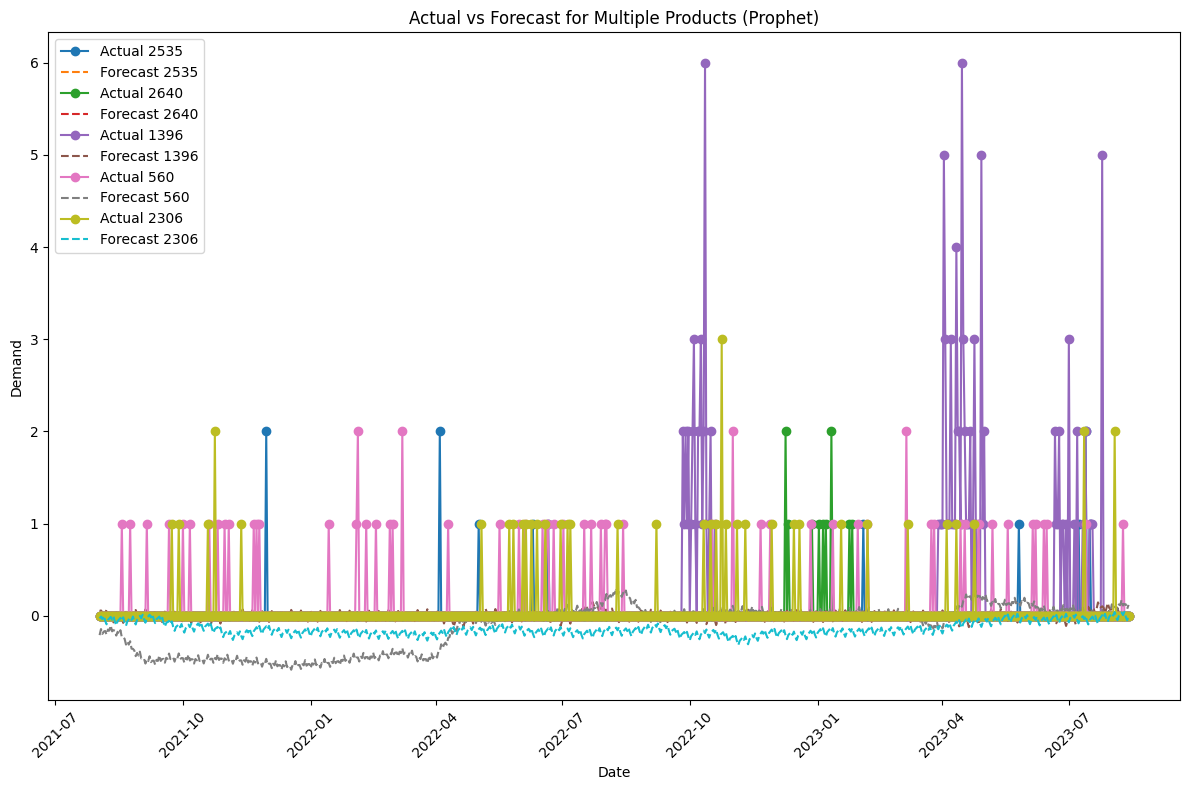

In [22]:
import seaborn as sns

# Plot actual vs forecast for a few random products
plt.figure(figsize=(12, 8))

# Loop through the random products and plot
for product_id in random_sample_products:
    product_data = combined_forecasts[combined_forecasts['product_id'] == product_id]
    plt.plot(product_data['ds'], product_data['y'], label=f'Actual {product_id}', linestyle='-', marker='o')
    plt.plot(product_data['ds'], product_data['yhat'], label=f'Forecast {product_id}', linestyle='--')

plt.title('Actual vs Forecast for Multiple Products (Prophet)')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


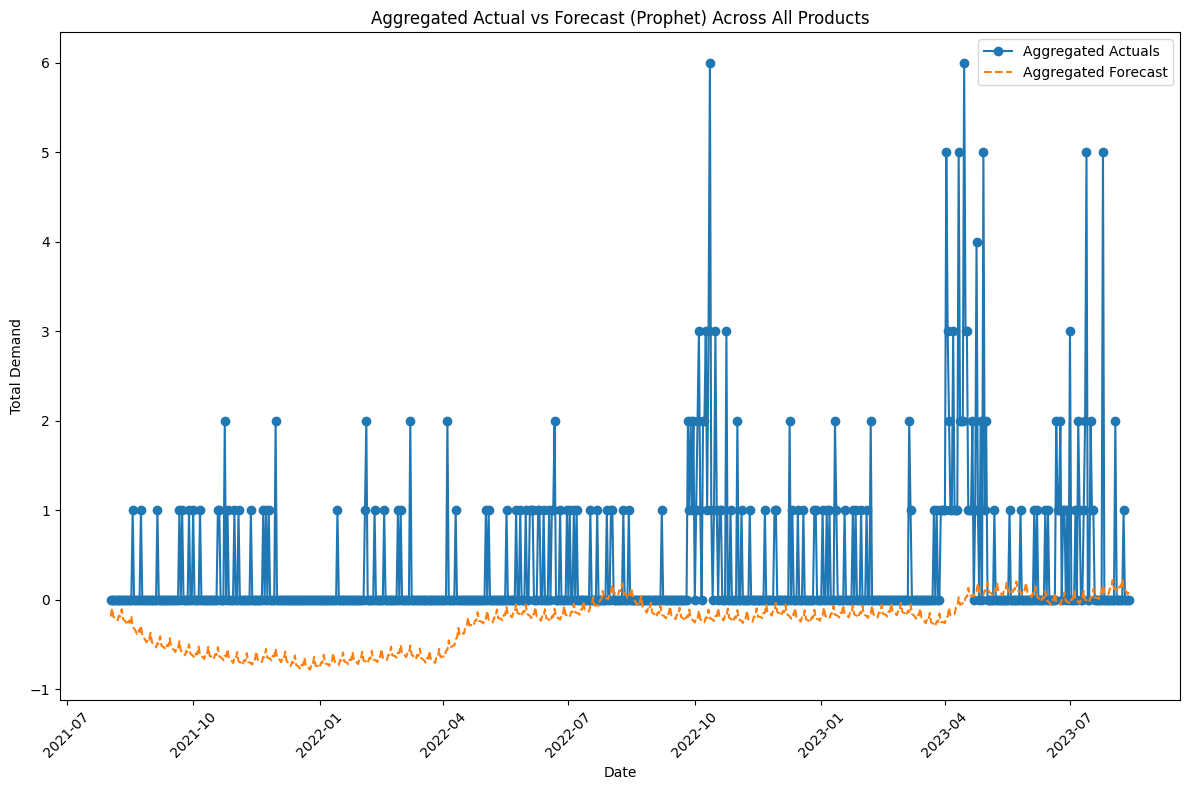

In [23]:
# Plot actual vs forecast overlay for all products (aggregated)
plt.figure(figsize=(12, 8))

# Group by ds and aggregate actuals and forecasts
aggregated_forecasts = combined_forecasts.groupby('ds').agg({'y': 'sum', 'yhat': 'sum'}).reset_index()

# Plot aggregated actual vs forecast
plt.plot(aggregated_forecasts['ds'], aggregated_forecasts['y'], label='Aggregated Actuals', linestyle='-', marker='o')
plt.plot(aggregated_forecasts['ds'], aggregated_forecasts['yhat'], label='Aggregated Forecast', linestyle='--')

plt.title('Aggregated Actual vs Forecast (Prophet) Across All Products')
plt.xlabel('Date')
plt.ylabel('Total Demand')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


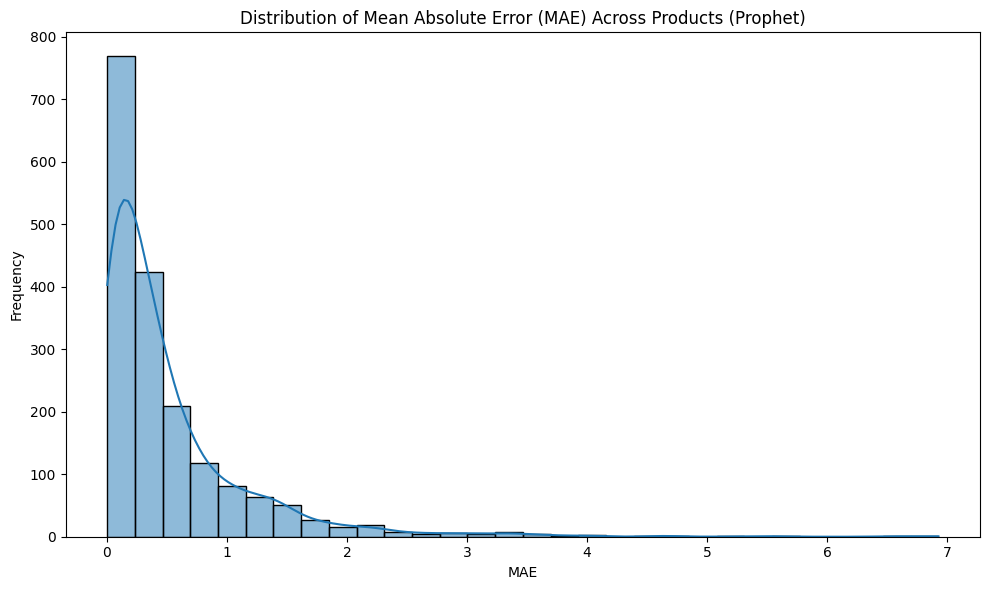

In [24]:

performance_df = pd.DataFrame(performance_metrics)

plt.figure(figsize=(10, 6))
sns.histplot(performance_df['mae'], bins=30, kde=True)
plt.title('Distribution of Mean Absolute Error (MAE) Across Products (Prophet)')
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


## LSTM

In [4]:
import numpy as np

# Load dataset for a clean slate
df = pd.read_csv('../../ml/data/historical/backup/processed_data_20241005_155929.csv')

# Drop rows with NaNs in any of the lag or rolling average columns
lag_columns = ['quantity_lag_1', 'quantity_lag_7', 'quantity_lag_14', 'quantity_lag_30', 'quantity_lag_90', 'quantity_lag_365']

# Drop rows that have NaN in any of the lag columns
df_cleaned = df.dropna(subset=lag_columns)

target = 'quantity'

# Select relevant columns for training
features = ['product_id_encoded', 'category_encoded',
            'in_stock', 'per_item_value',
            'quantity_lag_1', 'quantity_lag_7', 'quantity_lag_14', 'quantity_lag_30', 'quantity_lag_90', 'quantity_lag_365',
            'quantity_rolling_avg_7', 'quantity_rolling_avg_14', 'quantity_rolling_avg_30', 'quantity_rolling_avg_90', 'quantity_rolling_avg_365',
            'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos']

# Create sequences 
def create_lstm_sequences(df, features, target, sequence_length=30):
    X, y = [], []
    for product_id in df['product_id_encoded'].unique():
        product_data = df[df['product_id_encoded'] == product_id].sort_values(by='date')
        product_data = product_data[features + [target]] 
        
        for i in range(len(product_data) - sequence_length):
            X.append(product_data.iloc[i:i + sequence_length][features].values)  # Sequence of features
            y.append(product_data.iloc[i + sequence_length][target])  # Target at the end of the window
    
    return np.array(X), np.array(y)

# Create sequences for LSTM 
X, y = create_lstm_sequences(df_cleaned, features, target, sequence_length=30)

# Reshape X to be (samples, timesteps, features)
print(f"X shape: {X.shape}") 
print(f"y shape: {y.shape}")  


/var/folders/fp/13hwwrjs1l7b1bb0kcbdkw5w0000gn/T/ipykernel_17338/3537137745.py:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../ml/data/historical/backup/processed_data_20241005_155929.csv')


X shape: (631887, 30, 19)
y shape: (631887,)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Define the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    
    # Add an LSTM layer with 64 units
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    
    # Add a dropout layer for regularisation
    model.add(Dropout(0.2))
    
    # Add a Dense output layer with 1 unit
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    
    return model
# Get the input shape (timesteps, features) from the training data
input_shape = (X_train.shape[1], X_train.shape[2])

# Build the LSTM model using the defined function
model = build_lstm_model(input_shape)

# Print the model summary to verify the structure
model.summary()

# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=10, 
                    batch_size=32)


/Users/mireiataboada/personal-repos/project-module-2024-apr-mireiatz/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mireiataboada/personal-repos/project-module-2024-apr-mireiatz/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,569 (84.25 KB)

 Trainable params: 21,569 (84.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
15798/15798 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - loss: 0.9840 - val_loss: 0.7708
Epoch 2/10
15798/15798 ━━━━━━━━━━━━━━━━━━━━ 87s 5ms/step - loss: 0.8455 - val_loss: 0.6963
Epoch 3/10
15798/15798 ━━━━━━━━━━━━━━━━━━━━ 84s 5ms/step - loss: 0.8286 - val_loss: 0.7000
Epoch 4/10
15798/15798 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - loss: 0.8188 - val_loss: 0.7879
Epoch 5/10
15798/15798 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - loss: 0.8024 - val_loss: 0.7494
Epoch 6/10
15798/15798 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - loss: 0.7972 - val_loss: 0.7179
Epoch 7/10
15798/15798 ━━━━━━━━━━━━━━━━━━━━ 76s 5ms/step - loss: 0.7854 - val_loss: 0.7604
Epoch 8/10
15798/15798 ━━━━━━━━━━━━━━━━━━━━ 76s 5ms/step - loss: 0.7813 - val_loss: 0.7137
Epoch 9/10
15798/15798 ━━━━━━━━━━━━━━━━━━━━ 76s 5ms/step - loss: 0.7835 - val_loss: 0.6965
Epoch 10/10
15798/15798 ━━━━━━━━━━━━━━━━━━━━ 76s 5ms/step - loss: 0.7739 - val_loss: 0.6247


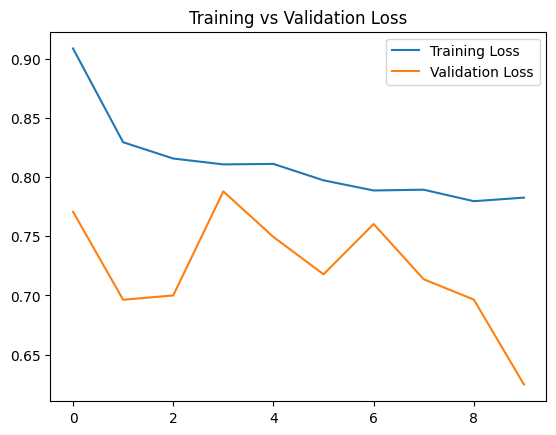

In [7]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


Epoch 1/10
15798/15798 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - loss: 0.7771 - val_loss: 0.6362
Epoch 2/10
15798/15798 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - loss: 0.7723 - val_loss: 0.7109
Epoch 3/10
15798/15798 ━━━━━━━━━━━━━━━━━━━━ 77s 5ms/step - loss: 0.8119 - val_loss: 0.6549
Epoch 4/10
15798/15798 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - loss: 0.8109 - val_loss: 0.6811
Epoch 5/10
15798/15798 ━━━━━━━━━━━━━━━━━━━━ 80s 5ms/step - loss: 0.8051 - val_loss: 0.6945
Epoch 6/10
15798/15798 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - loss: 0.7919 - val_loss: 0.6947
Epoch 7/10
15798/15798 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - loss: 0.8254 - val_loss: 0.6595
Epoch 8/10
15798/15798 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - loss: 0.7737 - val_loss: 0.6969
Epoch 9/10
15798/15798 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - loss: 0.8118 - val_loss: 0.7095
Epoch 10/10
15798/15798 ━━━━━━━━━━━━━━━━━━━━ 80s 5ms/step - loss: 0.7900 - val_loss: 0.6481


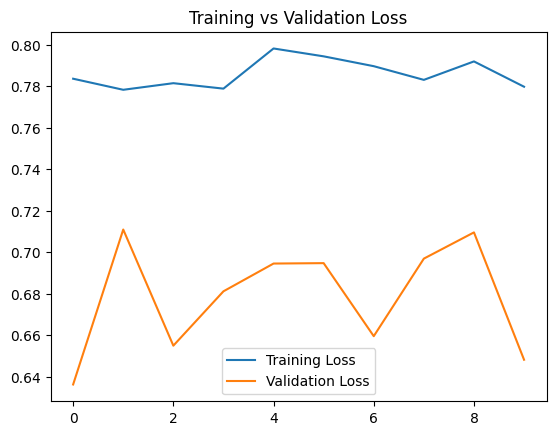

In [8]:
# Split data into train and validation sets
split_index = int(0.8 * len(X))  # 80% train, 20% validation
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=10,  # Adjust epochs based on performance
                    batch_size=32)

# Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


3950/3950 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


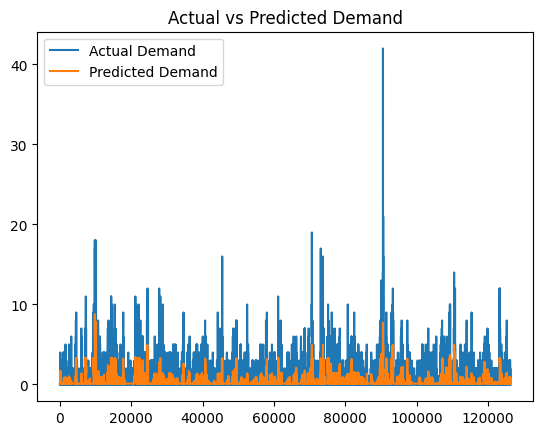

In [9]:
# Make predictions on the validation set
predictions = model.predict(X_val)

# Plot actual vs predicted values
import matplotlib.pyplot as plt

plt.plot(y_val, label='Actual Demand')
plt.plot(predictions, label='Predicted Demand')
plt.legend()
plt.title('Actual vs Predicted Demand')
plt.show()


/Users/mireiataboada/personal-repos/project-module-2024-apr-mireiatz/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 60, 128)        │        75,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,249 (489.25 KB)

 Trainable params: 125,249 (489.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
14432/14432 ━━━━━━━━━━━━━━━━━━━━ 672s 46ms/step - loss: 0.8821 - val_loss: 0.6755
Epoch 2/20
14432/14432 ━━━━━━━━━━━━━━━━━━━━ 613s 42ms/step - loss: 0.7482 - val_loss: 0.6423
Epoch 3/20
14432/14432 ━━━━━━━━━━━━━━━━━━━━ 605s 42ms/step - loss: 0.7333 - val_loss: 0.6470
Epoch 4/20
14432/14432 ━━━━━━━━━━━━━━━━━━━━ 692s 48ms/step - loss: 0.7263 - val_loss: 0.6304
Epoch 5/20
14432/14432 ━━━━━━━━━━━━━━━━━━━━ 682s 47ms/step - loss: 0.7462 - val_loss: 0.6071
Epoch 6/20
14432/14432 ━━━━━━━━━━━━━━━━━━━━ 700s 48ms/step - loss: 0.7111 - val_loss: 0.6113
Epoch 7/20
14432/14432 ━━━━━━━━━━━━━━━━━━━━ 719s 50ms/step - loss: 0.6985 - val_loss: 0.6195
Epoch 8/20
14432/14432 ━━━━━━━━━━━━━━━━━━━━ 761s 53ms/step - loss: 0.7358 - val_loss: 0.6435
Epoch 9/20
14432/14432 ━━━━━━━━━━━━━━━━━━━━ 722s 50ms/step - loss: 0.6990 - val_loss: 0.6136
Epoch 10/20
14432/14432 ━━━━━━━━━━━━━━━━━━━━ 700s 49ms/step - loss: 0.7050 - val_loss: 0.6534
Epoch 11/20
14432/14432 ━━━━━━━━━━━━━━━━━━━━ 776s 54ms/step - loss: 0

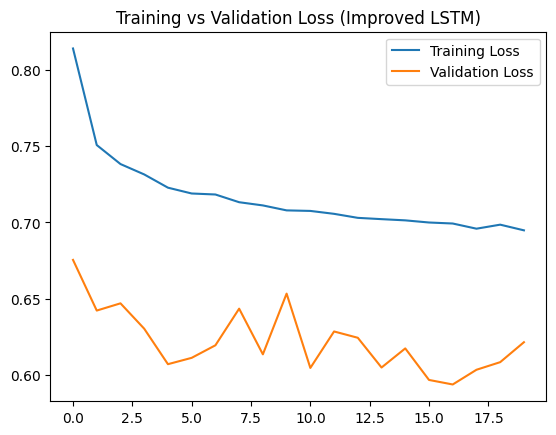

3608/3608 ━━━━━━━━━━━━━━━━━━━━ 46s 13ms/step


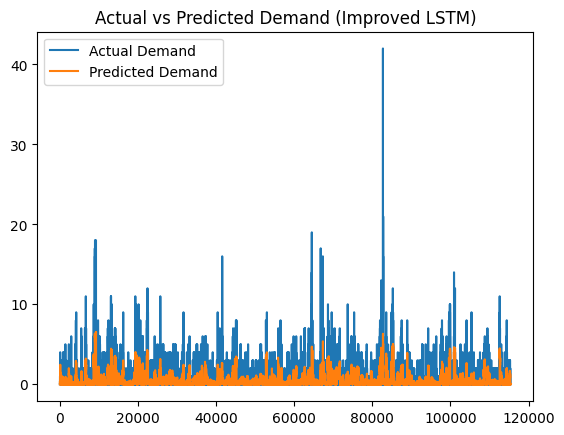

In [12]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Function to create sequences 
def create_lstm_sequences(df, features, target, sequence_length=60):  # Increased sequence length to 60 days
    X, y = [], []
    for product_id in df['product_id_encoded'].unique():
        product_data = df[df['product_id_encoded'] == product_id].sort_values(by='date')
        product_data = product_data[features + [target]]  
        
        for i in range(len(product_data) - sequence_length):
            X.append(product_data.iloc[i:i + sequence_length][features].values)  
            y.append(product_data.iloc[i + sequence_length][target]) 
    
    return np.array(X), np.array(y)

features = ['product_id_encoded', 'category_encoded',
            'in_stock', 'per_item_value',
            'quantity_lag_1', 'quantity_lag_7', 'quantity_lag_14', 'quantity_lag_30', 'quantity_lag_90', 'quantity_lag_365',
            'quantity_rolling_avg_7', 'quantity_rolling_avg_14', 'quantity_rolling_avg_30', 'quantity_rolling_avg_90', 'quantity_rolling_avg_365',
            'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos']

target = 'quantity'

# Create sequences using the new sequence length (60 days)
X, y = create_lstm_sequences(df_cleaned, features, target, sequence_length=60)

# Train-test split
split_index = int(0.8 * len(X))  # 80% for training, 20% for validation
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

# Define the improved LSTM model with more layers and units
def build_improved_lstm_model(input_shape):
    model = Sequential()
    
    # Add more LSTM layers and increase the number of units
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True)) 
    model.add(Dropout(0.3))  # Increased Dropout rate to prevent overfitting
    
    model.add(LSTM(64, return_sequences=False))  # Second LSTM layer with 64 units
    model.add(Dropout(0.2))
    
    # Dense output layer
    model.add(Dense(1))
    
    # Compile the model with a lower learning rate
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')  # Lower learning rate for finer adjustments
    
    return model

# Get the input shape for LSTM
input_shape = (X_train.shape[1], X_train.shape[2]) 

# Build the improved LSTM model
model = build_improved_lstm_model(input_shape)

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=20,  
                    batch_size=32)  # 

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss (Improved LSTM)')
plt.show()

# Make predictions on the validation set
predictions = model.predict(X_val)

# Plot actual vs predicted values
plt.plot(y_val, label='Actual Demand')
plt.plot(predictions, label='Predicted Demand')
plt.legend()
plt.title('Actual vs Predicted Demand (Improved LSTM)')
plt.show()


In [18]:
from datetime import datetime

def save_model(model, filename):
    # Use the current timestamp as the version
    MODEL_VERSION = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save the model using Keras's `save()` method
    model.save(f'../models/{filename}_{MODEL_VERSION}.keras')  # HDF5 format

    print(f"LSTM model {filename}_{MODEL_VERSION}.h5 saved successfully.")


save_model(model, 'lstm_model')


LSTM model lstm_model_20241006_160410.h5 saved successfully.
